##### Momentum Strategy - Based on Andreas F. Clenow’s book Stocks on the Move: Beating the Market with Hedge Fund Momentum Strategy

### Imports & Settings

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import datetime
import pandas as pd
import numpy as np
import pandas_datareader.data as web
idx = pd.IndexSlice

In [3]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import yfinance as yf
import investpy
import pyfolio as pf
import backtrader as bt
import collections
from scipy.stats import linregress

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [4]:
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
np.random.seed(42)
bt.__version__

'1.9.76.123'

### Prepare Data

We will take top Nifty 100 Indian companies for this analysis.

In [5]:
DATA_STORE = '../../Data-Daily/india_asset.h5'

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../../Data-Daily/india_asset.h5
/bse/bse50/metadata                       frame        (shape->[49,6])     
/bse/bse500/metadata                      frame        (shape->[472,7])    
/ind/bse500/prices                        frame        (shape->[1707187,7])
/ind/equity/prices                        frame        (shape->[1755502,7])
/ind/investing_meta/metadata              frame        (shape->[1,5])      
/ind/nifty500_investing/prices            frame        (shape->[1462693,5])
/ind/nifty50_investing/prices             frame        (shape->[213669,5]) 
/mf_eft/metadata                          frame        (shape->[23,5])     
/nse/nifty100/metadata                    frame        (shape->[1,10])     
/nse/nifty100_mid/metadata                frame        (shape->[1,4])      
/nse/nifty100_small/metadata              frame        (shape->[1,4])      
/nse/nifty200/metadata                    frame        (shape->[1,10])     
/nse/ni

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    nifty100_m = (store['/nse/nifty100/metadata'])
nifty100_m.head(2)

key_0      Symbol       Company Name  \
isin                                                        
INE012A01025  INE012A01025         ACC           ACC Ltd.   
INE358A01014  INE358A01014  ABBOTINDIA  Abbott India Ltd.   

                              Industry Series country          name  \
isin                                                                  
INE012A01025  CEMENT & CEMENT PRODUCTS     EQ   india           ACC   
INE358A01014                    PHARMA     EQ   india  Abbott India   

                     full_name currency symbol  
isin                                            
INE012A01025           ACC Ltd      INR    ACC  
INE358A01014  Abbott India Ltd      INR   ABOT

In [8]:
tickers = nifty100_m.dropna().symbol.to_list()
# not_avaible = ['ADANIGREEN', 'BANDHANBNK', 'HDFCAMC', 'TATACONSUM', 'MCDOWELL-N']
# tickers = [ele for ele in tickers if ele not in not_avaible]
print(tickers)
print(len(tickers))

['ACC', 'ABOT', 'ADNA', 'APSE', 'ADAI', 'ALKE', 'ABUJ', 'ASPN', 'ARBN', 'AVEU', 'AXBK', 'BAJA', 'BJFN', 'BJFS', 'BJAT', 'BANH', 'BOB', 'BRGR', 'BPCL', 'BRTI', 'BHRI', 'BION', 'BOSH', 'BRIT', 'CADI', 'CIPL', 'COAL', 'COLG', 'CCRI', 'DLF', 'DABU', 'DIVI', 'REDY', 'GAIL', 'GENA', 'GOCP', 'GRAS', 'HCLT', 'HDFA', 'HDBK', 'HDFL', 'HVEL', 'HROM', 'HALC', 'HPCL', 'HLL', 'HZNC', 'HDFC', 'ICBK', 'ICIL', 'ICIR', 'ITC', 'IOC', 'IGAS', 'INBK', 'INED', 'INFY', 'INGL', 'JSTL', 'KTKM', 'LRTI', 'LART', 'LUPN', 'MAHM', 'MRCO', 'MRTI', 'MOSS', 'MUTT', 'NMDC', 'NTPC', 'NEST', 'ONGC', 'ORCL', 'PLNG', 'PIDI', 'PIRA', 'PWFC', 'PGRD', 'PROC', 'PNBK', 'RELI', 'SBIL', 'SHCM', 'SIEM', 'SBI', 'SUN', 'TCS', 'TAGL', 'TAMO', 'TISC', 'TEML', 'TITN', 'TORP', 'UPLL', 'ULTC', 'UBBW', 'UNSP', 'WIPR']
98


In [9]:
# l = [pos for pos in tickers if pos not in ['ICICIBANK', 'ACC']]
# for i, d in enumerate(l[:5]):
#     print('i---', i)
#     print('d---', d)
# l = []
# for i, d in enumerate(tickers[:5]):
#     if d not in (['ICICIBANK', 'ACC']):
#         l.append(d)
# print(l)

In [10]:
columns = ['close','high','low','open','volume']
with pd.HDFStore(DATA_STORE) as store:
#     prices = store['/ind/bse500/prices'].loc[idx[tickers, :], columns]
    prices = store['/ind/nifty500_investing/prices'].loc[idx[tickers, :], columns]
prices.head(3)

close    high    low   open   volume
ticker date                                             
ACC    2000-01-03  268.55  271.45  255.1  258.9  5447617
       2000-01-04  256.60  269.50  255.1  268.0  2978528
       2000-01-05  250.30  268.00  244.5  249.9  2802364

In [11]:
# remove tickers where we have less than 10 years of data.
min_obs = 2520
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index
prices = prices.loc[idx[keep,:], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 341387 entries, ('ABOT', Timestamp('2000-01-03 00:00:00')) to ('WIPR', Timestamp('2020-12-24 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   close   341387 non-null  float64
 1   high    341387 non-null  float64
 2   low     341387 non-null  float64
 3   open    341387 non-null  float64
 4   volume  341387 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 14.5+ MB


In [12]:
prices.index.unique(level='ticker')

Index(['ABOT', 'ABUJ', 'ACC', 'APSE', 'ARBN', 'ASPN', 'AXBK', 'BAJA', 'BION',
       'BJAT', 'BJFN', 'BJFS', 'BOB', 'BOSH', 'BPCL', 'BRGR', 'BRIT', 'BRTI',
       'CADI', 'CCRI', 'COLG', 'DABU', 'DIVI', 'DLF', 'GAIL', 'GOCP', 'GRAS',
       'HALC', 'HCLT', 'HDBK', 'HDFC', 'HLL', 'HPCL', 'HROM', 'HVEL', 'HZNC',
       'ICBK', 'IGAS', 'INBK', 'INED', 'INFY', 'IOC', 'ITC', 'JSTL', 'KTKM',
       'LART', 'LUPN', 'MAHM', 'MOSS', 'MRCO', 'MRTI', 'NEST', 'NMDC', 'NTPC',
       'ONGC', 'ORCL', 'PGRD', 'PIDI', 'PIRA', 'PLNG', 'PNBK', 'PROC', 'PWFC',
       'REDY', 'RELI', 'SBI', 'SHCM', 'SIEM', 'SUN', 'TAGL', 'TAMO', 'TCS',
       'TEML', 'TISC', 'TITN', 'UBBW', 'ULTC', 'UNSP', 'UPLL', 'WIPR'],
      dtype='object', name='ticker')

In [13]:
len(prices.index.unique(level='ticker'))

80

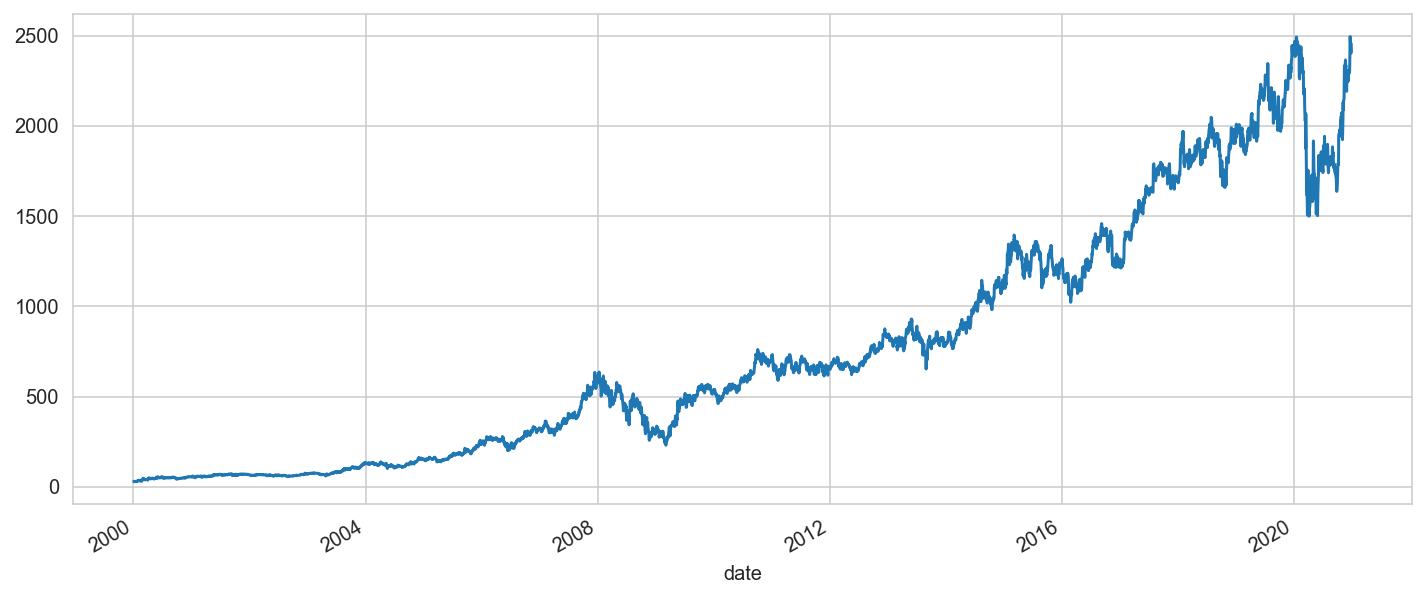

In [14]:
prices.loc['HDFC'].close.plot(figsize=(12,5));

In [15]:
fromdate=datetime.datetime(2010, 1, 1)
todate=datetime.datetime(2020, 12, 24)

In [16]:
# Calculate momentum
def momentum_func(self, the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return annualized * (rvalue ** 2)

In [17]:
class Momentum(bt.ind.OperationN):
    lines = ('trend',)
    params = dict(period=126)
    func = momentum_func

### Momentum with Equal Weights

In [18]:
class StrategyEqWt(bt.Strategy):
    params = dict(
        # parametrize the Momentum and its period
        momentum=Momentum,
        momentum_period=126,
        num_positions=30,

        # parametrize the Rebalancing period
        when=bt.timer.SESSION_START,
        timer=True,
        monthdays=[1],
        rebal_weekday=[1],  # If weekly rebalancing- Monday
        printlog=True,
        reserve=0.00  # 5% reserve capital
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function '''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            if isinstance(dt, float):
                dt = bt.num2date(dt)
            print("%s, %s" % (dt.isoformat(), txt))

    def __init__(self):
        self.add_timer(
            when=self.p.when,
#             monthdays=self.p.monthdays,
#             monthcarry=True,  # called on the 2nd day if the 1st is holiday
            weekdays=self.p.rebal_weekday,
            weekcarry=True,  # if a day isn't there, execute on the next
        )
        self.securities = self.datas
        self.inds = collections.defaultdict(dict)
        for d in self.datas:
            self.inds[d]['mom'] = self.p.momentum(d, period=self.p.momentum_period)

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def start(self):
        # Add a timer which will be called on the 1st trading day of the month
        self.add_timer(
            bt.timer.SESSION_END,  # when it will be called
#             monthdays=self.p.monthdays,  # called on the 1st day of the month
#             monthcarry=True,  # called on the 2nd day if the 1st is holiday
            weekdays=self.p.rebal_weekday,
            weekcarry=True,  # if a day isn't there, execute on the next

        )

    def notify_timer(self, timer, when, *args, **kwargs):
        if self._getminperstatus() < 0:
            self.rebalance()

    def rebalance(self):
        rankings = list(self.securities)
        rankings.sort(key=lambda s: self.inds[s]['mom'][0], reverse=True)

        # allocation perc per stock
        # reserve kept to make sure orders are not rejected due to
        # margin. Prices are calculated when known (close), but orders can only
        # be executed next day (opening price). Price can gap upwards
        pos_size = (1.0 - self.p.reserve) / self.p.num_positions

        # Sell stocks no longer meeting ranking filter.
        for i, d in enumerate(rankings):
            if self.getposition(d).size:
                if i > self.p.num_positions:
                    self.close(d)
                    self.log('Leave {} - Rank {:.2f}'.format(d._name, i)) 
        
        # Buy and rebalance stocks with remaining cash
        for i, d in enumerate(rankings[:self.p.num_positions]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            if not self.getposition(d).size:
                self.order_target_percent(d, target=pos_size)
                self.log('Buy {} - Rank {:.2f}'.format(d._name, i)) 

        # Final portfolio
        portfolio = []
        for i, d in enumerate(rankings):
            if self.getposition(d).size:
                if i < self.p.num_positions:
                    portfolio.append(d._name)
        self.log('Portfolio - %s'% portfolio)

    def next(self):
        return

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price, order.executed.value, order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price, order.executed.value,order.executed.comm))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
    
    def stop(self):
        self.log('| %2d | %2d |  %.2f |' %
                 (self.p.momentum_period, self.p.num_positions, self.broker.getvalue()), doprint=True)         

In [19]:
# Model Settings
startcash = 500000
momentum_period = 126 #days
num_positions = 30
reserve = 0.0
printlog=True,


# Commission and Slippage Settings
commission = 0.0025
# enable_slippage = True 
# slippage_volume_limit = 0.25
# slippage_impact = 0.1

In [20]:
cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_coc(True)
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission=commission)

In [21]:
# Add securities as datas1:
for ticker, data in prices.groupby(level=0):
    if ticker in tickers:
        print(f"Adding ticker: {ticker}")
        data = bt.feeds.PandasData(dataname=data.droplevel(level=0),
                                   name=str(ticker),
                                   fromdate=fromdate,
                                   todate=todate,
                                   plot=False)
        cerebro.adddata(data)

Adding ticker: ABOT
Adding ticker: ABUJ
Adding ticker: ACC
Adding ticker: APSE
Adding ticker: ARBN
Adding ticker: ASPN
Adding ticker: AXBK
Adding ticker: BAJA
Adding ticker: BION
Adding ticker: BJAT
Adding ticker: BJFN
Adding ticker: BJFS
Adding ticker: BOB
Adding ticker: BOSH
Adding ticker: BPCL
Adding ticker: BRGR
Adding ticker: BRIT
Adding ticker: BRTI
Adding ticker: CADI
Adding ticker: CCRI
Adding ticker: COLG
Adding ticker: DABU
Adding ticker: DIVI
Adding ticker: DLF
Adding ticker: GAIL
Adding ticker: GOCP
Adding ticker: GRAS
Adding ticker: HALC
Adding ticker: HCLT
Adding ticker: HDBK
Adding ticker: HDFC
Adding ticker: HLL
Adding ticker: HPCL
Adding ticker: HROM
Adding ticker: HVEL
Adding ticker: HZNC
Adding ticker: ICBK
Adding ticker: IGAS
Adding ticker: INBK
Adding ticker: INED
Adding ticker: INFY
Adding ticker: IOC
Adding ticker: ITC
Adding ticker: JSTL
Adding ticker: KTKM
Adding ticker: LART
Adding ticker: LUPN
Adding ticker: MAHM
Adding ticker: MOSS
Adding ticker: MRCO
Adding

In [22]:
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

cerebro.addstrategy(StrategyEqWt,
                    momentum_period = momentum_period,
                    num_positions = num_positions,
                    printlog = printlog,
                    reserve = reserve
                   )

0

In [23]:
%%time
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run the strategy. Results will be output from stop.
results_eq_wts = cerebro.run()

# # Run over everything
# cerebro.run(maxcpus=1)

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 500000.00
2010-07-19T00:00:00, Buy HVEL - Rank 0.00
2010-07-19T00:00:00, Buy DIVI - Rank 1.00
2010-07-19T00:00:00, Buy COLG - Rank 2.00
2010-07-19T00:00:00, Buy BJFN - Rank 3.00
2010-07-19T00:00:00, Buy TITN - Rank 4.00
2010-07-19T00:00:00, Buy ABOT - Rank 5.00
2010-07-19T00:00:00, Buy GOCP - Rank 6.00
2010-07-19T00:00:00, Buy CADI - Rank 7.00
2010-07-19T00:00:00, Buy BAJA - Rank 8.00
2010-07-19T00:00:00, Buy INBK - Rank 9.00
2010-07-19T00:00:00, Buy LUPN - Rank 10.00
2010-07-19T00:00:00, Buy BOB - Rank 11.00
2010-07-19T00:00:00, Buy UBBW - Rank 12.00
2010-07-19T00:00:00, Buy PIRA - Rank 13.00
2010-07-19T00:00:00, Buy ASPN - Rank 14.00
2010-07-19T00:00:00, Buy REDY - Rank 15.00
2010-07-19T00:00:00, Buy IGAS - Rank 16.00
2010-07-19T00:00:00, Buy BRGR - Rank 17.00
2010-07-19T00:00:00, Buy TAGL - Rank 18.00
2010-07-19T00:00:00, Buy DABU - Rank 19.00
2010-07-19T00:00:00, Buy BJAT - Rank 20.00
2010-07-19T00:00:00, Buy ITC - Rank 21.00
2010-07-19T00:00:00, Buy HDFC 

2010-09-07T00:00:00, Order Canceled/Margin/Rejected
2010-09-07T00:00:00, SELL EXECUTED, Price: 126.73, Cost: 16575.43, Comm 41.50
2010-09-07T00:00:00, SELL EXECUTED, Price: 371.55, Cost: 16449.40, Comm 40.87
2010-09-07T00:00:00, BUY EXECUTED, Price: 225.12, Cost: 18459.84, Comm 46.15
2010-09-13T00:00:00, Leave UPLL - Rank 31.00
2010-09-13T00:00:00, Buy MOSS - Rank 21.00
2010-09-13T00:00:00, Buy MAHM - Rank 29.00
2010-09-13T00:00:00, Portfolio - ['HVEL', 'BJFN', 'UBBW', 'HPCL', 'TITN', 'BRGR', 'DIVI', 'IGAS', 'BAJA', 'ASPN', 'BPCL', 'COLG', 'IOC', 'GOCP', 'PWFC', 'BRIT', 'SBI', 'INBK', 'BOSH', 'ABOT', 'ITC', 'DABU', 'BOB', 'ONGC', 'BJAT', 'BJFS', 'PIDI', 'TAGL']
2010-09-14T00:00:00, Order Canceled/Margin/Rejected
2010-09-14T00:00:00, SELL EXECUTED, Price: 126.80, Cost: 17871.23, Comm 44.06
2010-09-14T00:00:00, BUY EXECUTED, Price: 24.22, Cost: 18843.16, Comm 47.11
2010-09-20T00:00:00, Buy MAHM - Rank 25.00
2010-09-20T00:00:00, Portfolio - ['HVEL', 'UBBW', 'BJFN', 'HPCL', 'BRGR', 'TITN',

2010-12-14T00:00:00, Order Canceled/Margin/Rejected
2010-12-14T00:00:00, Order Canceled/Margin/Rejected
2010-12-14T00:00:00, Order Canceled/Margin/Rejected
2010-12-14T00:00:00, SELL EXECUTED, Price: 24.62, Cost: 18843.16, Comm 47.89
2010-12-14T00:00:00, SELL EXECUTED, Price: 379.90, Cost: 19555.20, Comm 45.59
2010-12-14T00:00:00, BUY EXECUTED, Price: 1077.80, Cost: 17244.80, Comm 43.11
2010-12-14T00:00:00, BUY EXECUTED, Price: 1050.80, Cost: 17863.60, Comm 44.66
2010-12-20T00:00:00, Leave SBI - Rank 32.00
2010-12-20T00:00:00, Leave PNBK - Rank 33.00
2010-12-20T00:00:00, Buy REDY - Rank 21.00
2010-12-20T00:00:00, Buy LUPN - Rank 24.00
2010-12-20T00:00:00, Buy MOSS - Rank 28.00
2010-12-20T00:00:00, Buy CADI - Rank 29.00
2010-12-20T00:00:00, Portfolio - ['TAMO', 'UBBW', 'HALC', 'TITN', 'TCS', 'ARBN', 'PLNG', 'INED', 'INBK', 'BJFN', 'SUN', 'BOB', 'ICBK', 'GRAS', 'ULTC', 'BAJA', 'BION', 'MAHM', 'NEST', 'BJAT', 'ABUJ', 'ACC', 'TISC', 'KTKM', 'HZNC', 'HDFC']
2010-12-21T00:00:00, Order Cancele

2011-03-01T00:00:00, SELL EXECUTED, Price: 84.95, Cost: 19271.15, Comm 32.92
2011-03-01T00:00:00, SELL EXECUTED, Price: 548.37, Cost: 18623.88, Comm 45.24
2011-03-01T00:00:00, SELL EXECUTED, Price: 1546.00, Cost: 17042.00, Comm 38.65
2011-03-01T00:00:00, BUY EXECUTED, Price: 317.00, Cost: 16167.00, Comm 40.42
2011-03-01T00:00:00, BUY EXECUTED, Price: 130.11, Cost: 16263.75, Comm 40.66
2011-03-01T00:00:00, BUY EXECUTED, Price: 243.71, Cost: 16328.57, Comm 40.82
2011-03-01T00:00:00, BUY EXECUTED, Price: 212.40, Cost: 16354.80, Comm 40.89
2011-03-01T00:00:00, BUY EXECUTED, Price: 221.42, Cost: 16163.66, Comm 40.41
2011-03-01T00:00:00, BUY EXECUTED, Price: 204.77, Cost: 16176.83, Comm 40.44
2011-03-01T00:00:00, BUY EXECUTED, Price: 263.05, Cost: 16309.10, Comm 40.77
2011-03-07T00:00:00, Leave PLNG - Rank 34.00
2011-03-07T00:00:00, Leave INFY - Rank 41.00
2011-03-07T00:00:00, Buy BJFN - Rank 24.00
2011-03-07T00:00:00, Buy SHCM - Rank 27.00
2011-03-07T00:00:00, Buy MRTI - Rank 28.00
2011-03-

2011-05-16T00:00:00, Leave HPCL - Rank 31.00
2011-05-16T00:00:00, Leave IOC - Rank 32.00
2011-05-16T00:00:00, Leave ONGC - Rank 33.00
2011-05-16T00:00:00, Leave BION - Rank 34.00
2011-05-16T00:00:00, Leave GOCP - Rank 39.00
2011-05-16T00:00:00, Buy PGRD - Rank 5.00
2011-05-16T00:00:00, Buy BJFS - Rank 6.00
2011-05-16T00:00:00, Buy UBBW - Rank 10.00
2011-05-16T00:00:00, Buy NMDC - Rank 21.00
2011-05-16T00:00:00, Buy BRTI - Rank 23.00
2011-05-16T00:00:00, Buy ITC - Rank 27.00
2011-05-16T00:00:00, Buy DIVI - Rank 29.00
2011-05-16T00:00:00, Portfolio - ['MOSS', 'HCLT', 'HZNC', 'SIEM', 'CADI', 'LUPN', 'LART', 'UNSP', 'MRTI', 'BRIT', 'PWFC', 'ORCL', 'GAIL', 'TAGL', 'ARBN', 'DLF', 'GRAS', 'JSTL', 'REDY', 'HLL', 'BJAT', 'CCRI', 'TCS']
2011-05-17T00:00:00, Order Canceled/Margin/Rejected
2011-05-17T00:00:00, SELL EXECUTED, Price: 84.84, Cost: 18033.90, Comm 49.84
2011-05-17T00:00:00, SELL EXECUTED, Price: 85.22, Cost: 16991.60, Comm 45.59
2011-05-17T00:00:00, SELL EXECUTED, Price: 197.97, Cost: 

2011-08-02T00:00:00, Order Canceled/Margin/Rejected
2011-08-02T00:00:00, Order Canceled/Margin/Rejected
2011-08-02T00:00:00, SELL EXECUTED, Price: 354.50, Cost: 18111.45, Comm 41.65
2011-08-02T00:00:00, SELL EXECUTED, Price: 496.50, Cost: 17886.40, Comm 39.72
2011-08-02T00:00:00, BUY EXECUTED, Price: 261.60, Cost: 18573.60, Comm 46.43
2011-08-08T00:00:00, Leave APSE - Rank 34.00
2011-08-08T00:00:00, Buy LUPN - Rank 21.00
2011-08-08T00:00:00, Buy BPCL - Rank 25.00
2011-08-08T00:00:00, Portfolio - ['BRIT', 'TITN', 'IGAS', 'DIVI', 'PLNG', 'ASPN', 'PIDI', 'BRGR', 'GOCP', 'MRCO', 'BRTI', 'ITC', 'INED', 'COLG', 'NEST', 'HLL', 'SUN', 'BOSH', 'CADI', 'HROM', 'MOSS', 'HPCL', 'HDBK', 'DABU', 'PROC', 'ABOT', 'INBK', 'KTKM']
2011-08-09T00:00:00, Order Canceled/Margin/Rejected
2011-08-09T00:00:00, SELL EXECUTED, Price: 136.15, Cost: 18852.00, Comm 40.84
2011-08-09T00:00:00, BUY EXECUTED, Price: 445.75, Cost: 17830.00, Comm 44.58
2011-08-16T00:00:00, Buy BPCL - Rank 20.00
2011-08-16T00:00:00, Portfo

2011-10-24T00:00:00, Leave BPCL - Rank 31.00
2011-10-24T00:00:00, Leave GAIL - Rank 32.00
2011-10-24T00:00:00, Leave TCS - Rank 36.00
2011-10-24T00:00:00, Leave INFY - Rank 41.00
2011-10-24T00:00:00, Leave PIDI - Rank 51.00
2011-10-24T00:00:00, Buy UPLL - Rank 19.00
2011-10-24T00:00:00, Buy ULTC - Rank 20.00
2011-10-24T00:00:00, Buy IOC - Rank 25.00
2011-10-24T00:00:00, Buy CADI - Rank 26.00
2011-10-24T00:00:00, Buy HCLT - Rank 28.00
2011-10-24T00:00:00, Buy HVEL - Rank 29.00
2011-10-24T00:00:00, Portfolio - ['IGAS', 'PLNG', 'BAJA', 'HROM', 'MAHM', 'HLL', 'COLG', 'LUPN', 'BRIT', 'ASPN', 'BJAT', 'MRTI', 'BOSH', 'REDY', 'ITC', 'RELI', 'NEST', 'ICBK', 'CCRI', 'WIPR', 'BOB', 'UNSP', 'NMDC', 'PIRA']
2011-10-25T00:00:00, Order Canceled/Margin/Rejected
2011-10-25T00:00:00, SELL EXECUTED, Price: 104.79, Cost: 17987.20, Comm 41.92
2011-10-25T00:00:00, SELL EXECUTED, Price: 119.73, Cost: 17905.58, Comm 45.20
2011-10-25T00:00:00, SELL EXECUTED, Price: 521.20, Cost: 17473.62, Comm 44.30
2011-10-25

2011-12-26T00:00:00, Buy NTPC - Rank 18.00
2011-12-26T00:00:00, Buy PIDI - Rank 19.00
2011-12-26T00:00:00, Buy HDBK - Rank 27.00
2011-12-26T00:00:00, Buy HPCL - Rank 29.00
2011-12-26T00:00:00, Portfolio - ['ACC', 'ABUJ', 'ULTC', 'BAJA', 'HLL', 'SHCM', 'GRAS', 'DABU', 'INED', 'GAIL', 'IOC', 'CADI', 'GOCP', 'MRTI', 'BJAT', 'PNBK', 'BOB', 'HROM', 'SIEM', 'UPLL', 'CCRI', 'HZNC', 'TEML', 'AXBK', 'SBI', 'ICBK']
2011-12-27T00:00:00, Order Canceled/Margin/Rejected
2011-12-27T00:00:00, SELL EXECUTED, Price: 118.75, Cost: 17864.72, Comm 31.77
2011-12-27T00:00:00, SELL EXECUTED, Price: 455.98, Cost: 17630.63, Comm 35.34
2011-12-27T00:00:00, SELL EXECUTED, Price: 1019.55, Cost: 17772.00, Comm 50.98
2011-12-27T00:00:00, BUY EXECUTED, Price: 122.98, Cost: 16971.24, Comm 42.43
2011-12-27T00:00:00, BUY EXECUTED, Price: 139.00, Cost: 16958.00, Comm 42.39
2011-12-27T00:00:00, BUY EXECUTED, Price: 221.36, Cost: 17044.72, Comm 42.61
2012-01-02T00:00:00, Leave ICBK - Rank 31.00
2012-01-02T00:00:00, Leave A

2012-02-21T00:00:00, Leave DABU - Rank 31.00
2012-02-21T00:00:00, Leave BPCL - Rank 35.00
2012-02-21T00:00:00, Leave SIEM - Rank 36.00
2012-02-21T00:00:00, Leave BJFS - Rank 41.00
2012-02-21T00:00:00, Leave BJAT - Rank 44.00
2012-02-21T00:00:00, Buy TAGL - Rank 20.00
2012-02-21T00:00:00, Buy KTKM - Rank 21.00
2012-02-21T00:00:00, Buy HCLT - Rank 22.00
2012-02-21T00:00:00, Buy PWFC - Rank 24.00
2012-02-21T00:00:00, Buy HDFC - Rank 25.00
2012-02-21T00:00:00, Buy BJFN - Rank 26.00
2012-02-21T00:00:00, Buy ORCL - Rank 28.00
2012-02-21T00:00:00, Portfolio - ['TAMO', 'SHCM', 'WIPR', 'HVEL', 'HLL', 'GRAS', 'PIRA', 'TCS', 'ABUJ', 'REDY', 'ULTC', 'SUN', 'ACC', 'INFY', 'DIVI', 'CADI', 'GAIL', 'PIDI', 'IGAS', 'IOC', 'INED', 'BION', 'BRTI']
2012-02-22T00:00:00, Order Canceled/Margin/Rejected
2012-02-22T00:00:00, SELL EXECUTED, Price: 105.05, Cost: 17523.00, Comm 46.48
2012-02-22T00:00:00, SELL EXECUTED, Price: 99.89, Cost: 18761.34, Comm 50.19
2012-02-22T00:00:00, SELL EXECUTED, Price: 827.25, Cos

2012-05-07T00:00:00, Leave WIPR - Rank 33.00
2012-05-07T00:00:00, Leave JSTL - Rank 34.00
2012-05-07T00:00:00, Buy ARBN - Rank 20.00
2012-05-07T00:00:00, Buy TITN - Rank 25.00
2012-05-07T00:00:00, Buy ITC - Rank 27.00
2012-05-07T00:00:00, Buy MOSS - Rank 29.00
2012-05-07T00:00:00, Portfolio - ['TAMO', 'SHCM', 'HVEL', 'BJFS', 'TAGL', 'BJFN', 'MRTI', 'UBBW', 'ULTC', 'GOCP', 'PIRA', 'ORCL', 'INBK', 'HCLT', 'BOSH', 'BPCL', 'MRCO', 'SUN', 'BRIT', 'HDBK', 'SBI', 'KTKM', 'LUPN', 'TEML', 'REDY', 'DABU']
2012-05-08T00:00:00, Order Canceled/Margin/Rejected
2012-05-08T00:00:00, Order Canceled/Margin/Rejected
2012-05-08T00:00:00, SELL EXECUTED, Price: 181.84, Cost: 17539.20, Comm 43.64
2012-05-08T00:00:00, SELL EXECUTED, Price: 72.17, Cost: 19184.88, Comm 47.63
2012-05-08T00:00:00, BUY EXECUTED, Price: 62.85, Cost: 19294.95, Comm 48.24
2012-05-08T00:00:00, BUY EXECUTED, Price: 248.70, Cost: 19149.90, Comm 47.87
2012-05-14T00:00:00, Leave DABU - Rank 31.00
2012-05-14T00:00:00, Leave PGRD - Rank 37.

2012-07-17T00:00:00, Order Canceled/Margin/Rejected
2012-07-17T00:00:00, Order Canceled/Margin/Rejected
2012-07-17T00:00:00, SELL EXECUTED, Price: 4525.15, Cost: 17949.40, Comm 45.25
2012-07-17T00:00:00, BUY EXECUTED, Price: 293.40, Cost: 19071.00, Comm 47.68
2012-07-23T00:00:00, Leave UBBW - Rank 34.00
2012-07-23T00:00:00, Leave INBK - Rank 35.00
2012-07-23T00:00:00, Leave ORCL - Rank 44.00
2012-07-23T00:00:00, Buy WIPR - Rank 22.00
2012-07-23T00:00:00, Buy HDBK - Rank 23.00
2012-07-23T00:00:00, Buy HZNC - Rank 24.00
2012-07-23T00:00:00, Buy RELI - Rank 26.00
2012-07-23T00:00:00, Buy APSE - Rank 27.00
2012-07-23T00:00:00, Buy NTPC - Rank 29.00
2012-07-23T00:00:00, Portfolio - ['BRGR', 'GOCP', 'DIVI', 'ASPN', 'BPCL', 'ITC', 'BOSH', 'PROC', 'HLL', 'BJFN', 'BJFS', 'SUN', 'MRCO', 'COLG', 'DABU', 'CADI', 'LUPN', 'HPCL', 'PIDI', 'PIRA', 'HVEL', 'KTKM', 'BRTI', 'INED']
2012-07-24T00:00:00, Order Canceled/Margin/Rejected
2012-07-24T00:00:00, Order Canceled/Margin/Rejected
2012-07-24T00:00:00,

2012-10-15T00:00:00, Leave PGRD - Rank 31.00
2012-10-15T00:00:00, Leave NMDC - Rank 32.00
2012-10-15T00:00:00, Buy BION - Rank 18.00
2012-10-15T00:00:00, Buy IGAS - Rank 25.00
2012-10-15T00:00:00, Buy RELI - Rank 26.00
2012-10-15T00:00:00, Buy GAIL - Rank 27.00
2012-10-15T00:00:00, Buy ORCL - Rank 28.00
2012-10-15T00:00:00, Portfolio - ['UNSP', 'BJFN', 'ABUJ', 'ULTC', 'TEML', 'DIVI', 'SHCM', 'GOCP', 'HLL', 'GRAS', 'LART', 'DABU', 'SUN', 'ICBK', 'UBBW', 'TAGL', 'HDBK', 'ACC', 'CADI', 'MAHM', 'ITC', 'MRCO', 'HDFC', 'PROC', 'BJFS']
2012-10-16T00:00:00, Order Canceled/Margin/Rejected
2012-10-16T00:00:00, Order Canceled/Margin/Rejected
2012-10-16T00:00:00, Order Canceled/Margin/Rejected
2012-10-16T00:00:00, SELL EXECUTED, Price: 118.85, Cost: 19633.95, Comm 47.84
2012-10-16T00:00:00, SELL EXECUTED, Price: 189.70, Cost: 19271.30, Comm 48.85
2012-10-16T00:00:00, BUY EXECUTED, Price: 44.66, Cost: 20588.26, Comm 51.47
2012-10-16T00:00:00, BUY EXECUTED, Price: 52.04, Cost: 20607.84, Comm 51.52
2

2012-12-24T00:00:00, Buy AXBK - Rank 20.00
2012-12-24T00:00:00, Buy COLG - Rank 21.00
2012-12-24T00:00:00, Buy PROC - Rank 28.00
2012-12-24T00:00:00, Buy HZNC - Rank 29.00
2012-12-24T00:00:00, Portfolio - ['UNSP', 'ARBN', 'MOSS', 'UBBW', 'SHCM', 'TAGL', 'BJFN', 'MAHM', 'TITN', 'MRTI', 'HCLT', 'ULTC', 'BAJA', 'HDFC', 'PIDI', 'GOCP', 'HDBK', 'MRCO', 'TEML', 'ICBK', 'BJFS', 'BION', 'ITC', 'GRAS', 'ABUJ', 'LART']
2012-12-26T00:00:00, Order Canceled/Margin/Rejected
2012-12-26T00:00:00, Order Canceled/Margin/Rejected
2012-12-26T00:00:00, Order Canceled/Margin/Rejected
2012-12-26T00:00:00, Order Canceled/Margin/Rejected
2012-12-31T00:00:00, Leave ABUJ - Rank 32.00
2012-12-31T00:00:00, Leave GRAS - Rank 33.00
2012-12-31T00:00:00, Buy AXBK - Rank 14.00
2012-12-31T00:00:00, Buy COLG - Rank 17.00
2012-12-31T00:00:00, Buy TAMO - Rank 21.00
2012-12-31T00:00:00, Buy PROC - Rank 26.00
2012-12-31T00:00:00, Buy INBK - Rank 27.00
2012-12-31T00:00:00, Buy HZNC - Rank 29.00
2012-12-31T00:00:00, Portfolio 

2013-03-04T00:00:00, Leave COLG - Rank 35.00
2013-03-04T00:00:00, Leave SBI - Rank 39.00
2013-03-04T00:00:00, Buy DLF - Rank 14.00
2013-03-04T00:00:00, Buy SUN - Rank 18.00
2013-03-04T00:00:00, Buy KTKM - Rank 26.00
2013-03-04T00:00:00, Buy GOCP - Rank 27.00
2013-03-04T00:00:00, Buy WIPR - Rank 28.00
2013-03-04T00:00:00, Buy BPCL - Rank 29.00
2013-03-04T00:00:00, Portfolio - ['UNSP', 'MOSS', 'AXBK', 'INBK', 'BJAT', 'ARBN', 'HCLT', 'BRGR', 'APSE', 'BRTI', 'ASPN', 'IOC', 'PIRA', 'PIDI', 'SHCM', 'BAJA', 'MRTI', 'TAMO', 'JSTL', 'REDY', 'PWFC', 'BJFN', 'MRCO', 'ICBK']
2013-03-05T00:00:00, Order Canceled/Margin/Rejected
2013-03-05T00:00:00, Order Canceled/Margin/Rejected
2013-03-05T00:00:00, Order Canceled/Margin/Rejected
2013-03-05T00:00:00, Order Canceled/Margin/Rejected
2013-03-05T00:00:00, SELL EXECUTED, Price: 1360.05, Cost: 20372.30, Comm 44.20
2013-03-05T00:00:00, SELL EXECUTED, Price: 209.95, Cost: 21427.76, Comm 45.14
2013-03-05T00:00:00, BUY EXECUTED, Price: 250.70, Cost: 20056.00,

2013-04-22T00:00:00, Buy DABU - Rank 14.00
2013-04-22T00:00:00, Buy BRIT - Rank 22.00
2013-04-22T00:00:00, Buy IGAS - Rank 27.00
2013-04-22T00:00:00, Portfolio - ['BRGR', 'PIDI', 'HCLT', 'WIPR', 'SUN', 'ASPN', 'PIRA', 'TCS', 'DLF', 'ONGC', 'INFY', 'GOCP', 'IOC', 'TEML', 'LUPN', 'BPCL', 'PGRD', 'GRAS', 'MOSS', 'NTPC', 'APSE', 'UNSP', 'DIVI', 'ABOT', 'PLNG', 'LART', 'ACC']
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-29T00:00:00, Leave UNSP - Rank 32.00
2013-04-29T00:00:00, Leave MOSS - Rank 37.00
2013-04-29T00:00:00, Buy DABU - Rank 11.00
2013-04-29T00:00:00, Buy BRIT - Rank 14.00
2013-04-29T00:00:00, Buy IGAS - Rank 16.00
2013-04-29T00:00:00, Buy HZNC - Rank 27.00
2013-04-29T00:00:00, Buy ABUJ - Rank 29.00
2013-04-29T00:00:00, Portfolio - ['BRGR', 'PIDI', 'SUN', 'HCLT', 'WIPR', 'ASPN', 'ONGC', 'PIRA', 'TCS', 'DLF', 'GOCP', 'LUPN', 'BPCL', 'IOC', 'PGRD', 'GRAS', 'NTPC',

2013-07-09T00:00:00, Order Canceled/Margin/Rejected
2013-07-09T00:00:00, SELL EXECUTED, Price: 149.20, Cost: 20876.00, Comm 50.73
2013-07-09T00:00:00, SELL EXECUTED, Price: 1256.55, Cost: 19735.30, Comm 53.40
2013-07-09T00:00:00, BUY EXECUTED, Price: 5133.60, Cost: 15400.80, Comm 38.50
2013-07-09T00:00:00, BUY EXECUTED, Price: 52.97, Cost: 20287.51, Comm 50.72
2013-07-15T00:00:00, Leave GAIL - Rank 35.00
2013-07-15T00:00:00, Leave BAJA - Rank 37.00
2013-07-15T00:00:00, Buy HVEL - Rank 17.00
2013-07-15T00:00:00, Buy MAHM - Rank 20.00
2013-07-15T00:00:00, Buy BJFN - Rank 27.00
2013-07-15T00:00:00, Buy TISC - Rank 28.00
2013-07-15T00:00:00, Portfolio - ['SUN', 'BRIT', 'LUPN', 'UNSP', 'BRGR', 'HLL', 'DABU', 'CCRI', 'PIDI', 'REDY', 'ITC', 'PROC', 'GOCP', 'KTKM', 'INBK', 'NEST', 'HCLT', 'BJAT', 'PLNG', 'HZNC', 'BJFS', 'HPCL', 'BOB', 'NMDC', 'PNBK', 'IGAS']
2013-07-16T00:00:00, Order Canceled/Margin/Rejected
2013-07-16T00:00:00, Order Canceled/Margin/Rejected
2013-07-16T00:00:00, SELL EXECUTE

2013-09-30T00:00:00, Leave BOB - Rank 31.00
2013-09-30T00:00:00, Leave GRAS - Rank 32.00
2013-09-30T00:00:00, Leave TAGL - Rank 36.00
2013-09-30T00:00:00, Buy BAJA - Rank 19.00
2013-09-30T00:00:00, Buy CADI - Rank 25.00
2013-09-30T00:00:00, Buy IGAS - Rank 26.00
2013-09-30T00:00:00, Buy BRTI - Rank 27.00
2013-09-30T00:00:00, Portfolio - ['TEML', 'HCLT', 'BRIT', 'HROM', 'TCS', 'LUPN', 'REDY', 'WIPR', 'BION', 'SUN', 'HLL', 'INFY', 'DABU', 'RELI', 'ORCL', 'TAMO', 'MOSS', 'PLNG', 'BJFS', 'UNSP', 'BJAT', 'INED', 'ONGC', 'BOSH', 'SBI', 'BPCL']
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, SELL EXECUTED, Price: 98.71, Cost: 20208.78, Comm 42.20
2013-10-01T00:00:00, SELL EXECUTED, Price: 433.00, Cost: 19314.33, Comm 53.04
2013-10-01T00:00:00, SELL EXECUTED, Price: 143.85, Cost: 19563.60, Comm 49.27
2013-10-01T00:00:00, BUY EXECUTED, Price: 1987.45, Cost: 19874.50, Comm 49.69
2013-10-01T00:00:00, BUY EXECUTED, Price:

2013-12-16T00:00:00, Buy BJAT - Rank 20.00
2013-12-16T00:00:00, Buy BJFS - Rank 24.00
2013-12-16T00:00:00, Buy ASPN - Rank 27.00
2013-12-16T00:00:00, Portfolio - ['TEML', 'ARBN', 'TISC', 'TAMO', 'HCLT', 'JSTL', 'BRIT', 'MOSS', 'NMDC', 'INED', 'WIPR', 'INFY', 'BION', 'TCS', 'HROM', 'HZNC', 'HALC', 'UPLL', 'SUN', 'REDY', 'GAIL', 'BRTI', 'BAJA', 'PGRD', 'LUPN', 'DABU', 'IOC']
2013-12-17T00:00:00, Order Canceled/Margin/Rejected
2013-12-17T00:00:00, Order Canceled/Margin/Rejected
2013-12-17T00:00:00, Order Canceled/Margin/Rejected
2013-12-23T00:00:00, Leave LUPN - Rank 31.00
2013-12-23T00:00:00, Leave IOC - Rank 32.00
2013-12-23T00:00:00, Leave BAJA - Rank 34.00
2013-12-23T00:00:00, Leave DABU - Rank 36.00
2013-12-23T00:00:00, Leave UBBW - Rank 41.00
2013-12-23T00:00:00, Buy BJAT - Rank 19.00
2013-12-23T00:00:00, Buy BJFS - Rank 21.00
2013-12-23T00:00:00, Buy BOB - Rank 23.00
2013-12-23T00:00:00, Buy MRTI - Rank 24.00
2013-12-23T00:00:00, Buy PWFC - Rank 26.00
2013-12-23T00:00:00, Buy SIEM 

2014-03-24T00:00:00, Leave TCS - Rank 31.00
2014-03-24T00:00:00, Leave JSTL - Rank 33.00
2014-03-24T00:00:00, Leave HVEL - Rank 37.00
2014-03-24T00:00:00, Leave COLG - Rank 53.00
2014-03-24T00:00:00, Buy IOC - Rank 17.00
2014-03-24T00:00:00, Buy PNBK - Rank 21.00
2014-03-24T00:00:00, Buy LUPN - Rank 25.00
2014-03-24T00:00:00, Buy SHCM - Rank 26.00
2014-03-24T00:00:00, Buy HLL - Rank 27.00
2014-03-24T00:00:00, Buy APSE - Rank 28.00
2014-03-24T00:00:00, Buy BPCL - Rank 29.00
2014-03-24T00:00:00, Portfolio - ['ARBN', 'INED', 'CADI', 'DIVI', 'HCLT', 'MOSS', 'HPCL', 'BION', 'BJFN', 'BJAT', 'ABOT', 'TEML', 'WIPR', 'PROC', 'UPLL', 'REDY', 'LART', 'INFY', 'GAIL', 'MRTI', 'SIEM', 'PWFC', 'BJFS']
2014-03-25T00:00:00, Order Canceled/Margin/Rejected
2014-03-25T00:00:00, Order Canceled/Margin/Rejected
2014-03-25T00:00:00, Order Canceled/Margin/Rejected
2014-03-25T00:00:00, SELL EXECUTED, Price: 1039.06, Cost: 19263.64, Comm 57.15
2014-03-25T00:00:00, SELL EXECUTED, Price: 97.92, Cost: 21211.25, Com

2014-05-26T00:00:00, Leave LUPN - Rank 31.00
2014-05-26T00:00:00, Leave HCLT - Rank 38.00
2014-05-26T00:00:00, Buy ONGC - Rank 21.00
2014-05-26T00:00:00, Buy ICBK - Rank 24.00
2014-05-26T00:00:00, Buy BOSH - Rank 26.00
2014-05-26T00:00:00, Buy SIEM - Rank 27.00
2014-05-26T00:00:00, Buy INBK - Rank 28.00
2014-05-26T00:00:00, Buy ULTC - Rank 29.00
2014-05-26T00:00:00, Portfolio - ['ARBN', 'HPCL', 'IOC', 'MOSS', 'BPCL', 'CCRI', 'SHCM', 'PNBK', 'CADI', 'BJAT', 'LART', 'BJFN', 'INED', 'APSE', 'AXBK', 'UPLL', 'PWFC', 'TITN', 'ACC', 'PROC', 'GAIL', 'DABU', 'ABOT', 'ITC']
2014-05-27T00:00:00, Order Canceled/Margin/Rejected
2014-05-27T00:00:00, Order Canceled/Margin/Rejected
2014-05-27T00:00:00, Order Canceled/Margin/Rejected
2014-05-27T00:00:00, SELL EXECUTED, Price: 909.40, Cost: 22884.00, Comm 54.56
2014-05-27T00:00:00, SELL EXECUTED, Price: 343.88, Cost: 20710.08, Comm 116.92
2014-05-27T00:00:00, BUY EXECUTED, Price: 270.20, Cost: 28100.80, Comm 70.25
2014-05-27T00:00:00, BUY EXECUTED, Pric

2014-08-12T00:00:00, Order Canceled/Margin/Rejected
2014-08-12T00:00:00, Order Canceled/Margin/Rejected
2014-08-12T00:00:00, Order Canceled/Margin/Rejected
2014-08-12T00:00:00, Order Canceled/Margin/Rejected
2014-08-12T00:00:00, SELL EXECUTED, Price: 261.98, Cost: 28297.22, Comm 70.08
2014-08-12T00:00:00, BUY EXECUTED, Price: 13708.00, Cost: 27416.00, Comm 68.54
2014-08-18T00:00:00, Leave BOB - Rank 31.00
2014-08-18T00:00:00, Buy BRGR - Rank 18.00
2014-08-18T00:00:00, Buy IGAS - Rank 21.00
2014-08-18T00:00:00, Buy PGRD - Rank 22.00
2014-08-18T00:00:00, Buy BJFS - Rank 26.00
2014-08-18T00:00:00, Buy HZNC - Rank 28.00
2014-08-18T00:00:00, Portfolio - ['UPLL', 'PWFC', 'HALC', 'CCRI', 'APSE', 'MOSS', 'MRTI', 'SHCM', 'PROC', 'AXBK', 'SBI', 'PNBK', 'TISC', 'BPCL', 'HPCL', 'ARBN', 'PLNG', 'BOSH', 'TITN', 'BJFN', 'BJAT', 'SIEM', 'LART', 'ONGC', 'ULTC']
2014-08-19T00:00:00, Order Canceled/Margin/Rejected
2014-08-19T00:00:00, Order Canceled/Margin/Rejected
2014-08-19T00:00:00, Order Canceled/Mar

2014-10-13T00:00:00, Leave UPLL - Rank 33.00
2014-10-13T00:00:00, Buy MRCO - Rank 19.00
2014-10-13T00:00:00, Buy CADI - Rank 21.00
2014-10-13T00:00:00, Buy HLL - Rank 26.00
2014-10-13T00:00:00, Buy TCS - Rank 27.00
2014-10-13T00:00:00, Buy NEST - Rank 29.00
2014-10-13T00:00:00, Portfolio - ['ABOT', 'BRIT', 'BRGR', 'PROC', 'MOSS', 'ARBN', 'MRTI', 'HVEL', 'BJFN', 'BOSH', 'LUPN', 'TEML', 'IGAS', 'SHCM', 'TITN', 'APSE', 'SUN', 'INED', 'BPCL', 'PLNG', 'BJFS', 'BJAT', 'CCRI', 'MAHM', 'HPCL']
2014-10-14T00:00:00, Order Canceled/Margin/Rejected
2014-10-14T00:00:00, Order Canceled/Margin/Rejected
2014-10-14T00:00:00, Order Canceled/Margin/Rejected
2014-10-14T00:00:00, Order Canceled/Margin/Rejected
2014-10-14T00:00:00, SELL EXECUTED, Price: 223.27, Cost: 21851.24, Comm 104.94
2014-10-14T00:00:00, BUY EXECUTED, Price: 147.95, Cost: 31513.35, Comm 78.78
2014-10-20T00:00:00, Leave MAHM - Rank 35.00
2014-10-20T00:00:00, Buy CADI - Rank 15.00
2014-10-20T00:00:00, Buy HLL - Rank 19.00
2014-10-20T00:0

2015-01-05T00:00:00, Buy ICBK - Rank 27.00
2015-01-05T00:00:00, Buy HDBK - Rank 28.00
2015-01-05T00:00:00, Buy PIRA - Rank 29.00
2015-01-05T00:00:00, Portfolio - ['BRIT', 'ABOT', 'ARBN', 'BJFN', 'CADI', 'INBK', 'HPCL', 'PIDI', 'BOSH', 'MRCO', 'KTKM', 'MRTI', 'BRGR', 'LUPN', 'SHCM', 'PROC', 'BJFS', 'HROM', 'INED', 'TEML', 'INFY', 'REDY', 'IGAS', 'MOSS']
2015-01-06T00:00:00, Order Canceled/Margin/Rejected
2015-01-06T00:00:00, Order Canceled/Margin/Rejected
2015-01-06T00:00:00, Order Canceled/Margin/Rejected
2015-01-06T00:00:00, Order Canceled/Margin/Rejected
2015-01-06T00:00:00, Order Canceled/Margin/Rejected
2015-01-06T00:00:00, SELL EXECUTED, Price: 760.30, Cost: 31699.80, Comm 83.63
2015-01-06T00:00:00, BUY EXECUTED, Price: 517.55, Cost: 35193.40, Comm 87.98
2015-01-12T00:00:00, Leave REDY - Rank 32.00
2015-01-12T00:00:00, Leave NEST - Rank 34.00
2015-01-12T00:00:00, Buy ASPN - Rank 19.00
2015-01-12T00:00:00, Buy BOB - Rank 20.00
2015-01-12T00:00:00, Buy HDBK - Rank 21.00
2015-01-12T0

2015-04-06T00:00:00, Buy ULTC - Rank 27.00
2015-04-06T00:00:00, Buy SUN - Rank 28.00
2015-04-06T00:00:00, Buy INFY - Rank 29.00
2015-04-06T00:00:00, Portfolio - ['BOSH', 'SIEM', 'BJFN', 'PIDI', 'BRIT', 'UNSP', 'UBBW', 'AXBK', 'INBK', 'PROC', 'BJFS', 'SHCM', 'LUPN', 'HDFC', 'KTKM', 'MRCO', 'ASPN', 'HDBK', 'DABU', 'ABUJ', 'HPCL', 'HLL', 'MOSS', 'UPLL', 'NEST', 'MRTI', 'ABOT']
2015-04-07T00:00:00, Order Canceled/Margin/Rejected
2015-04-07T00:00:00, Order Canceled/Margin/Rejected
2015-04-07T00:00:00, Order Canceled/Margin/Rejected
2015-04-13T00:00:00, Buy SUN - Rank 26.00
2015-04-13T00:00:00, Buy GOCP - Rank 28.00
2015-04-13T00:00:00, Buy ULTC - Rank 29.00
2015-04-13T00:00:00, Portfolio - ['BOSH', 'SIEM', 'BJFN', 'BRIT', 'PIDI', 'UBBW', 'UNSP', 'PROC', 'INBK', 'LUPN', 'AXBK', 'BJFS', 'SHCM', 'HDFC', 'MRCO', 'DABU', 'UPLL', 'KTKM', 'MOSS', 'HLL', 'ASPN', 'HPCL', 'HDBK', 'ABUJ', 'NEST', 'MRTI', 'ABOT']
2015-04-15T00:00:00, Order Canceled/Margin/Rejected
2015-04-15T00:00:00, Order Canceled/Ma

2015-06-16T00:00:00, Order Canceled/Margin/Rejected
2015-06-16T00:00:00, Order Canceled/Margin/Rejected
2015-06-16T00:00:00, Order Canceled/Margin/Rejected
2015-06-16T00:00:00, Order Canceled/Margin/Rejected
2015-06-16T00:00:00, SELL EXECUTED, Price: 6315.45, Cost: 27328.50, Comm 94.73
2015-06-16T00:00:00, SELL EXECUTED, Price: 895.15, Cost: 35902.95, Comm 82.80
2015-06-16T00:00:00, SELL EXECUTED, Price: 837.70, Cost: 37079.55, Comm 77.49
2015-06-16T00:00:00, SELL EXECUTED, Price: 535.30, Cost: 32884.00, Comm 107.06
2015-06-16T00:00:00, BUY EXECUTED, Price: 3320.60, Cost: 33206.00, Comm 83.02
2015-06-16T00:00:00, BUY EXECUTED, Price: 84.23, Cost: 36471.59, Comm 91.18
2015-06-16T00:00:00, BUY EXECUTED, Price: 111.68, Cost: 36407.68, Comm 91.02
2015-06-16T00:00:00, BUY EXECUTED, Price: 1327.95, Cost: 35854.65, Comm 89.64
2015-06-22T00:00:00, Leave SHCM - Rank 31.00
2015-06-22T00:00:00, Leave DABU - Rank 33.00
2015-06-22T00:00:00, Leave GOCP - Rank 34.00
2015-06-22T00:00:00, Leave NTPC - 

2015-08-17T00:00:00, Leave CCRI - Rank 38.00
2015-08-17T00:00:00, Leave PIRA - Rank 49.00
2015-08-17T00:00:00, Buy ABOT - Rank 16.00
2015-08-17T00:00:00, Buy PGRD - Rank 17.00
2015-08-17T00:00:00, Buy PROC - Rank 20.00
2015-08-17T00:00:00, Buy PWFC - Rank 21.00
2015-08-17T00:00:00, Buy PLNG - Rank 24.00
2015-08-17T00:00:00, Buy GOCP - Rank 26.00
2015-08-17T00:00:00, Buy DABU - Rank 29.00
2015-08-17T00:00:00, Portfolio - ['BRIT', 'HPCL', 'ARBN', 'UPLL', 'BJFN', 'ORCL', 'BPCL', 'MRCO', 'MRTI', 'BJFS', 'BAJA', 'IOC', 'CADI', 'RELI', 'BRTI', 'REDY', 'TITN', 'ACC', 'MAHM', 'JSTL', 'TAGL', 'MOSS', 'NMDC']
2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, Order Canceled/Margin/Rejected
2015-08-18T00:00:00, SELL EXECUTED, Price: 524.99, Cost: 36231.36, Comm 86.62
2015-08-18T00:00:00, SELL EXECUTED, Price: 930.25, Cost

2015-11-03T00:00:00, Order Canceled/Margin/Rejected
2015-11-03T00:00:00, Order Canceled/Margin/Rejected
2015-11-03T00:00:00, Order Canceled/Margin/Rejected
2015-11-03T00:00:00, Order Canceled/Margin/Rejected
2015-11-03T00:00:00, Order Canceled/Margin/Rejected
2015-11-03T00:00:00, SELL EXECUTED, Price: 283.67, Cost: 37250.64, Comm 94.32
2015-11-09T00:00:00, Leave BJFN - Rank 36.00
2015-11-09T00:00:00, Leave IOC - Rank 37.00
2015-11-09T00:00:00, Leave TITN - Rank 41.00
2015-11-09T00:00:00, Leave NTPC - Rank 43.00
2015-11-09T00:00:00, Buy BRGR - Rank 11.00
2015-11-09T00:00:00, Buy LUPN - Rank 12.00
2015-11-09T00:00:00, Buy BOB - Rank 17.00
2015-11-09T00:00:00, Buy CCRI - Rank 23.00
2015-11-09T00:00:00, Buy ITC - Rank 24.00
2015-11-09T00:00:00, Buy ABUJ - Rank 26.00
2015-11-09T00:00:00, Buy SHCM - Rank 28.00
2015-11-09T00:00:00, Buy AXBK - Rank 29.00
2015-11-09T00:00:00, Portfolio - ['ABOT', 'DIVI', 'BJAT', 'BRIT', 'REDY', 'BJFS', 'MRTI', 'IGAS', 'CADI', 'INFY', 'ARBN', 'WIPR', 'PROC', 'GO

2016-01-11T00:00:00, Leave ONGC - Rank 33.00
2016-01-11T00:00:00, Buy BJFN - Rank 12.00
2016-01-11T00:00:00, Buy APSE - Rank 28.00
2016-01-11T00:00:00, Buy TITN - Rank 29.00
2016-01-11T00:00:00, Portfolio - ['PLNG', 'ABOT', 'BJAT', 'ARBN', 'DIVI', 'JSTL', 'PROC', 'BRGR', 'MRTI', 'HCLT', 'ULTC', 'ABUJ', 'ICBK', 'AXBK', 'NMDC', 'UPLL', 'BJFS', 'BRTI', 'IGAS', 'DABU', 'BOSH', 'CCRI', 'SIEM', 'SBI', 'ACC', 'LART', 'TCS']
2016-01-12T00:00:00, Order Canceled/Margin/Rejected
2016-01-12T00:00:00, Order Canceled/Margin/Rejected
2016-01-12T00:00:00, SELL EXECUTED, Price: 150.33, Cost: 37999.62, Comm 92.45
2016-01-12T00:00:00, BUY EXECUTED, Price: 630.62, Cost: 35945.34, Comm 89.86
2016-01-18T00:00:00, Leave MRTI - Rank 38.00
2016-01-18T00:00:00, Buy TITN - Rank 18.00
2016-01-18T00:00:00, Buy APSE - Rank 28.00
2016-01-18T00:00:00, Buy UNSP - Rank 29.00
2016-01-18T00:00:00, Portfolio - ['PLNG', 'ABOT', 'ARBN', 'BJAT', 'JSTL', 'BRGR', 'PROC', 'BJFN', 'DIVI', 'HCLT', 'ULTC', 'ABUJ', 'IGAS', 'ICBK', 

2016-03-22T00:00:00, Order Canceled/Margin/Rejected
2016-03-22T00:00:00, SELL EXECUTED, Price: 296.83, Cost: 38007.27, Comm 95.73
2016-03-22T00:00:00, SELL EXECUTED, Price: 78.08, Cost: 35212.32, Comm 84.33
2016-03-22T00:00:00, SELL EXECUTED, Price: 98.20, Cost: 37913.20, Comm 77.82
2016-03-22T00:00:00, SELL EXECUTED, Price: 231.95, Cost: 38335.00, Comm 108.44
2016-03-22T00:00:00, BUY EXECUTED, Price: 274.16, Cost: 36189.12, Comm 90.47
2016-03-22T00:00:00, BUY EXECUTED, Price: 1367.47, Cost: 35554.22, Comm 88.89
2016-03-22T00:00:00, BUY EXECUTED, Price: 144.43, Cost: 36107.50, Comm 90.27
2016-03-22T00:00:00, BUY EXECUTED, Price: 847.95, Cost: 35613.90, Comm 89.03
2016-03-28T00:00:00, Leave HCLT - Rank 33.00
2016-03-28T00:00:00, Leave ASPN - Rank 38.00
2016-03-28T00:00:00, Buy HDBK - Rank 22.00
2016-03-28T00:00:00, Buy HDFC - Rank 24.00
2016-03-28T00:00:00, Buy LUPN - Rank 26.00
2016-03-28T00:00:00, Buy ABOT - Rank 28.00
2016-03-28T00:00:00, Portfolio - ['JSTL', 'PLNG', 'BJFN', 'MRCO', 

2016-06-13T00:00:00, Leave ABOT - Rank 32.00
2016-06-13T00:00:00, Leave UBBW - Rank 33.00
2016-06-13T00:00:00, Leave COLG - Rank 38.00
2016-06-13T00:00:00, Buy AXBK - Rank 23.00
2016-06-13T00:00:00, Buy DLF - Rank 26.00
2016-06-13T00:00:00, Buy ASPN - Rank 28.00
2016-06-13T00:00:00, Portfolio - ['HZNC', 'JSTL', 'TISC', 'UPLL', 'BJFN', 'PIRA', 'SHCM', 'BION', 'ULTC', 'MRCO', 'PIDI', 'HROM', 'INFY', 'PROC', 'HALC', 'HVEL', 'GRAS', 'ABUJ', 'BRTI', 'BOSH', 'GOCP', 'INBK', 'ACC', 'PLNG', 'TCS', 'PGRD', 'IGAS']
2016-06-14T00:00:00, Order Canceled/Margin/Rejected
2016-06-14T00:00:00, SELL EXECUTED, Price: 4468.90, Cost: 36699.60, Comm 89.38
2016-06-14T00:00:00, SELL EXECUTED, Price: 742.25, Cost: 36289.00, Comm 81.65
2016-06-14T00:00:00, SELL EXECUTED, Price: 862.90, Cost: 35613.90, Comm 90.60
2016-06-14T00:00:00, BUY EXECUTED, Price: 531.15, Cost: 38773.95, Comm 96.93
2016-06-14T00:00:00, BUY EXECUTED, Price: 130.40, Cost: 38989.60, Comm 97.47
2016-06-20T00:00:00, Leave PGRD - Rank 32.00
201

2016-09-12T00:00:00, Buy IGAS - Rank 23.00
2016-09-12T00:00:00, Buy BJAT - Rank 25.00
2016-09-12T00:00:00, Buy DIVI - Rank 26.00
2016-09-12T00:00:00, Portfolio - ['HALC', 'PIRA', 'BION', 'BJFS', 'HPCL', 'BJFN', 'PNBK', 'SHCM', 'BRGR', 'DLF', 'JSTL', 'TAMO', 'HZNC', 'BPCL', 'MRTI', 'AXBK', 'IOC', 'PGRD', 'ASPN', 'PLNG', 'MOSS', 'SBI', 'HVEL', 'BOSH', 'NTPC', 'INBK', 'ACC']
2016-09-14T00:00:00, Order Canceled/Margin/Rejected
2016-09-14T00:00:00, Order Canceled/Margin/Rejected
2016-09-14T00:00:00, SELL EXECUTED, Price: 758.43, Cost: 37212.48, Comm 102.39
2016-09-14T00:00:00, BUY EXECUTED, Price: 149.63, Cost: 43841.59, Comm 109.60
2016-09-19T00:00:00, Leave NTPC - Rank 32.00
2016-09-19T00:00:00, Leave ACC - Rank 34.00
2016-09-19T00:00:00, Buy DIVI - Rank 22.00
2016-09-19T00:00:00, Buy BJAT - Rank 23.00
2016-09-19T00:00:00, Buy PWFC - Rank 24.00
2016-09-19T00:00:00, Buy HDFC - Rank 27.00
2016-09-19T00:00:00, Buy BAJA - Rank 29.00
2016-09-19T00:00:00, Portfolio - ['HALC', 'PIRA', 'BION', 'B

2016-11-29T00:00:00, Order Canceled/Margin/Rejected
2016-11-29T00:00:00, Order Canceled/Margin/Rejected
2016-11-29T00:00:00, SELL EXECUTED, Price: 1166.20, Cost: 44368.50, Comm 96.21
2016-11-29T00:00:00, SELL EXECUTED, Price: 454.70, Cost: 39528.10, Comm 93.21
2016-11-29T00:00:00, SELL EXECUTED, Price: 225.80, Cost: 43814.00, Comm 107.26
2016-11-29T00:00:00, BUY EXECUTED, Price: 899.60, Cost: 43180.80, Comm 107.95
2016-11-29T00:00:00, BUY EXECUTED, Price: 6596.45, Cost: 39578.70, Comm 98.95
2016-12-05T00:00:00, Leave BJFN - Rank 31.00
2016-12-05T00:00:00, Leave ULTC - Rank 40.00
2016-12-05T00:00:00, Buy GAIL - Rank 22.00
2016-12-05T00:00:00, Buy UPLL - Rank 23.00
2016-12-05T00:00:00, Buy BRIT - Rank 26.00
2016-12-05T00:00:00, Buy INFY - Rank 27.00
2016-12-05T00:00:00, Buy WIPR - Rank 28.00
2016-12-05T00:00:00, Buy DABU - Rank 29.00
2016-12-05T00:00:00, Portfolio - ['HZNC', 'IGAS', 'BJFS', 'HPCL', 'IOC', 'PWFC', 'PLNG', 'HALC', 'ONGC', 'PNBK', 'BJAT', 'NMDC', 'APSE', 'BPCL', 'SBI', 'MRT

2017-02-13T00:00:00, Buy HCLT - Rank 25.00
2017-02-13T00:00:00, Buy ARBN - Rank 27.00
2017-02-13T00:00:00, Buy CCRI - Rank 28.00
2017-02-13T00:00:00, Buy HROM - Rank 29.00
2017-02-13T00:00:00, Portfolio - ['NMDC', 'HZNC', 'IGAS', 'ONGC', 'GAIL', 'IOC', 'HPCL', 'TISC', 'HALC', 'PWFC', 'PGRD', 'BPCL', 'COLG', 'BION', 'PLNG', 'SUN', 'INFY', 'MRCO', 'NEST', 'DABU', 'MAHM', 'APSE', 'HLL', 'AXBK', 'ACC']
2017-02-14T00:00:00, Order Canceled/Margin/Rejected
2017-02-14T00:00:00, Order Canceled/Margin/Rejected
2017-02-14T00:00:00, Order Canceled/Margin/Rejected
2017-02-14T00:00:00, SELL EXECUTED, Price: 679.00, Cost: 45127.60, Comm 120.52
2017-02-14T00:00:00, SELL EXECUTED, Price: 1196.70, Cost: 40990.95, Comm 116.68
2017-02-14T00:00:00, BUY EXECUTED, Price: 143.75, Cost: 47293.75, Comm 118.23
2017-02-14T00:00:00, BUY EXECUTED, Price: 413.65, Cost: 47156.10, Comm 117.89
2017-02-20T00:00:00, Buy ARBN - Rank 21.00
2017-02-20T00:00:00, Buy HROM - Rank 26.00
2017-02-20T00:00:00, Buy TEML - Rank 29.0

2017-04-17T00:00:00, Leave NTPC - Rank 35.00
2017-04-17T00:00:00, Leave TEML - Rank 45.00
2017-04-17T00:00:00, Buy HLL - Rank 22.00
2017-04-17T00:00:00, Buy HVEL - Rank 24.00
2017-04-17T00:00:00, Buy MRTI - Rank 25.00
2017-04-17T00:00:00, Buy GRAS - Rank 26.00
2017-04-17T00:00:00, Buy LART - Rank 27.00
2017-04-17T00:00:00, Buy SBI - Rank 29.00
2017-04-17T00:00:00, Portfolio - ['IGAS', 'IOC', 'BION', 'HZNC', 'GAIL', 'ORCL', 'TISC', 'TITN', 'BJFS', 'HALC', 'RELI', 'ITC', 'MOSS', 'HPCL', 'PWFC', 'INBK', 'HDBK', 'BRTI', 'APSE', 'PGRD', 'JSTL', 'HCLT', 'NMDC', 'UBBW']
2017-04-18T00:00:00, Order Canceled/Margin/Rejected
2017-04-18T00:00:00, Order Canceled/Margin/Rejected
2017-04-18T00:00:00, Order Canceled/Margin/Rejected
2017-04-18T00:00:00, Order Canceled/Margin/Rejected
2017-04-18T00:00:00, SELL EXECUTED, Price: 132.75, Cost: 47293.75, Comm 109.19
2017-04-18T00:00:00, SELL EXECUTED, Price: 421.95, Cost: 47481.00, Comm 100.21
2017-04-18T00:00:00, BUY EXECUTED, Price: 914.05, Cost: 47530.60

2017-06-20T00:00:00, Order Canceled/Margin/Rejected
2017-06-20T00:00:00, SELL EXECUTED, Price: 310.90, Cost: 47027.20, Comm 129.80
2017-06-20T00:00:00, SELL EXECUTED, Price: 142.74, Cost: 43519.64, Comm 129.18
2017-06-20T00:00:00, BUY EXECUTED, Price: 531.35, Cost: 48352.85, Comm 120.88
2017-06-20T00:00:00, BUY EXECUTED, Price: 1095.65, Cost: 48208.60, Comm 120.52
2017-06-20T00:00:00, BUY EXECUTED, Price: 249.90, Cost: 48480.60, Comm 121.20
2017-06-27T00:00:00, Leave ULTC - Rank 31.00
2017-06-27T00:00:00, Leave IOC - Rank 35.00
2017-06-27T00:00:00, Buy UPLL - Rank 23.00
2017-06-27T00:00:00, Buy PLNG - Rank 26.00
2017-06-27T00:00:00, Buy ACC - Rank 27.00
2017-06-27T00:00:00, Buy ITC - Rank 28.00
2017-06-27T00:00:00, Portfolio - ['PIRA', 'DLF', 'BJFN', 'MOSS', 'TITN', 'HDBK', 'KTKM', 'CADI', 'BJFS', 'HLL', 'LART', 'HDFC', 'GRAS', 'PIDI', 'MRCO', 'MRTI', 'HVEL', 'ASPN', 'APSE', 'CCRI', 'INBK', 'RELI', 'GOCP', 'BRIT', 'SHCM', 'BRGR']
2017-06-28T00:00:00, Order Canceled/Margin/Rejected
2017

2017-09-25T00:00:00, Leave PIRA - Rank 33.00
2017-09-25T00:00:00, Buy BJFS - Rank 24.00
2017-09-25T00:00:00, Buy HPCL - Rank 26.00
2017-09-25T00:00:00, Buy INED - Rank 27.00
2017-09-25T00:00:00, Buy ABUJ - Rank 29.00
2017-09-25T00:00:00, Portfolio - ['BJFN', 'TISC', 'HLL', 'GRAS', 'TITN', 'JSTL', 'MRTI', 'MOSS', 'IGAS', 'HDBK', 'BRIT', 'TAGL', 'INBK', 'UNSP', 'HALC', 'BJAT', 'HDFC', 'RELI', 'APSE', 'BRTI', 'HROM', 'PIDI', 'PROC', 'ACC', 'WIPR', 'KTKM']
2017-09-26T00:00:00, Order Canceled/Margin/Rejected
2017-09-26T00:00:00, Order Canceled/Margin/Rejected
2017-09-26T00:00:00, Order Canceled/Margin/Rejected
2017-09-26T00:00:00, SELL EXECUTED, Price: 2685.81, Cost: 46199.45, Comm 127.58
2017-09-26T00:00:00, BUY EXECUTED, Price: 5110.60, Cost: 45995.40, Comm 114.99
2017-10-03T00:00:00, Leave ACC - Rank 31.00
2017-10-03T00:00:00, Leave ICBK - Rank 36.00
2017-10-03T00:00:00, Buy HPCL - Rank 22.00
2017-10-03T00:00:00, Buy INED - Rank 25.00
2017-10-03T00:00:00, Buy ABUJ - Rank 28.00
2017-10-03

2017-12-26T00:00:00, Leave HZNC - Rank 32.00
2017-12-26T00:00:00, Buy ONGC - Rank 22.00
2017-12-26T00:00:00, Buy BION - Rank 25.00
2017-12-26T00:00:00, Buy HVEL - Rank 27.00
2017-12-26T00:00:00, Buy TCS - Rank 29.00
2017-12-26T00:00:00, Portfolio - ['TAGL', 'DIVI', 'IGAS', 'TITN', 'GAIL', 'TEML', 'BRIT', 'UBBW', 'TISC', 'RELI', 'BJAT', 'PROC', 'BAJA', 'INED', 'BRTI', 'MOSS', 'PLNG', 'DABU', 'NEST', 'HLL', 'MRTI', 'UNSP', 'JSTL', 'HALC', 'NTPC', 'HDBK']
2017-12-27T00:00:00, Order Canceled/Margin/Rejected
2017-12-27T00:00:00, Order Canceled/Margin/Rejected
2017-12-27T00:00:00, Order Canceled/Margin/Rejected
2017-12-27T00:00:00, Order Canceled/Margin/Rejected
2017-12-27T00:00:00, SELL EXECUTED, Price: 307.00, Cost: 53080.95, Comm 128.17
2018-01-01T00:00:00, Leave CCRI - Rank 31.00
2018-01-01T00:00:00, Buy ONGC - Rank 22.00
2018-01-01T00:00:00, Buy BION - Rank 23.00
2018-01-01T00:00:00, Buy HVEL - Rank 26.00
2018-01-01T00:00:00, Buy ABOT - Rank 29.00
2018-01-01T00:00:00, Portfolio - ['TAGL

2018-03-19T00:00:00, Leave RELI - Rank 31.00
2018-03-19T00:00:00, Leave TISC - Rank 33.00
2018-03-19T00:00:00, Leave DABU - Rank 48.00
2018-03-19T00:00:00, Buy BJFN - Rank 23.00
2018-03-19T00:00:00, Buy BOSH - Rank 24.00
2018-03-19T00:00:00, Buy ICBK - Rank 26.00
2018-03-19T00:00:00, Buy HCLT - Rank 27.00
2018-03-19T00:00:00, Buy HPCL - Rank 28.00
2018-03-19T00:00:00, Buy CADI - Rank 29.00
2018-03-19T00:00:00, Portfolio - ['BION', 'TEML', 'ABOT', 'INFY', 'TITN', 'TAGL', 'TCS', 'JSTL', 'GOCP', 'DLF', 'ORCL', 'MAHM', 'LART', 'PIDI', 'UNSP', 'PROC', 'UBBW', 'INED', 'MRTI', 'HLL', 'DIVI', 'PGRD', 'BRIT', 'ONGC']
2018-03-20T00:00:00, Order Canceled/Margin/Rejected
2018-03-20T00:00:00, Order Canceled/Margin/Rejected
2018-03-20T00:00:00, SELL EXECUTED, Price: 887.09, Cost: 47095.68, Comm 168.55
2018-03-20T00:00:00, SELL EXECUTED, Price: 574.95, Cost: 49636.60, Comm 122.18
2018-03-20T00:00:00, SELL EXECUTED, Price: 319.70, Cost: 53171.25, Comm 131.88
2018-03-20T00:00:00, BUY EXECUTED, Price: 1

2018-06-04T00:00:00, Leave BPCL - Rank 32.00
2018-06-04T00:00:00, Leave LART - Rank 34.00
2018-06-04T00:00:00, Leave BJAT - Rank 41.00
2018-06-04T00:00:00, Leave DIVI - Rank 47.00
2018-06-04T00:00:00, Buy BJFS - Rank 20.00
2018-06-04T00:00:00, Buy PIRA - Rank 22.00
2018-06-04T00:00:00, Buy ULTC - Rank 25.00
2018-06-04T00:00:00, Buy BRGR - Rank 26.00
2018-06-04T00:00:00, Buy ASPN - Rank 27.00
2018-06-04T00:00:00, Buy IOC - Rank 28.00
2018-06-04T00:00:00, Portfolio - ['TEML', 'TCS', 'KTKM', 'JSTL', 'PIDI', 'BION', 'BRIT', 'INBK', 'ABOT', 'GOCP', 'INFY', 'NEST', 'MAHM', 'HLL', 'BJFN', 'TITN', 'HDBK', 'PLNG', 'IGAS', 'BAJA', 'HDFC', 'ABUJ', 'CADI', 'ACC']
2018-06-05T00:00:00, Order Canceled/Margin/Rejected
2018-06-05T00:00:00, Order Canceled/Margin/Rejected
2018-06-05T00:00:00, Order Canceled/Margin/Rejected
2018-06-05T00:00:00, SELL EXECUTED, Price: 408.50, Cost: 55923.40, Comm 139.91
2018-06-05T00:00:00, SELL EXECUTED, Price: 1357.85, Cost: 53182.35, Comm 132.39
2018-06-05T00:00:00, SELL

2018-08-06T00:00:00, Buy UBBW - Rank 27.00
2018-08-06T00:00:00, Buy DLF - Rank 28.00
2018-08-06T00:00:00, Portfolio - ['BJFN', 'NEST', 'BRIT', 'ABOT', 'HLL', 'TCS', 'BJFS', 'KTKM', 'MAHM', 'BRGR', 'ASPN', 'GOCP', 'INFY', 'HDBK', 'INBK', 'PIDI', 'DABU', 'MRCO', 'RELI', 'HVEL', 'BJAT', 'PROC', 'GRAS', 'SIEM', 'BRTI', 'TEML', 'ONGC']
2018-08-07T00:00:00, Order Canceled/Margin/Rejected
2018-08-07T00:00:00, Order Canceled/Margin/Rejected
2018-08-07T00:00:00, SELL EXECUTED, Price: 228.65, Cost: 54788.25, Comm 130.90
2018-08-07T00:00:00, BUY EXECUTED, Price: 1979.30, Cost: 59379.00, Comm 148.45
2018-08-13T00:00:00, Leave TEML - Rank 35.00
2018-08-13T00:00:00, Buy UBBW - Rank 23.00
2018-08-13T00:00:00, Buy HZNC - Rank 26.00
2018-08-13T00:00:00, Buy DLF - Rank 28.00
2018-08-13T00:00:00, Buy NMDC - Rank 29.00
2018-08-13T00:00:00, Portfolio - ['BJFN', 'NEST', 'BRIT', 'ABOT', 'TCS', 'HLL', 'BJFS', 'MAHM', 'BRGR', 'ASPN', 'KTKM', 'GOCP', 'INFY', 'HDBK', 'DABU', 'INBK', 'MRCO', 'PIDI', 'RELI', 'HVEL

2018-10-22T00:00:00, Leave NEST - Rank 32.00
2018-10-22T00:00:00, Leave BJFS - Rank 34.00
2018-10-22T00:00:00, Leave HLL - Rank 37.00
2018-10-22T00:00:00, Leave BJAT - Rank 50.00
2018-10-22T00:00:00, Buy HCLT - Rank 18.00
2018-10-22T00:00:00, Buy CCRI - Rank 21.00
2018-10-22T00:00:00, Buy TITN - Rank 24.00
2018-10-22T00:00:00, Buy UNSP - Rank 25.00
2018-10-22T00:00:00, Buy MOSS - Rank 26.00
2018-10-22T00:00:00, Buy APSE - Rank 29.00
2018-10-22T00:00:00, Portfolio - ['INFY', 'TCS', 'RELI', 'INED', 'SUN', 'ABOT', 'REDY', 'ARBN', 'DABU', 'WIPR', 'JSTL', 'AXBK', 'HVEL', 'BJFN', 'GAIL', 'LUPN', 'DIVI', 'HROM', 'ICBK', 'SBI', 'SIEM', 'TAGL', 'UBBW', 'ITC']
2018-10-23T00:00:00, Order Canceled/Margin/Rejected
2018-10-23T00:00:00, Order Canceled/Margin/Rejected
2018-10-23T00:00:00, SELL EXECUTED, Price: 9641.00, Cost: 54556.20, Comm 144.61
2018-10-23T00:00:00, SELL EXECUTED, Price: 5250.20, Cost: 51736.95, Comm 118.13
2018-10-23T00:00:00, SELL EXECUTED, Price: 1584.90, Cost: 48208.60, Comm 174.

2018-12-24T00:00:00, Leave HDBK - Rank 34.00
2018-12-24T00:00:00, Leave BAJA - Rank 40.00
2018-12-24T00:00:00, Leave HCLT - Rank 41.00
2018-12-24T00:00:00, Buy LART - Rank 17.00
2018-12-24T00:00:00, Buy TAMO - Rank 25.00
2018-12-24T00:00:00, Buy GOCP - Rank 28.00
2018-12-24T00:00:00, Buy CADI - Rank 29.00
2018-12-24T00:00:00, Portfolio - ['DIVI', 'ARBN', 'WIPR', 'ICBK', 'PWFC', 'UPLL', 'REDY', 'INED', 'HVEL', 'AXBK', 'TAGL', 'IOC', 'INBK', 'KTKM', 'ORCL', 'MAHM', 'MOSS', 'GRAS', 'MRTI', 'BRTI', 'HROM', 'PROC', 'HPCL', 'BPCL', 'PNBK', 'SIEM']
2018-12-26T00:00:00, Order Canceled/Margin/Rejected
2018-12-26T00:00:00, SELL EXECUTED, Price: 1038.01, Cost: 55877.90, Comm 137.54
2018-12-26T00:00:00, SELL EXECUTED, Price: 2724.65, Cost: 54720.00, Comm 136.23
2018-12-26T00:00:00, SELL EXECUTED, Price: 468.93, Cost: 53412.18, Comm 127.78
2018-12-26T00:00:00, BUY EXECUTED, Price: 1404.80, Cost: 54787.20, Comm 136.97
2018-12-26T00:00:00, BUY EXECUTED, Price: 172.50, Cost: 56062.50, Comm 140.16
2018

2019-03-18T00:00:00, Leave GRAS - Rank 36.00
2019-03-18T00:00:00, Leave ONGC - Rank 37.00
2019-03-18T00:00:00, Leave GAIL - Rank 38.00
2019-03-18T00:00:00, Buy SIEM - Rank 18.00
2019-03-18T00:00:00, Buy BRIT - Rank 22.00
2019-03-18T00:00:00, Buy HDFC - Rank 23.00
2019-03-18T00:00:00, Buy BJFS - Rank 26.00
2019-03-18T00:00:00, Portfolio - ['TITN', 'PWFC', 'UPLL', 'AXBK', 'DIVI', 'HVEL', 'COLG', 'ASPN', 'BJFN', 'INED', 'IGAS', 'HDBK', 'WIPR', 'KTKM', 'ICBK', 'PROC', 'HLL', 'NEST', 'UBBW', 'CADI', 'HALC', 'TAGL', 'LUPN', 'REDY', 'NTPC', 'TISC']
2019-03-19T00:00:00, Order Canceled/Margin/Rejected
2019-03-19T00:00:00, SELL EXECUTED, Price: 818.55, Cost: 56195.75, Comm 133.01
2019-03-19T00:00:00, SELL EXECUTED, Price: 154.65, Cost: 56183.00, Comm 146.92
2019-03-19T00:00:00, SELL EXECUTED, Price: 179.93, Cost: 56370.15, Comm 156.09
2019-03-19T00:00:00, BUY EXECUTED, Price: 1036.25, Cost: 59066.25, Comm 147.67
2019-03-19T00:00:00, BUY EXECUTED, Price: 3123.35, Cost: 56220.30, Comm 140.55
2019-

2019-05-28T00:00:00, Order Canceled/Margin/Rejected
2019-05-28T00:00:00, SELL EXECUTED, Price: 2658.00, Cost: 55189.20, Comm 146.19
2019-05-28T00:00:00, SELL EXECUTED, Price: 708.10, Cost: 60382.50, Comm 146.93
2019-05-28T00:00:00, BUY EXECUTED, Price: 173.65, Cost: 61298.45, Comm 153.25
2019-06-03T00:00:00, Leave ITC - Rank 34.00
2019-06-03T00:00:00, Buy HPCL - Rank 15.00
2019-06-03T00:00:00, Buy BRTI - Rank 17.00
2019-06-03T00:00:00, Buy ACC - Rank 27.00
2019-06-03T00:00:00, Portfolio - ['UPLL', 'TITN', 'BJFN', 'INED', 'BJFS', 'AXBK', 'IGAS', 'KTKM', 'SHCM', 'RELI', 'ONGC', 'PWFC', 'SIEM', 'PROC', 'HDBK', 'DIVI', 'BJAT', 'IOC', 'WIPR', 'PLNG', 'HCLT', 'ICBK', 'BAJA', 'HVEL', 'PNBK', 'TCS', 'TEML']
2019-06-04T00:00:00, Order Canceled/Margin/Rejected
2019-06-04T00:00:00, Order Canceled/Margin/Rejected
2019-06-04T00:00:00, SELL EXECUTED, Price: 278.55, Cost: 60786.00, Comm 137.88
2019-06-04T00:00:00, BUY EXECUTED, Price: 324.75, Cost: 62352.00, Comm 155.88
2019-06-10T00:00:00, Leave PNB

2019-08-26T00:00:00, Leave APSE - Rank 48.00
2019-08-26T00:00:00, Leave HDBK - Rank 53.00
2019-08-26T00:00:00, Leave LART - Rank 55.00
2019-08-26T00:00:00, Buy PIDI - Rank 15.00
2019-08-26T00:00:00, Buy BRGR - Rank 20.00
2019-08-26T00:00:00, Buy INFY - Rank 21.00
2019-08-26T00:00:00, Buy HZNC - Rank 22.00
2019-08-26T00:00:00, Buy MRTI - Rank 25.00
2019-08-26T00:00:00, Buy MAHM - Rank 27.00
2019-08-26T00:00:00, Buy GOCP - Rank 28.00
2019-08-26T00:00:00, Buy JSTL - Rank 29.00
2019-08-26T00:00:00, Portfolio - ['TAGL', 'ABOT', 'INED', 'BRTI', 'KTKM', 'MRCO', 'BJFN', 'NEST', 'HDFC', 'SHCM', 'ICBK', 'TCS', 'PGRD', 'SIEM', 'TEML', 'BOSH', 'BRIT', 'ORCL', 'UNSP', 'BION', 'BJAT', 'ULTC']
2019-08-27T00:00:00, Order Canceled/Margin/Rejected
2019-08-27T00:00:00, Order Canceled/Margin/Rejected
2019-08-27T00:00:00, SELL EXECUTED, Price: 1201.35, Cost: 54940.10, Comm 138.16
2019-08-27T00:00:00, SELL EXECUTED, Price: 280.20, Cost: 60475.15, Comm 125.39
2019-08-27T00:00:00, SELL EXECUTED, Price: 7190.8

2019-10-22T00:00:00, Leave TEML - Rank 40.00
2019-10-22T00:00:00, Buy SIEM - Rank 19.00
2019-10-22T00:00:00, Buy IGAS - Rank 23.00
2019-10-22T00:00:00, Portfolio - ['ABOT', 'NEST', 'BRGR', 'TAGL', 'UNSP', 'DABU', 'ASPN', 'INFY', 'COLG', 'PIDI', 'MRCO', 'HLL', 'PLNG', 'KTKM', 'BJFN', 'WIPR', 'ITC', 'ORCL', 'BRTI', 'HZNC', 'BOSH', 'ABUJ', 'NTPC', 'JSTL', 'MAHM', 'BION', 'INBK', 'GAIL']
2019-10-23T00:00:00, Order Canceled/Margin/Rejected
2019-10-23T00:00:00, SELL EXECUTED, Price: 717.65, Cost: 54966.90, Comm 154.29
2019-10-23T00:00:00, BUY EXECUTED, Price: 1675.00, Cost: 58625.00, Comm 146.56
2019-10-29T00:00:00, Leave MAHM - Rank 32.00
2019-10-29T00:00:00, Leave BION - Rank 34.00
2019-10-29T00:00:00, Leave INFY - Rank 57.00
2019-10-29T00:00:00, Buy IGAS - Rank 14.00
2019-10-29T00:00:00, Buy BPCL - Rank 24.00
2019-10-29T00:00:00, Buy PNBK - Rank 27.00
2019-10-29T00:00:00, Buy ULTC - Rank 29.00
2019-10-29T00:00:00, Portfolio - ['ABOT', 'BRGR', 'NEST', 'ASPN', 'DABU', 'UNSP', 'TAGL', 'COLG'

2020-01-13T00:00:00, Leave HLL - Rank 32.00
2020-01-13T00:00:00, Buy MOSS - Rank 14.00
2020-01-13T00:00:00, Buy DLF - Rank 20.00
2020-01-13T00:00:00, Buy HDBK - Rank 25.00
2020-01-13T00:00:00, Buy TAMO - Rank 28.00
2020-01-13T00:00:00, Portfolio - ['BRGR', 'ABOT', 'IGAS', 'BPCL', 'ICBK', 'TAGL', 'RELI', 'BJFS', 'BRTI', 'NEST', 'BJFN', 'MRTI', 'BAJA', 'TEML', 'COLG', 'SIEM', 'ASPN', 'DIVI', 'BION', 'KTKM', 'REDY', 'INED', 'PLNG', 'CADI', 'HCLT', 'DABU']
2020-01-14T00:00:00, Order Canceled/Margin/Rejected
2020-01-14T00:00:00, Order Canceled/Margin/Rejected
2020-01-14T00:00:00, Order Canceled/Margin/Rejected
2020-01-14T00:00:00, SELL EXECUTED, Price: 1994.85, Cost: 55021.50, Comm 149.61
2020-01-14T00:00:00, BUY EXECUTED, Price: 145.85, Cost: 60381.90, Comm 150.95
2020-01-20T00:00:00, Leave DABU - Rank 31.00
2020-01-20T00:00:00, Buy DLF - Rank 11.00
2020-01-20T00:00:00, Buy TAMO - Rank 13.00
2020-01-20T00:00:00, Buy HDBK - Rank 25.00
2020-01-20T00:00:00, Buy GOCP - Rank 29.00
2020-01-20T00

2020-03-23T00:00:00, Portfolio - ['BRTI', 'ABOT', 'DIVI', 'BION', 'TAGL', 'SHCM', 'PIDI', 'NEST', 'REDY', 'IGAS', 'CADI', 'BRGR', 'HVEL', 'MRCO', 'HROM', 'DABU', 'INED']
2020-03-24T00:00:00, Order Canceled/Margin/Rejected
2020-03-24T00:00:00, Order Canceled/Margin/Rejected
2020-03-24T00:00:00, Order Canceled/Margin/Rejected
2020-03-24T00:00:00, Order Canceled/Margin/Rejected
2020-03-24T00:00:00, Order Canceled/Margin/Rejected
2020-03-24T00:00:00, SELL EXECUTED, Price: 81.40, Cost: 62719.20, Comm 100.94
2020-03-24T00:00:00, SELL EXECUTED, Price: 1498.45, Cost: 48818.60, Comm 108.64
2020-03-24T00:00:00, SELL EXECUTED, Price: 284.00, Cost: 59303.65, Comm 84.49
2020-03-24T00:00:00, SELL EXECUTED, Price: 2266.15, Cost: 55821.00, Comm 113.31
2020-03-24T00:00:00, SELL EXECUTED, Price: 1520.70, Cost: 62771.80, Comm 98.85
2020-03-24T00:00:00, SELL EXECUTED, Price: 4621.05, Cost: 55824.30, Comm 69.32
2020-03-24T00:00:00, SELL EXECUTED, Price: 144.40, Cost: 60863.00, Comm 87.36
2020-03-24T00:00:0

2020-05-18T00:00:00, Buy UBBW - Rank 26.00
2020-05-18T00:00:00, Buy PWFC - Rank 28.00
2020-05-18T00:00:00, Buy MRTI - Rank 29.00
2020-05-18T00:00:00, Portfolio - ['ABOT', 'DIVI', 'REDY', 'CADI', 'NEST', 'BION', 'BRTI', 'HVEL', 'PGRD', 'MRCO', 'HPCL', 'SIEM', 'WIPR', 'GOCP', 'PLNG', 'NTPC', 'PROC', 'TCS', 'HLL', 'ITC', 'HROM', 'ACC', 'BAJA', 'HZNC']
2020-05-19T00:00:00, Order Canceled/Margin/Rejected
2020-05-19T00:00:00, Order Canceled/Margin/Rejected
2020-05-19T00:00:00, Order Canceled/Margin/Rejected
2020-05-19T00:00:00, SELL EXECUTED, Price: 293.30, Cost: 42391.20, Comm 149.58
2020-05-19T00:00:00, SELL EXECUTED, Price: 71.55, Cost: 42393.75, Comm 93.91
2020-05-19T00:00:00, SELL EXECUTED, Price: 1380.10, Cost: 41610.00, Comm 131.11
2020-05-19T00:00:00, BUY EXECUTED, Price: 669.80, Cost: 51574.60, Comm 128.94
2020-05-19T00:00:00, BUY EXECUTED, Price: 836.65, Cost: 51035.65, Comm 127.59
2020-05-19T00:00:00, BUY EXECUTED, Price: 1113.65, Cost: 51227.90, Comm 128.07
2020-05-26T00:00:00, L

2020-07-28T00:00:00, Order Canceled/Margin/Rejected
2020-07-28T00:00:00, Order Canceled/Margin/Rejected
2020-07-28T00:00:00, Order Canceled/Margin/Rejected
2020-07-28T00:00:00, SELL EXECUTED, Price: 180.90, Cost: 45294.15, Comm 131.60
2020-07-28T00:00:00, BUY EXECUTED, Price: 2743.60, Cost: 57615.60, Comm 144.04
2020-08-03T00:00:00, Leave UBBW - Rank 31.00
2020-08-03T00:00:00, Leave HDFC - Rank 32.00
2020-08-03T00:00:00, Leave ASPN - Rank 33.00
2020-08-03T00:00:00, Leave TEML - Rank 36.00
2020-08-03T00:00:00, Buy TAGL - Rank 12.00
2020-08-03T00:00:00, Buy PIDI - Rank 15.00
2020-08-03T00:00:00, Buy GOCP - Rank 17.00
2020-08-03T00:00:00, Buy COLG - Rank 20.00
2020-08-03T00:00:00, Buy HZNC - Rank 24.00
2020-08-03T00:00:00, Buy INED - Rank 26.00
2020-08-03T00:00:00, Buy DLF - Rank 27.00
2020-08-03T00:00:00, Buy SBI - Rank 29.00
2020-08-03T00:00:00, Portfolio - ['ARBN', 'BION', 'CADI', 'REDY', 'RELI', 'LUPN', 'SUN', 'BRIT', 'MRCO', 'DIVI', 'HROM', 'BRTI', 'PWFC', 'SIEM', 'NEST', 'ABOT', 'NT

2020-09-22T00:00:00, BUY EXECUTED, Price: 560.60, Cost: 59984.20, Comm 149.96
2020-09-28T00:00:00, Leave BAJA - Rank 31.00
2020-09-28T00:00:00, Buy GRAS - Rank 19.00
2020-09-28T00:00:00, Buy HVEL - Rank 28.00
2020-09-28T00:00:00, Portfolio - ['MAHM', 'TAMO', 'RELI', 'JSTL', 'TAGL', 'HALC', 'HCLT', 'WIPR', 'HROM', 'BJFN', 'INFY', 'MOSS', 'INED', 'UPLL', 'TISC', 'PIRA', 'TEML', 'MRTI', 'ORCL', 'ARBN', 'TCS', 'HZNC', 'INBK', 'BOSH', 'ABUJ', 'BRIT', 'DIVI', 'MRCO']
2020-09-29T00:00:00, Order Canceled/Margin/Rejected
2020-09-29T00:00:00, SELL EXECUTED, Price: 2966.35, Cost: 59196.40, Comm 140.90
2020-09-29T00:00:00, BUY EXECUTED, Price: 734.20, Cost: 60204.40, Comm 150.51
2020-10-05T00:00:00, Buy HVEL - Rank 25.00
2020-10-05T00:00:00, Buy TITN - Rank 28.00
2020-10-05T00:00:00, Portfolio - ['TAMO', 'MAHM', 'RELI', 'JSTL', 'WIPR', 'TAGL', 'HCLT', 'BJFN', 'HROM', 'HALC', 'INFY', 'TEML', 'INED', 'MOSS', 'UPLL', 'TISC', 'MRTI', 'PIRA', 'GRAS', 'TCS', 'ORCL', 'BOSH', 'INBK', 'ABUJ', 'HZNC', 'DIVI

In [24]:
strat = results_eq_wts[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

In [25]:
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [26]:
ticker = 'NIFTY 100' #'BSE-500.BO' #'^CNX100'

In [27]:
# Benchmark - NSE100
# market = yf.download(ticker, period="max")['Adj Close'].pct_change().dropna()
# market.index = market.index.tz_localize('UTC')
# market.head()

In [28]:
market = investpy.get_index_historical_data(ticker,country='India',from_date='01/01/2000',
                                        to_date='24/12/2020')
market = market.sort_values(by='Date', ascending=True)
market = market[~market.index.duplicated()]
market = market.drop('Currency', axis=1)
market.rename(columns = {'Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'}, inplace=True)
market.head()

open     high      low    close  volume
Date                                                  
2005-12-01  2614.65  2654.10  2595.45  2649.75       0
2005-12-02  2670.35  2679.90  2646.90  2652.30       0
2005-12-05  2663.55  2663.55  2614.05  2619.70       0
2005-12-06  2622.30  2646.45  2604.05  2618.60       0
2005-12-07  2622.90  2649.10  2622.90  2646.35       0

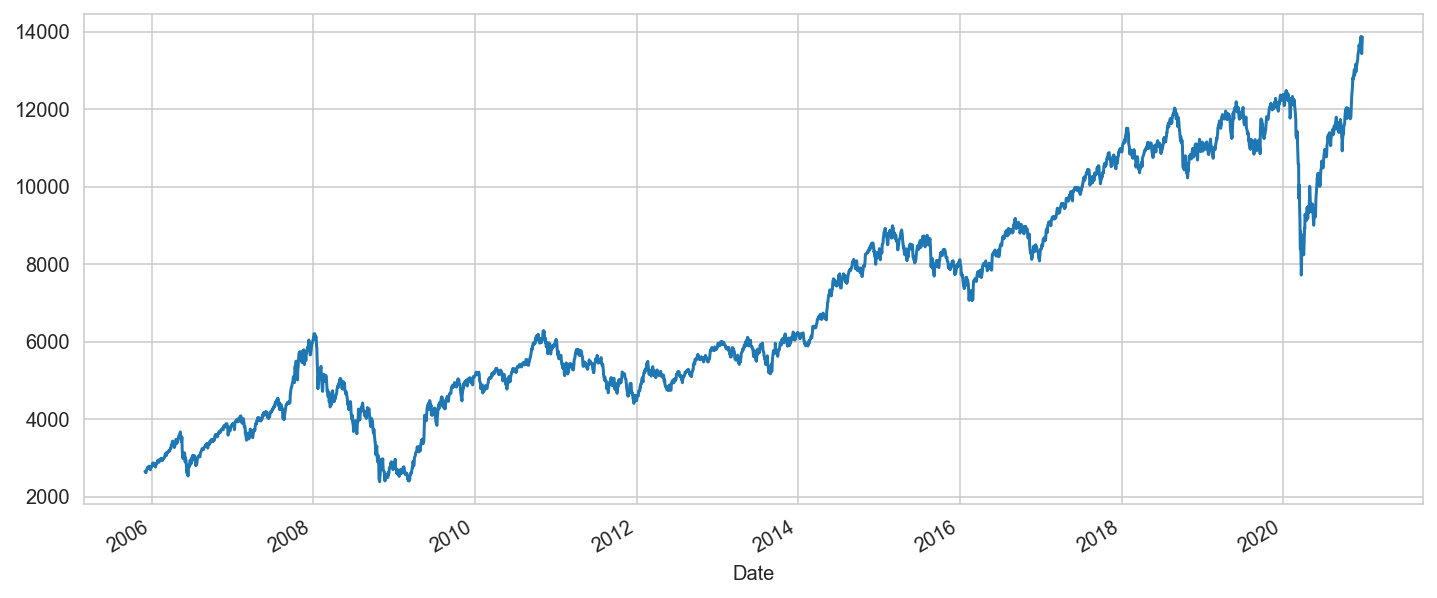

In [29]:
market.close.plot(figsize=(12,5));

In [30]:
market_ret = market.close.pct_change().dropna()
market_ret.index = market_ret.index.tz_localize('UTC')
market_ret.head()

Date
2005-12-02 00:00:00+00:00    0.000962
2005-12-05 00:00:00+00:00   -0.012291
2005-12-06 00:00:00+00:00   -0.000420
2005-12-07 00:00:00+00:00    0.010597
2005-12-08 00:00:00+00:00    0.005045
Name: close, dtype: float64

In [31]:
returns.index.name = 'Date'
returns.head()

Date
2010-01-04 00:00:00+00:00    0.0
2010-01-05 00:00:00+00:00    0.0
2010-01-06 00:00:00+00:00    0.0
2010-01-07 00:00:00+00:00    0.0
2010-01-08 00:00:00+00:00    0.0
Name: return, dtype: float64

In [32]:
ret_df= pd.DataFrame([returns, market_ret], index=None).T.dropna()
# df.index = df.index.tz_localize('UTC').dropna()
ret_df.columns = ['stra_eqw', 'market']
ret_df.head()

stra_eqw    market
Date                                         
2010-01-04 00:00:00+00:00       0.0  0.006936
2010-01-05 00:00:00+00:00       0.0  0.009751
2010-01-06 00:00:00+00:00       0.0  0.001960
2010-01-07 00:00:00+00:00       0.0 -0.004277
2010-01-08 00:00:00+00:00       0.0 -0.003072

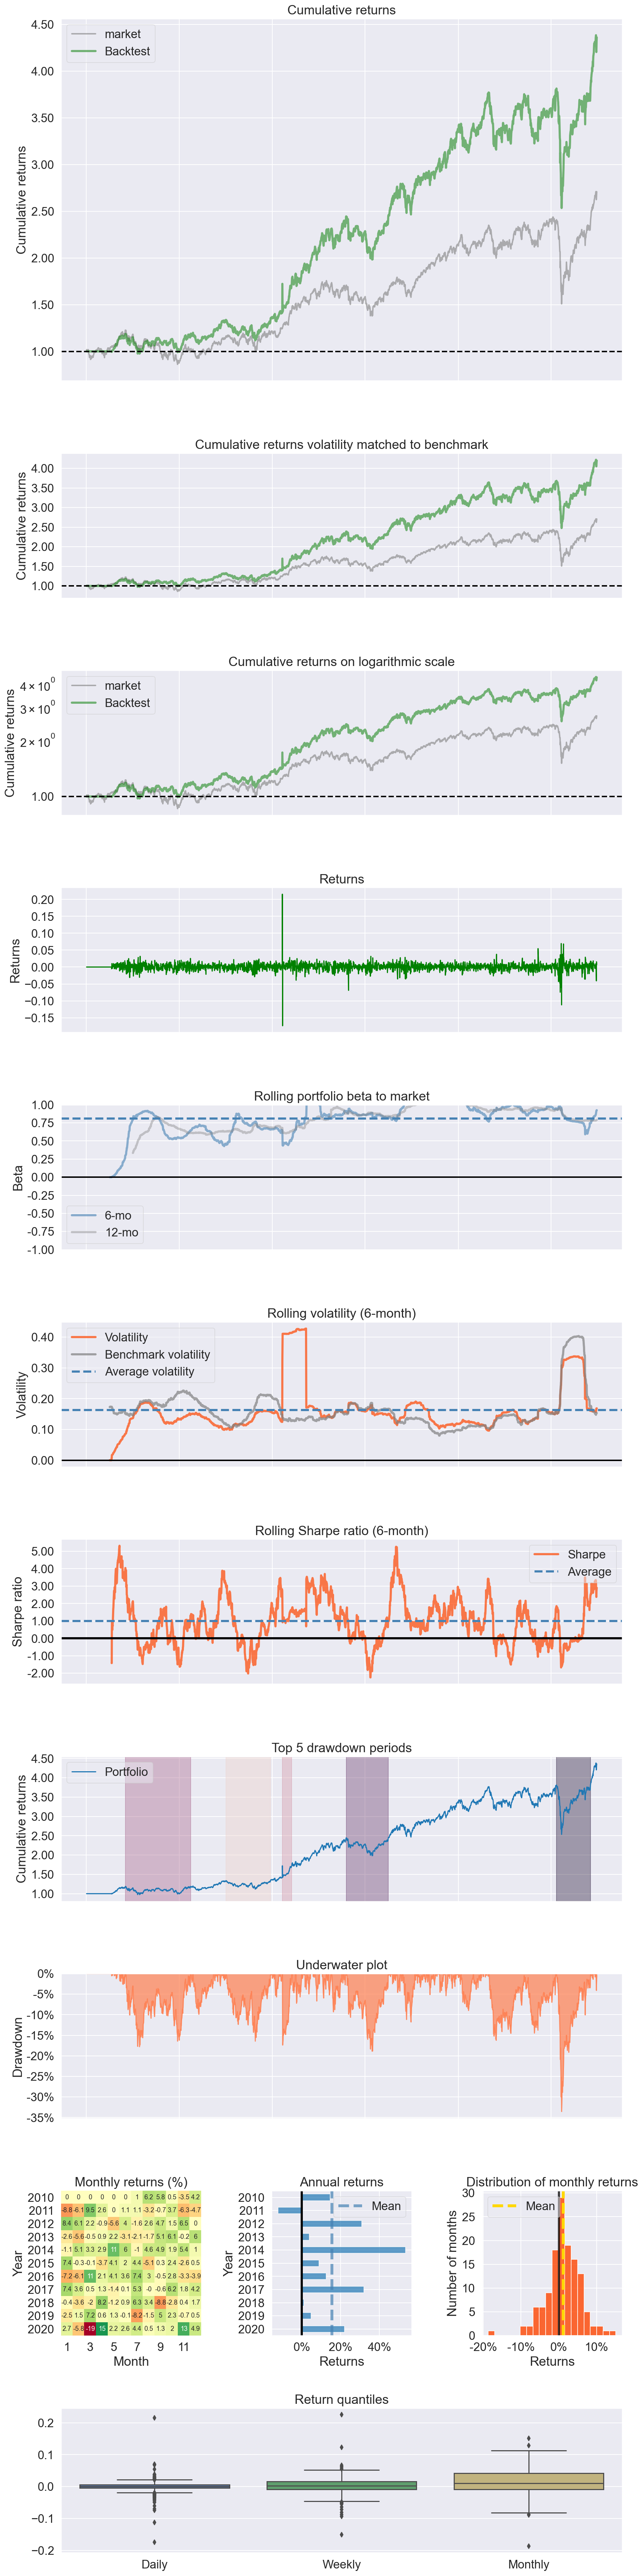

In [33]:
pf.create_returns_tear_sheet(ret_df.stra_eqw,benchmark_rets=ret_df.market)

In [34]:
DATA_STORE = 'data/mom_results.h5'

In [35]:
# with pd.HDFStore(DATA_STORE) as store:
#     store.put('nse100/eq_wts/monthly/returns', returns)
#     store.put('nse100/eq_wts/monthly/positions', positions)
#     store.put('nse100/eq_wts/monthly/transactions', transactions)

with pd.HDFStore(DATA_STORE) as store:
    store.put('nse100/eq_wts/weekly/returns', returns)
    store.put('nse100/eq_wts/weekly/positions', positions)
    store.put('nse100/eq_wts/weekly/transactions', transactions)

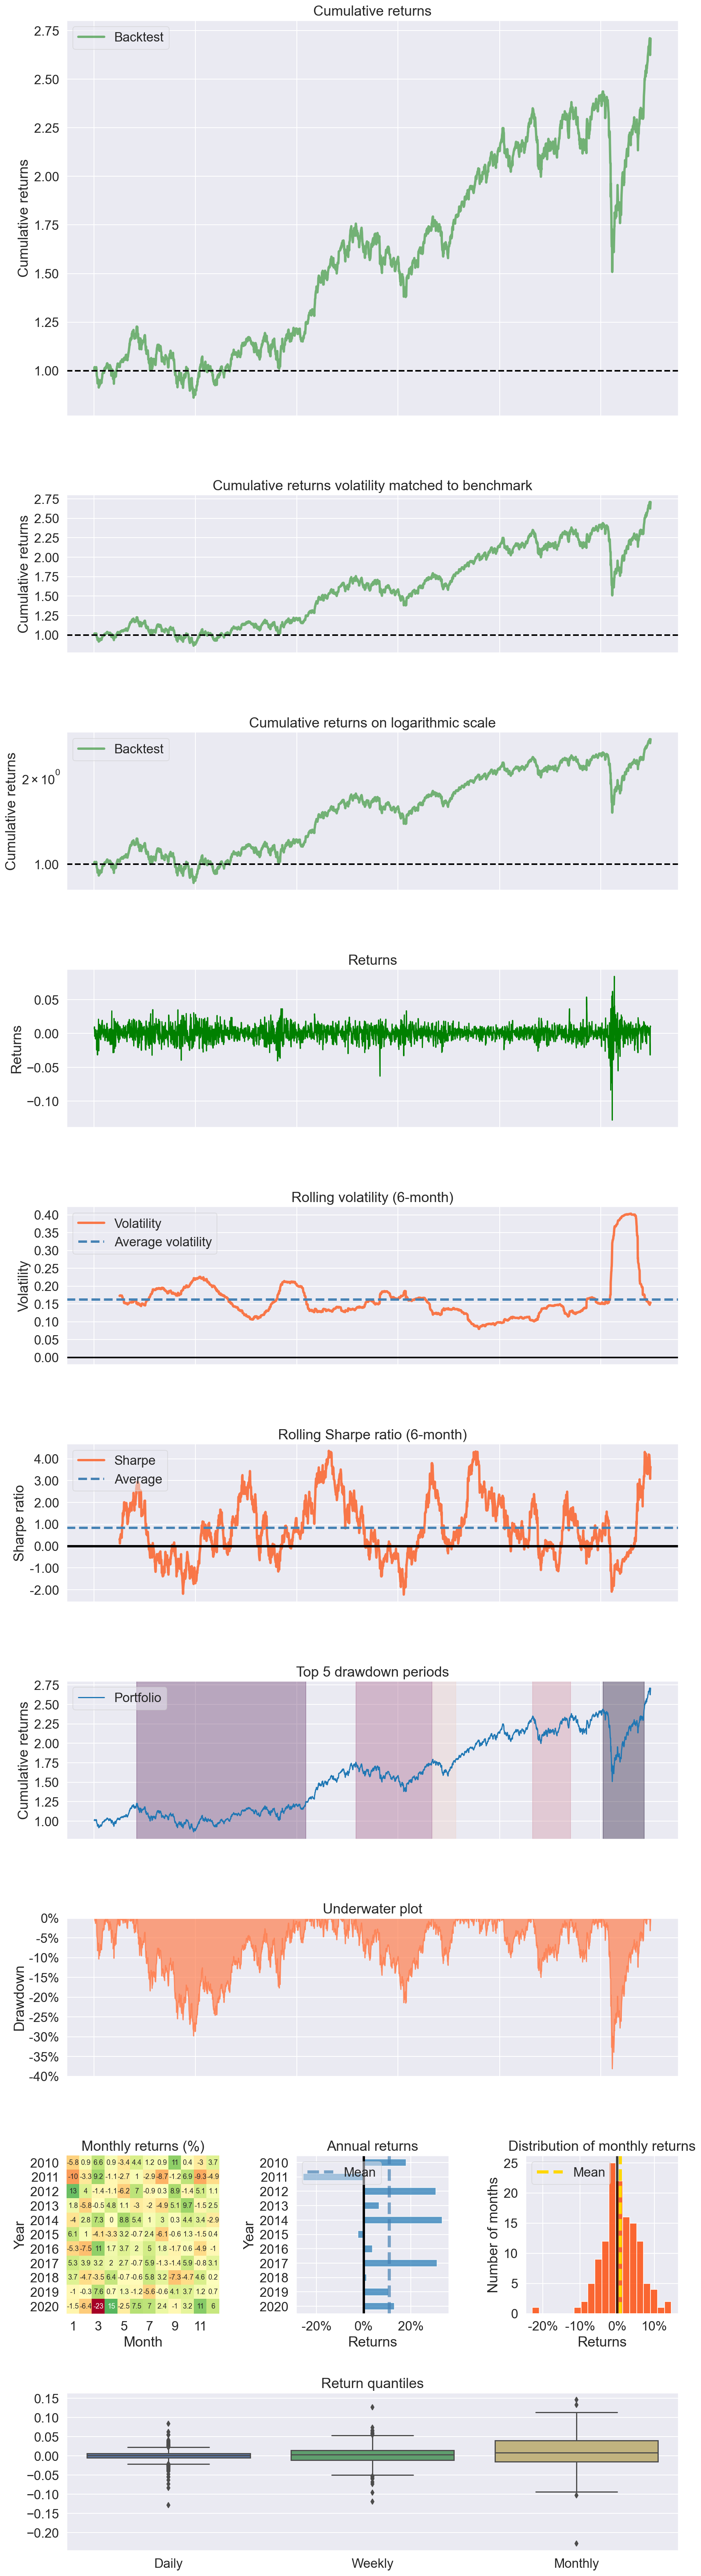

In [36]:
pf.create_returns_tear_sheet(ret_df.market)

### Momentum with Risk Parity 

In [37]:
vola_window = 21

In [38]:
# we take a 126-day time series of closing prices, 
# calculate the daily returns, and take a mean of 21 days rolling window of standards deviation.
def volatility(ts):
    std = ts.pct_change().dropna().rolling(vola_window).std().iloc[-1]
    return std

In [39]:
class StrategyRiskparity(bt.Strategy):
    params = dict(
        # parametrize the Momentum and its period
        momentum=Momentum,
        momentum_period=126,
        num_positions=30,

        # parametrize the Rebalancing period
        when=bt.timer.SESSION_START,
        timer=True,
        monthdays=[1],
        rebal_weekday=[1],  # If weekly rebalancing- Monday
        printlog=True,
        reserve=0.00  # 5% reserve capital
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function '''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            if isinstance(dt, float):
                dt = bt.num2date(dt)
            print("%s, %s" % (dt.isoformat(), txt))

    def __init__(self):
        self.add_timer(
            when=self.p.when,
#             monthdays=self.p.monthdays,
#             monthcarry=True,  # called on the 2nd day if the 1st is holiday
            weekdays=self.p.rebal_weekday,
            weekcarry=True,  # if a day isn't there, execute on the next
        )
        self.securities = self.datas
        self.inds = collections.defaultdict(dict)
        for d in self.securities:
            self.inds[d]['mom'] = self.p.momentum(d, period=self.p.momentum_period)

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def start(self):
        # Add a timer which will be called on the 1st trading day of the month
        self.add_timer(
            bt.timer.SESSION_END,  # when it will be called
#             monthdays=self.p.monthdays,  # called on the 1st day of the month
#             monthcarry=True,  # called on the 2nd day if the 1st is holiday
            weekdays=self.p.rebal_weekday,
            weekcarry=True,  # if a day isn't there, execute on the next

        )

    def notify_timer(self, timer, when, *args, **kwargs):
        if self._getminperstatus() < 0:
            self.rebalance()

    def rebalance(self):
        rankings = list(self.securities)
        rankings.sort(key=lambda s: self.inds[s]['mom'][0], reverse=True)

        # Sell stocks no longer meeting ranking filter and create list of kept positions
        kept_positions = []
        for i, d in enumerate(rankings):
            if self.getposition(d).size:
                if i > self.p.num_positions:
                    self.close(d)
                    self.log('Leave {} - Rank {:.2f}'.format(d._name, i))
                elif i < self.p.num_positions:
                    kept_positions.append(d._name)
        self.log('kept_positions - %s'% kept_positions)
        
        # Based on kept position and new ranking identify new long positions to add
        new_positions = []
        for i, d in enumerate(rankings[:self.p.num_positions]):
            if d._name not in (kept_positions):
                new_positions.append(d._name)
        self.log('new_positions - %s'% new_positions)
        
        # Calculate volatility table
        hist = pd.DataFrame()
        for d in self.securities:
            if d._name in (new_positions):
                hist[d._name] = d.close.get(size=self.p.momentum_period)
        vola_table = hist.apply(volatility)
        self.log('vola_table - %s'% vola_table)
        
        # Calculate weights based on volatility 
        inv_vola_table = 1 / vola_table 
        sum_inv_vola = np.sum(inv_vola_table)         
        vola_target_weights = inv_vola_table / sum_inv_vola
        self.log('vola_target_weights - %s'% vola_target_weights)
        
        # Buy and rebalance stocks with remaining cash
        for i, d in enumerate(rankings[:self.p.num_positions]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            if not self.getposition(d).size:
                weight = vola_target_weights[d._name]
                self.order_target_percent(d, target=weight)
                self.log('Buy {} - Rank {:.2f}'.format(d._name, i)) 

    def next(self):
        return

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,order.executed.value,order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price, order.executed.value, order.executed.comm))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
    
    def stop(self):
        self.log('| %2d | %2d |  %.2f |' %
                 (self.p.momentum_period, self.p.num_positions, self.broker.getvalue()),doprint=True)  

In [40]:
# Model Settings
startcash = 500000
momentum_period = 126 #days
num_positions = 30
reserve = 0.0
printlog=True,

# Commission and Slippage Settings
commission = 0.0025

In [41]:
cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_coc(True)
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission=commission)

In [42]:
# Add securities as datas1:
for ticker, data in prices.groupby(level=0):
    if ticker in tickers:
        print(f"Adding ticker: {ticker}")
        data = bt.feeds.PandasData(dataname=data.droplevel(level=0),
                                   name=str(ticker),
                                   fromdate=fromdate,
                                   todate=todate,
                                   plot=False)
        cerebro.adddata(data)

Adding ticker: ABOT
Adding ticker: ABUJ
Adding ticker: ACC
Adding ticker: APSE
Adding ticker: ARBN
Adding ticker: ASPN
Adding ticker: AXBK
Adding ticker: BAJA
Adding ticker: BION
Adding ticker: BJAT
Adding ticker: BJFN
Adding ticker: BJFS
Adding ticker: BOB
Adding ticker: BOSH
Adding ticker: BPCL
Adding ticker: BRGR
Adding ticker: BRIT
Adding ticker: BRTI
Adding ticker: CADI
Adding ticker: CCRI
Adding ticker: COLG
Adding ticker: DABU
Adding ticker: DIVI
Adding ticker: DLF
Adding ticker: GAIL
Adding ticker: GOCP
Adding ticker: GRAS
Adding ticker: HALC
Adding ticker: HCLT
Adding ticker: HDBK
Adding ticker: HDFC
Adding ticker: HLL
Adding ticker: HPCL
Adding ticker: HROM
Adding ticker: HVEL
Adding ticker: HZNC
Adding ticker: ICBK
Adding ticker: IGAS
Adding ticker: INBK
Adding ticker: INED
Adding ticker: INFY
Adding ticker: IOC
Adding ticker: ITC
Adding ticker: JSTL
Adding ticker: KTKM
Adding ticker: LART
Adding ticker: LUPN
Adding ticker: MAHM
Adding ticker: MOSS
Adding ticker: MRCO
Adding

In [43]:
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

cerebro.addstrategy(StrategyRiskparity,
                    momentum_period = momentum_period,
                    num_positions = num_positions,
                    printlog = printlog,
                    reserve = reserve,
                   )

0

In [44]:
%%time
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run the strategy. Results will be output from stop.
results_riskparity = cerebro.run()

# # Run over everything
# cerebro.run(maxcpus=1)

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 500000.00
2010-07-19T00:00:00, kept_positions - []
2010-07-19T00:00:00, new_positions - ['HVEL', 'DIVI', 'COLG', 'BJFN', 'TITN', 'ABOT', 'GOCP', 'CADI', 'BAJA', 'INBK', 'LUPN', 'BOB', 'UBBW', 'PIRA', 'ASPN', 'REDY', 'IGAS', 'BRGR', 'TAGL', 'DABU', 'BJAT', 'ITC', 'HDFC', 'BJFS', 'NEST', 'AXBK', 'PWFC', 'PNBK', 'SBI', 'PIDI']
2010-07-19T00:00:00, vola_table - ABOT    0.019077
ASPN    0.014649
AXBK    0.012783
BAJA    0.010340
BJAT    0.016804
BJFN    0.016643
BJFS    0.014838
BOB     0.013178
BRGR    0.019166
CADI    0.015103
COLG    0.005709
DABU    0.015776
DIVI    0.008596
GOCP    0.018676
HDFC    0.012920
HVEL    0.012319
IGAS    0.021823
INBK    0.018115
ITC     0.011214
LUPN    0.009431
NEST    0.014985
PIDI    0.017821
PIRA    0.013280
PNBK    0.012131
PWFC    0.016892
REDY    0.010727
SBI     0.011541
TAGL    0.016518
TITN    0.015234
UBBW    0.023789
dtype: float64
2010-07-19T00:00:00, vola_target_weights - ABOT    0.023528
ASPN    0.030640
AXBK    0.03

dtype: float64
2010-08-16T00:00:00, vola_target_weights - BOSH    0.195732
BRIT    0.086560
HPCL    0.165062
LART    0.236900
MAHM    0.172334
PIDI    0.143411
dtype: float64
2010-08-16T00:00:00, Buy BOSH - Rank 21.00
2010-08-16T00:00:00, Buy HPCL - Rank 23.00
2010-08-16T00:00:00, Buy BRIT - Rank 25.00
2010-08-16T00:00:00, Buy MAHM - Rank 26.00
2010-08-16T00:00:00, Buy PIDI - Rank 27.00
2010-08-16T00:00:00, Buy LART - Rank 28.00
2010-08-17T00:00:00, Order Canceled/Margin/Rejected
2010-08-17T00:00:00, Order Canceled/Margin/Rejected
2010-08-17T00:00:00, Order Canceled/Margin/Rejected
2010-08-17T00:00:00, Order Canceled/Margin/Rejected
2010-08-17T00:00:00, Order Canceled/Margin/Rejected
2010-08-17T00:00:00, Order Canceled/Margin/Rejected
2010-08-17T00:00:00, SELL EXECUTED, Price: 1354.50, Cost: 20618.50, Comm 47.41
2010-08-23T00:00:00, Leave AXBK - Rank 31.00
2010-08-23T00:00:00, Leave HDFC - Rank 32.00
2010-08-23T00:00:00, kept_positions - ['HVEL', 'DIVI', 'COLG', 'BJFN', 'TITN', 'UBBW',

2010-10-11T00:00:00, kept_positions - ['HVEL', 'UBBW', 'BJFN', 'BRGR', 'HPCL', 'TITN', 'BPCL', 'BAJA', 'IGAS', 'SBI', 'IOC', 'ASPN', 'INBK', 'BRIT', 'ITC', 'PWFC', 'BOSH', 'BOB', 'GOCP', 'BJAT']
2010-10-11T00:00:00, new_positions - ['MOSS', 'ONGC', 'PIDI', 'PLNG', 'UNSP', 'TAMO', 'MAHM', 'PNBK', 'LART', 'HDFC']
2010-10-11T00:00:00, vola_table - HDFC    0.021155
LART    0.012156
MAHM    0.015401
MOSS    0.020783
ONGC    0.010571
PIDI    0.018193
PLNG    0.019834
PNBK    0.007955
TAMO    0.017386
UNSP    0.020494
dtype: float64
2010-10-11T00:00:00, vola_target_weights - HDFC    0.070073
LART    0.121952
MAHM    0.096251
MOSS    0.071328
ONGC    0.140235
PIDI    0.081481
PLNG    0.074740
PNBK    0.186338
TAMO    0.085267
UNSP    0.072334
dtype: float64
2010-10-11T00:00:00, Buy MOSS - Rank 12.00
2010-10-11T00:00:00, Buy ONGC - Rank 17.00
2010-10-11T00:00:00, Buy PIDI - Rank 18.00
2010-10-11T00:00:00, Buy PLNG - Rank 20.00
2010-10-11T00:00:00, Buy UNSP - Rank 23.00
2010-10-11T00:00:00, Buy 

dtype: float64
2010-11-08T00:00:00, vola_target_weights - ABUJ    0.057779
ARBN    0.094105
DLF     0.075742
HALC    0.065092
HDBK    0.103775
HDFC    0.070325
HVEL    0.149713
ICBK    0.064932
KTKM    0.076829
PIDI    0.102606
TCS     0.070273
UNSP    0.068830
dtype: float64
2010-11-08T00:00:00, Buy HVEL - Rank 9.00
2010-11-08T00:00:00, Buy HALC - Rank 11.00
2010-11-08T00:00:00, Buy ICBK - Rank 14.00
2010-11-08T00:00:00, Buy ARBN - Rank 17.00
2010-11-08T00:00:00, Buy TCS - Rank 18.00
2010-11-08T00:00:00, Buy DLF - Rank 21.00
2010-11-08T00:00:00, Buy KTKM - Rank 22.00
2010-11-08T00:00:00, Buy HDFC - Rank 23.00
2010-11-08T00:00:00, Buy UNSP - Rank 25.00
2010-11-08T00:00:00, Buy PIDI - Rank 26.00
2010-11-08T00:00:00, Buy ABUJ - Rank 27.00
2010-11-08T00:00:00, Buy HDBK - Rank 29.00
2010-11-09T00:00:00, Order Canceled/Margin/Rejected
2010-11-09T00:00:00, Order Canceled/Margin/Rejected
2010-11-09T00:00:00, Order Canceled/Margin/Rejected
2010-11-09T00:00:00, Order Canceled/Margin/Rejected
20

2010-12-06T00:00:00, vola_table - ABUJ    0.023970
BJAT    0.015195
GOCP    0.012140
GRAS    0.019030
HDFC    0.015163
HVEL    0.026814
HZNC    0.018546
KTKM    0.018698
MAHM    0.025192
NEST    0.028012
SUN     0.013121
TISC    0.022934
ULTC    0.018710
dtype: float64
2010-12-06T00:00:00, vola_target_weights - ABUJ    0.059450
BJAT    0.093782
GOCP    0.117382
GRAS    0.074881
HDFC    0.093977
HVEL    0.053143
HZNC    0.076838
KTKM    0.076212
MAHM    0.056565
NEST    0.050872
SUN     0.108602
TISC    0.062134
ULTC    0.076163
dtype: float64
2010-12-06T00:00:00, Buy GRAS - Rank 15.00
2010-12-06T00:00:00, Buy SUN - Rank 16.00
2010-12-06T00:00:00, Buy BJAT - Rank 17.00
2010-12-06T00:00:00, Buy KTKM - Rank 18.00
2010-12-06T00:00:00, Buy ABUJ - Rank 19.00
2010-12-06T00:00:00, Buy MAHM - Rank 20.00
2010-12-06T00:00:00, Buy TISC - Rank 22.00
2010-12-06T00:00:00, Buy NEST - Rank 23.00
2010-12-06T00:00:00, Buy HDFC - Rank 24.00
2010-12-06T00:00:00, Buy HZNC - Rank 25.00
2010-12-06T00:00:00, B

2011-01-03T00:00:00, vola_table - ABUJ    0.021035
ACC     0.022002
BJAT    0.013361
CADI    0.020303
GAIL    0.010382
HLL     0.013951
HZNC    0.017459
INFY    0.008938
LUPN    0.020750
MAHM    0.015396
NEST    0.016631
REDY    0.013829
TISC    0.018773
dtype: float64
2011-01-03T00:00:00, vola_target_weights - ABUJ    0.055725
ACC     0.053277
BJAT    0.087734
CADI    0.057736
GAIL    0.112905
HLL     0.084022
HZNC    0.067141
INFY    0.131150
LUPN    0.056490
MAHM    0.076135
NEST    0.070481
REDY    0.084764
TISC    0.062440
dtype: float64
2011-01-03T00:00:00, Buy NEST - Rank 8.00
2011-01-03T00:00:00, Buy REDY - Rank 10.00
2011-01-03T00:00:00, Buy MAHM - Rank 11.00
2011-01-03T00:00:00, Buy ACC - Rank 13.00
2011-01-03T00:00:00, Buy LUPN - Rank 14.00
2011-01-03T00:00:00, Buy CADI - Rank 18.00
2011-01-03T00:00:00, Buy TISC - Rank 20.00
2011-01-03T00:00:00, Buy HZNC - Rank 21.00
2011-01-03T00:00:00, Buy BJAT - Rank 22.00
2011-01-03T00:00:00, Buy ABUJ - Rank 23.00
2011-01-03T00:00:00, Bu

2011-01-31T00:00:00, Leave INED - Rank 35.00
2011-01-31T00:00:00, kept_positions - ['TCS', 'SUN', 'HALC', 'ARBN', 'CADI', 'NEST', 'TAMO', 'REDY', 'PLNG', 'GRAS', 'UBBW', 'TITN', 'BION', 'ULTC']
2011-01-31T00:00:00, new_positions - ['LUPN', 'INFY', 'HZNC', 'MAHM', 'TISC', 'ACC', 'HCLT', 'HLL', 'ABOT', 'CCRI', 'GAIL', 'BOSH', 'DIVI', 'WIPR', 'PROC', 'PGRD']
2011-01-31T00:00:00, vola_table - ABOT    0.009583
ACC     0.018747
BOSH    0.016900
CCRI    0.011679
DIVI    0.015106
GAIL    0.020417
HCLT    0.018193
HLL     0.017263
HZNC    0.019655
INFY    0.018030
LUPN    0.022514
MAHM    0.022404
PGRD    0.009742
PROC    0.012867
TISC    0.017244
WIPR    0.017380
dtype: float64
2011-01-31T00:00:00, vola_target_weights - ABOT    0.102120
ACC     0.052200
BOSH    0.057907
CCRI    0.083789
DIVI    0.064782
GAIL    0.047932
HCLT    0.053792
HLL     0.056689
HZNC    0.049790
INFY    0.054277
LUPN    0.043468
MAHM    0.043680
PGRD    0.100458
PROC    0.076056
TISC    0.056752
WIPR    0.056307
dtype:

2011-02-28T00:00:00, vola_table - APSE    0.028360
AXBK    0.025656
BJFS    0.021094
BPCL    0.023675
BRIT    0.018099
CCRI    0.016155
DABU    0.019602
DIVI    0.020579
HDBK    0.017681
HPCL    0.021275
HVEL    0.029237
IOC     0.019423
NTPC    0.016763
ONGC    0.022244
PGRD    0.012196
PIRA    0.019362
PNBK    0.020693
PROC    0.023137
PWFC    0.027610
SBI     0.023421
TAGL    0.035384
UNSP    0.049569
dtype: float64
2011-02-28T00:00:00, vola_target_weights - APSE    0.034333
AXBK    0.037951
BJFS    0.046157
BPCL    0.041127
BRIT    0.053795
CCRI    0.060271
DABU    0.049672
DIVI    0.047313
HDBK    0.055067
HPCL    0.045766
HVEL    0.033303
IOC     0.050130
NTPC    0.058085
ONGC    0.043773
PGRD    0.079838
PIRA    0.050287
PNBK    0.047053
PROC    0.042084
PWFC    0.035265
SBI     0.041572
TAGL    0.027517
UNSP    0.019643
dtype: float64
2011-02-28T00:00:00, Buy PGRD - Rank 6.00
2011-02-28T00:00:00, Buy BJFS - Rank 7.00
2011-02-28T00:00:00, Buy BRIT - Rank 8.00
2011-02-28T00:00:00

dtype: float64
2011-03-21T00:00:00, vola_target_weights - ABUJ    0.059121
BJAT    0.073967
BJFN    0.051752
COLG    0.133675
HDFC    0.064116
HVEL    0.050459
ICBK    0.053516
IOC     0.068058
KTKM    0.100527
LART    0.054945
MRTI    0.051357
PROC    0.048371
SBI     0.065790
TAGL    0.039867
ULTC    0.084479
dtype: float64
2011-03-21T00:00:00, Buy MRTI - Rank 9.00
2011-03-21T00:00:00, Buy HDFC - Rank 12.00
2011-03-21T00:00:00, Buy SBI - Rank 14.00
2011-03-21T00:00:00, Buy HVEL - Rank 17.00
2011-03-21T00:00:00, Buy COLG - Rank 19.00
2011-03-21T00:00:00, Buy BJFN - Rank 20.00
2011-03-21T00:00:00, Buy ABUJ - Rank 21.00
2011-03-21T00:00:00, Buy KTKM - Rank 22.00
2011-03-21T00:00:00, Buy BJAT - Rank 23.00
2011-03-21T00:00:00, Buy IOC - Rank 24.00
2011-03-21T00:00:00, Buy TAGL - Rank 25.00
2011-03-21T00:00:00, Buy ULTC - Rank 26.00
2011-03-21T00:00:00, Buy ICBK - Rank 27.00
2011-03-21T00:00:00, Buy LART - Rank 28.00
2011-03-21T00:00:00, Buy PROC - Rank 29.00
2011-03-22T00:00:00, Order Can

2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, Order Canceled/Margin/Rejected
2011-04-13T00:00:00, SELL EXECUTED, Price: 281.97, Cost: 23742.44, Comm 64.85
2011-04-13T00:00:00, BUY EXECUTED, Price: 130.56, Cost: 33684.48, Comm 84.21
2011-04-18T00:00:00, Leave NTPC - Rank 31.00
2011-04-18T00:00:00, Leave COLG - Rank 32.00
2011-04-18T00:00:00, kept_positions - ['HCLT', 'TCS', 'HZNC', 'BRIT', 'ONGC', '

2011-05-09T00:00:00, vola_table - ARBN    0.018435
BION    0.017689
BJFS    0.017269
DLF     0.020914
GOCP    0.019633
HPCL    0.022053
JSTL    0.020272
LART    0.017313
LUPN    0.015229
PGRD    0.009709
PWFC    0.020552
REDY    0.016404
TAGL    0.016137
UNSP    0.015093
dtype: float64
2011-05-09T00:00:00, vola_target_weights - ARBN    0.065644
BION    0.068410
BJFS    0.070074
DLF     0.057862
GOCP    0.061636
HPCL    0.054873
JSTL    0.059693
LART    0.069896
LUPN    0.079461
PGRD    0.124636
PWFC    0.058881
REDY    0.073768
TAGL    0.074989
UNSP    0.080177
dtype: float64
2011-05-09T00:00:00, Buy LUPN - Rank 8.00
2011-05-09T00:00:00, Buy LART - Rank 10.00
2011-05-09T00:00:00, Buy UNSP - Rank 11.00
2011-05-09T00:00:00, Buy TAGL - Rank 13.00
2011-05-09T00:00:00, Buy BJFS - Rank 14.00
2011-05-09T00:00:00, Buy PWFC - Rank 16.00
2011-05-09T00:00:00, Buy REDY - Rank 17.00
2011-05-09T00:00:00, Buy ARBN - Rank 20.00
2011-05-09T00:00:00, Buy JSTL - Rank 22.00
2011-05-09T00:00:00, Buy DLF - 

2011-05-30T00:00:00, Buy BOSH - Rank 22.00
2011-05-30T00:00:00, Buy ARBN - Rank 24.00
2011-05-30T00:00:00, Buy HALC - Rank 25.00
2011-05-30T00:00:00, Buy TISC - Rank 26.00
2011-05-30T00:00:00, Buy TAGL - Rank 27.00
2011-05-30T00:00:00, Buy JSTL - Rank 28.00
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, Order Canceled/Margin/Rejected
2011-05-31T00:00:00, SELL EXECUTED, Price: 762.45, Cost: 27898.70,

dtype: float64
2011-06-27T00:00:00, vola_target_weights - ASPN    0.051479
BRIT    0.046378
BRTI    0.064449
COLG    0.088677
DABU    0.045264
HALC    0.054019
HDBK    0.068400
HVEL    0.036504
INBK    0.059364
INFY    0.078204
NEST    0.080716
PIDI    0.050566
PIRA    0.091299
PLNG    0.052255
TISC    0.054823
UNSP    0.077603
dtype: float64
2011-06-27T00:00:00, Buy BRTI - Rank 10.00
2011-06-27T00:00:00, Buy COLG - Rank 12.00
2011-06-27T00:00:00, Buy DABU - Rank 13.00
2011-06-27T00:00:00, Buy PIDI - Rank 14.00
2011-06-27T00:00:00, Buy NEST - Rank 15.00
2011-06-27T00:00:00, Buy PLNG - Rank 16.00
2011-06-27T00:00:00, Buy TISC - Rank 17.00
2011-06-27T00:00:00, Buy INFY - Rank 19.00
2011-06-27T00:00:00, Buy HDBK - Rank 21.00
2011-06-27T00:00:00, Buy HVEL - Rank 23.00
2011-06-27T00:00:00, Buy HALC - Rank 24.00
2011-06-27T00:00:00, Buy PIRA - Rank 25.00
2011-06-27T00:00:00, Buy ASPN - Rank 26.00
2011-06-27T00:00:00, Buy UNSP - Rank 27.00
2011-06-27T00:00:00, Buy BRIT - Rank 28.00
2011-06-27

2011-08-01T00:00:00, Leave UBBW - Rank 34.00
2011-08-01T00:00:00, kept_positions - ['TITN', 'DIVI', 'BRIT', 'ASPN', 'INED', 'ITC', 'MRCO', 'BRTI', 'COLG', 'BOSH', 'CADI', 'MOSS', 'PROC', 'ABOT']
2011-08-01T00:00:00, new_positions - ['IGAS', 'BRGR', 'PIDI', 'GOCP', 'NEST', 'PLNG', 'HLL', 'HROM', 'DABU', 'SUN', 'HDBK', 'HPCL', 'LUPN', 'BPCL', 'INBK', 'KTKM']
2011-08-01T00:00:00, vola_table - BPCL    0.009082
BRGR    0.017914
DABU    0.015502
GOCP    0.013126
HDBK    0.012120
HLL     0.007510
HPCL    0.014448
HROM    0.012437
IGAS    0.014568
INBK    0.015910
KTKM    0.021203
LUPN    0.017795
NEST    0.017429
PIDI    0.017432
PLNG    0.026662
SUN     0.011594
dtype: float64
2011-08-01T00:00:00, vola_target_weights - BPCL    0.096141
BRGR    0.048741
DABU    0.056327
GOCP    0.066524
HDBK    0.072042
HLL     0.116264
HPCL    0.060434
HROM    0.070207
IGAS    0.059937
INBK    0.054883
KTKM    0.041181
LUPN    0.049069
NEST    0.050098
PIDI    0.050091
PLNG    0.032749
SUN     0.075311
dtype

2011-09-05T00:00:00, vola_table - BPCL    0.014167
BRGR    0.018469
CCRI    0.014508
DABU    0.017213
GOCP    0.016250
GRAS    0.016085
HLL     0.007626
HPCL    0.016755
HROM    0.020515
INFY    0.028586
LUPN    0.021570
NEST    0.013375
NMDC    0.025868
PIDI    0.015783
PIRA    0.021179
RELI    0.023261
SUN     0.019615
dtype: float64
2011-09-05T00:00:00, vola_target_weights - BPCL    0.069587
BRGR    0.053379
CCRI    0.067953
DABU    0.057276
GOCP    0.060670
GRAS    0.061289
HLL     0.129281
HPCL    0.058839
HROM    0.048057
INFY    0.034488
LUPN    0.045706
NEST    0.073710
NMDC    0.038112
PIDI    0.062462
PIRA    0.046549
RELI    0.042382
SUN     0.050260
dtype: float64
2011-09-05T00:00:00, Buy PIDI - Rank 6.00
2011-09-05T00:00:00, Buy BPCL - Rank 7.00
2011-09-05T00:00:00, Buy HLL - Rank 8.00
2011-09-05T00:00:00, Buy HROM - Rank 9.00
2011-09-05T00:00:00, Buy GOCP - Rank 11.00
2011-09-05T00:00:00, Buy NEST - Rank 13.00
2011-09-05T00:00:00, Buy LUPN - Rank 15.00
2011-09-05T00:00:00

2011-10-03T00:00:00, Leave TITN - Rank 43.00
2011-10-03T00:00:00, kept_positions - ['IGAS', 'PLNG', 'BRIT', 'HROM', 'ASPN', 'HLL', 'COLG', 'BOSH', 'BPCL', 'PIDI', 'ITC', 'MRCO', 'BRTI']
2011-10-03T00:00:00, new_positions - ['LUPN', 'NEST', 'BAJA', 'REDY', 'GOCP', 'MRTI', 'BJAT', 'SUN', 'NMDC', 'RELI', 'BRGR', 'ICBK', 'CCRI', 'SHCM', 'TCS', 'PIRA', 'INFY']
2011-10-03T00:00:00, vola_table - BAJA    0.017966
BJAT    0.008481
BRGR    0.017689
CCRI    0.023387
GOCP    0.009869
ICBK    0.024396
INFY    0.025133
LUPN    0.015909
MRTI    0.021084
NEST    0.011310
NMDC    0.030422
PIRA    0.018920
REDY    0.011803
RELI    0.026857
SHCM    0.020956
SUN     0.013487
TCS     0.021791
dtype: float64
2011-10-03T00:00:00, vola_target_weights - BAJA    0.054087
BJAT    0.114571
BRGR    0.054934
CCRI    0.041549
GOCP    0.098464
ICBK    0.039831
INFY    0.038663
LUPN    0.061080
MRTI    0.046087
NEST    0.085913
NMDC    0.031941
PIRA    0.051358
REDY    0.082329
RELI    0.036181
SHCM    0.046369
SUN   

2011-10-24T00:00:00, new_positions - ['MAHM', 'BJAT', 'MRTI', 'REDY', 'RELI', 'ICBK', 'CCRI', 'UPLL', 'ULTC', 'WIPR', 'BOB', 'UNSP', 'NMDC', 'IOC', 'CADI', 'PIRA', 'HCLT', 'HVEL']
2011-10-24T00:00:00, vola_table - BJAT    0.012393
BOB     0.016801
CADI    0.012924
CCRI    0.025964
HCLT    0.027990
HVEL    0.017553
ICBK    0.028305
IOC     0.013061
MAHM    0.016356
MRTI    0.021038
NMDC    0.029062
PIRA    0.008001
REDY    0.010885
RELI    0.023900
ULTC    0.012715
UNSP    0.029447
UPLL    0.026374
WIPR    0.022076
dtype: float64
2011-10-24T00:00:00, vola_target_weights - BJAT    0.076246
BOB     0.056242
CADI    0.073114
CCRI    0.036393
HCLT    0.033759
HVEL    0.053832
ICBK    0.033383
IOC     0.072344
MAHM    0.057773
MRTI    0.044914
NMDC    0.032514
PIRA    0.118105
REDY    0.086809
RELI    0.039536
ULTC    0.074315
UNSP    0.032089
UPLL    0.035827
WIPR    0.042803
dtype: float64
2011-10-24T00:00:00, Buy MAHM - Rank 4.00
2011-10-24T00:00:00, Buy BJAT - Rank 10.00
2011-10-24T00:00

dtype: float64
2011-11-14T00:00:00, vola_target_weights - BJAT    0.134766
BOB     0.054891
CADI    0.074497
CCRI    0.113272
HZNC    0.054954
ICBK    0.040484
IOC     0.071915
KTKM    0.058534
MOSS    0.043770
MRTI    0.054568
NMDC    0.054591
SBI     0.039994
TISC    0.038055
UBBW    0.032314
UNSP    0.030386
UPLL    0.047184
WIPR    0.055826
dtype: float64
2011-11-14T00:00:00, Buy CADI - Rank 12.00
2011-11-14T00:00:00, Buy MRTI - Rank 13.00
2011-11-14T00:00:00, Buy KTKM - Rank 14.00
2011-11-14T00:00:00, Buy IOC - Rank 15.00
2011-11-14T00:00:00, Buy ICBK - Rank 16.00
2011-11-14T00:00:00, Buy UNSP - Rank 17.00
2011-11-14T00:00:00, Buy UPLL - Rank 18.00
2011-11-14T00:00:00, Buy BJAT - Rank 19.00
2011-11-14T00:00:00, Buy CCRI - Rank 21.00
2011-11-14T00:00:00, Buy SBI - Rank 22.00
2011-11-14T00:00:00, Buy HZNC - Rank 23.00
2011-11-14T00:00:00, Buy UBBW - Rank 24.00
2011-11-14T00:00:00, Buy BOB - Rank 25.00
2011-11-14T00:00:00, Buy WIPR - Rank 26.00
2011-11-14T00:00:00, Buy NMDC - Rank 27

dtype: float64
2011-12-12T00:00:00, vola_target_weights - AXBK    0.049520
BJAT    0.109758
BOB     0.052956
CCRI    0.061235
GAIL    0.072613
GOCP    0.081558
HPCL    0.039358
HZNC    0.048457
ICBK    0.039145
INED    0.063236
LART    0.050275
PNBK    0.057781
SHCM    0.090507
SIEM    0.054369
TEML    0.056986
UNSP    0.030728
UPLL    0.041516
dtype: float64
2011-12-12T00:00:00, Buy SHCM - Rank 6.00
2011-12-12T00:00:00, Buy INED - Rank 10.00
2011-12-12T00:00:00, Buy GAIL - Rank 13.00
2011-12-12T00:00:00, Buy PNBK - Rank 16.00
2011-12-12T00:00:00, Buy BOB - Rank 17.00
2011-12-12T00:00:00, Buy GOCP - Rank 18.00
2011-12-12T00:00:00, Buy HZNC - Rank 19.00
2011-12-12T00:00:00, Buy BJAT - Rank 20.00
2011-12-12T00:00:00, Buy CCRI - Rank 21.00
2011-12-12T00:00:00, Buy SIEM - Rank 22.00
2011-12-12T00:00:00, Buy ICBK - Rank 23.00
2011-12-12T00:00:00, Buy UPLL - Rank 24.00
2011-12-12T00:00:00, Buy AXBK - Rank 25.00
2011-12-12T00:00:00, Buy LART - Rank 26.00
2011-12-12T00:00:00, Buy UNSP - Rank 2

2012-01-09T00:00:00, kept_positions - ['ABUJ', 'HLL', 'SHCM', 'ACC', 'ULTC', 'GRAS', 'GOCP', 'GAIL', 'BAJA', 'DABU', 'IOC', 'CADI', 'INED', 'MRTI']
2012-01-09T00:00:00, new_positions - ['BJAT', 'PIDI', 'ASPN', 'UPLL', 'NTPC', 'HDBK', 'BOB', 'PNBK', 'MRCO', 'BRTI', 'BOSH', 'CCRI', 'SIEM', 'TEML', 'HVEL', 'SBI']
2012-01-09T00:00:00, vola_table - ASPN    0.015620
BJAT    0.020560
BOB     0.024951
BOSH    0.012516
BRTI    0.026349
CCRI    0.014377
HDBK    0.019926
HVEL    0.024582
MRCO    0.013255
NTPC    0.020206
PIDI    0.018753
PNBK    0.024823
SBI     0.021341
SIEM    0.019355
TEML    0.015315
UPLL    0.014478
dtype: float64
2012-01-09T00:00:00, vola_target_weights - ASPN    0.072548
BJAT    0.055119
BOB     0.045417
BOSH    0.090542
BRTI    0.043008
CCRI    0.078821
HDBK    0.056872
HVEL    0.046099
MRCO    0.085492
NTPC    0.056084
PIDI    0.060429
PNBK    0.045652
SBI     0.053101
SIEM    0.058549
TEML    0.073994
UPLL    0.078272
dtype: float64
2012-01-09T00:00:00, Buy BJAT - Rank 

2012-02-06T00:00:00, vola_table - ASPN    0.013274
BION    0.026327
BJFS    0.026420
BPCL    0.022487
BRTI    0.024992
IGAS    0.031491
INFY    0.021762
MOSS    0.029493
PIDI    0.017868
PIRA    0.013652
REDY    0.014869
SIEM    0.017461
SUN     0.014078
TAMO    0.018220
TCS     0.016156
TITN    0.021103
dtype: float64
2012-02-06T00:00:00, vola_target_weights - ASPN    0.090089
BION    0.045425
BJFS    0.045265
BPCL    0.053182
BRTI    0.047850
IGAS    0.037975
INFY    0.054952
MOSS    0.040548
PIDI    0.066929
PIRA    0.087597
REDY    0.080429
SIEM    0.068488
SUN     0.084949
TAMO    0.065635
TCS     0.074019
TITN    0.056669
dtype: float64
2012-02-06T00:00:00, Buy TAMO - Rank 2.00
2012-02-06T00:00:00, Buy TCS - Rank 9.00
2012-02-06T00:00:00, Buy REDY - Rank 10.00
2012-02-06T00:00:00, Buy INFY - Rank 11.00
2012-02-06T00:00:00, Buy SUN - Rank 12.00
2012-02-06T00:00:00, Buy PIRA - Rank 13.00
2012-02-06T00:00:00, Buy PIDI - Rank 17.00
2012-02-06T00:00:00, Buy ASPN - Rank 21.00
2012-02-0

dtype: float64
2012-03-05T00:00:00, vola_target_weights - BION    0.051303
BJFN    0.054356
HCLT    0.099854
IGAS    0.038953
INBK    0.039893
INFY    0.094354
KTKM    0.063470
MAHM    0.050587
ORCL    0.026225
PGRD    0.082567
PIDI    0.060376
PWFC    0.030045
REDY    0.115410
SUN     0.084670
TAGL    0.029869
UBBW    0.078068
dtype: float64
2012-03-05T00:00:00, Buy SUN - Rank 8.00
2012-03-05T00:00:00, Buy REDY - Rank 10.00
2012-03-05T00:00:00, Buy TAGL - Rank 12.00
2012-03-05T00:00:00, Buy INFY - Rank 14.00
2012-03-05T00:00:00, Buy PGRD - Rank 15.00
2012-03-05T00:00:00, Buy BJFN - Rank 16.00
2012-03-05T00:00:00, Buy PWFC - Rank 17.00
2012-03-05T00:00:00, Buy HCLT - Rank 18.00
2012-03-05T00:00:00, Buy KTKM - Rank 20.00
2012-03-05T00:00:00, Buy IGAS - Rank 22.00
2012-03-05T00:00:00, Buy ORCL - Rank 23.00
2012-03-05T00:00:00, Buy PIDI - Rank 24.00
2012-03-05T00:00:00, Buy INBK - Rank 25.00
2012-03-05T00:00:00, Buy UBBW - Rank 26.00
2012-03-05T00:00:00, Buy BION - Rank 27.00
2012-03-05T0

2012-04-09T00:00:00, vola_table - BOSH    0.021167
BRIT    0.016375
GOCP    0.015681
HCLT    0.017270
HDBK    0.015297
HZNC    0.023232
INBK    0.022475
KTKM    0.022457
MRCO    0.012616
MRTI    0.016617
ORCL    0.016444
PGRD    0.013849
REDY    0.012399
SBI     0.022741
TEML    0.027893
dtype: float64
2012-04-09T00:00:00, vola_target_weights - BOSH    0.054910
BRIT    0.070980
GOCP    0.074123
HCLT    0.067300
HDBK    0.075982
HZNC    0.050029
INBK    0.051715
KTKM    0.051756
MRCO    0.092126
MRTI    0.069945
ORCL    0.070683
PGRD    0.083926
REDY    0.093744
SBI     0.051110
TEML    0.041670
dtype: float64
2012-04-09T00:00:00, Buy BRIT - Rank 12.00
2012-04-09T00:00:00, Buy MRTI - Rank 13.00
2012-04-09T00:00:00, Buy HCLT - Rank 14.00
2012-04-09T00:00:00, Buy INBK - Rank 15.00
2012-04-09T00:00:00, Buy REDY - Rank 18.00
2012-04-09T00:00:00, Buy ORCL - Rank 19.00
2012-04-09T00:00:00, Buy BOSH - Rank 20.00
2012-04-09T00:00:00, Buy SBI - Rank 21.00
2012-04-09T00:00:00, Buy GOCP - Rank 22.

2012-05-07T00:00:00, Leave WIPR - Rank 33.00
2012-05-07T00:00:00, Leave JSTL - Rank 34.00
2012-05-07T00:00:00, kept_positions - ['TAMO', 'SHCM', 'HVEL', 'BJFS', 'TAGL', 'BJFN', 'MRTI', 'UBBW', 'ULTC', 'PIRA', 'ORCL', 'BOSH', 'SUN', 'BRIT']
2012-05-07T00:00:00, new_positions - ['GOCP', 'INBK', 'HCLT', 'BPCL', 'MRCO', 'HDBK', 'ARBN', 'SBI', 'KTKM', 'LUPN', 'TEML', 'TITN', 'REDY', 'ITC', 'DABU', 'MOSS']
2012-05-07T00:00:00, vola_table - ARBN    0.028287
BPCL    0.019782
DABU    0.016456
GOCP    0.017089
HCLT    0.016815
HDBK    0.012138
INBK    0.018391
ITC     0.012950
KTKM    0.018483
LUPN    0.015301
MOSS    0.015019
MRCO    0.009923
REDY    0.013770
SBI     0.019168
TEML    0.014067
TITN    0.018917
dtype: float64
2012-05-07T00:00:00, vola_target_weights - ARBN    0.034857
BPCL    0.049843
DABU    0.059918
GOCP    0.057696
HCLT    0.058637
HDBK    0.081234
INBK    0.053614
ITC     0.076140
KTKM    0.053346
LUPN    0.064442
MOSS    0.065650
MRCO    0.099369
REDY    0.071603
SBI     0.0

2012-06-04T00:00:00, kept_positions - ['BJFS', 'GOCP', 'TAMO', 'BPCL', 'BOSH', 'BJFN', 'HVEL', 'ORCL', 'SHCM', 'SUN', 'BRIT', 'UBBW', 'INBK', 'ULTC', 'MRTI']
2012-06-04T00:00:00, new_positions - ['BRGR', 'ASPN', 'TITN', 'LUPN', 'MRCO', 'PROC', 'COLG', 'INED', 'HCLT', 'ITC', 'PIDI', 'KTKM', 'NEST', 'BJAT', 'ARBN']
2012-06-04T00:00:00, vola_table - ARBN    0.033741
ASPN    0.022435
BJAT    0.015851
BRGR    0.032642
COLG    0.016532
HCLT    0.017157
INED    0.017332
ITC     0.021413
KTKM    0.022144
LUPN    0.017579
MRCO    0.019164
NEST    0.013886
PIDI    0.015869
PROC    0.019960
TITN    0.022301
dtype: float64
2012-06-04T00:00:00, vola_target_weights - ARBN    0.038227
ASPN    0.057491
BJAT    0.081369
BRGR    0.039514
COLG    0.078021
HCLT    0.075178
INED    0.074419
ITC     0.060234
KTKM    0.058247
LUPN    0.073371
MRCO    0.067304
NEST    0.092886
PIDI    0.081280
PROC    0.064621
TITN    0.057837
dtype: float64
2012-06-04T00:00:00, Buy BRGR - Rank 2.00
2012-06-04T00:00:00, Buy A

2012-07-02T00:00:00, vola_table - CADI    0.013147
COLG    0.015688
DABU    0.017296
DIVI    0.016631
HCLT    0.019596
HLL     0.015433
HPCL    0.022138
KTKM    0.016828
LUPN    0.014428
MRCO    0.013976
NEST    0.008611
PIDI    0.014900
PIRA    0.019388
TITN    0.019517
dtype: float64
2012-07-02T00:00:00, vola_target_weights - CADI    0.084041
COLG    0.070427
DABU    0.063880
DIVI    0.066432
HCLT    0.056383
HLL     0.071591
HPCL    0.049908
KTKM    0.065656
LUPN    0.076577
MRCO    0.079052
NEST    0.128302
PIDI    0.074152
PIRA    0.056987
TITN    0.056611
dtype: float64
2012-07-02T00:00:00, Buy COLG - Rank 10.00
2012-07-02T00:00:00, Buy DIVI - Rank 11.00
2012-07-02T00:00:00, Buy LUPN - Rank 12.00
2012-07-02T00:00:00, Buy PIDI - Rank 13.00
2012-07-02T00:00:00, Buy MRCO - Rank 14.00
2012-07-02T00:00:00, Buy HLL - Rank 16.00
2012-07-02T00:00:00, Buy HPCL - Rank 18.00
2012-07-02T00:00:00, Buy CADI - Rank 19.00
2012-07-02T00:00:00, Buy DABU - Rank 21.00
2012-07-02T00:00:00, Buy KTKM -

dtype: float64
2012-08-06T00:00:00, vola_target_weights - APSE    0.063752
BAJA    0.067215
BRTI    0.064866
HDBK    0.097652
HPCL    0.069963
HZNC    0.071036
INFY    0.053560
LUPN    0.075663
PIRA    0.105351
SIEM    0.084689
TEML    0.079448
TISC    0.060367
UNSP    0.036719
WIPR    0.069718
dtype: float64
2012-08-06T00:00:00, Buy HPCL - Rank 12.00
2012-08-06T00:00:00, Buy LUPN - Rank 15.00
2012-08-06T00:00:00, Buy PIRA - Rank 18.00
2012-08-06T00:00:00, Buy UNSP - Rank 19.00
2012-08-06T00:00:00, Buy HDBK - Rank 20.00
2012-08-06T00:00:00, Buy HZNC - Rank 21.00
2012-08-06T00:00:00, Buy WIPR - Rank 22.00
2012-08-06T00:00:00, Buy BAJA - Rank 23.00
2012-08-06T00:00:00, Buy SIEM - Rank 24.00
2012-08-06T00:00:00, Buy BRTI - Rank 25.00
2012-08-06T00:00:00, Buy APSE - Rank 26.00
2012-08-06T00:00:00, Buy INFY - Rank 27.00
2012-08-06T00:00:00, Buy TISC - Rank 28.00
2012-08-06T00:00:00, Buy TEML - Rank 29.00
2012-08-07T00:00:00, Order Canceled/Margin/Rejected
2012-08-07T00:00:00, Order Canceled

2012-09-03T00:00:00, Buy ULTC - Rank 16.00
2012-09-03T00:00:00, Buy TEML - Rank 17.00
2012-09-03T00:00:00, Buy HPCL - Rank 18.00
2012-09-03T00:00:00, Buy PIRA - Rank 19.00
2012-09-03T00:00:00, Buy TCS - Rank 20.00
2012-09-03T00:00:00, Buy NMDC - Rank 22.00
2012-09-03T00:00:00, Buy BRIT - Rank 23.00
2012-09-03T00:00:00, Buy WIPR - Rank 24.00
2012-09-03T00:00:00, Buy SIEM - Rank 25.00
2012-09-03T00:00:00, Buy ABUJ - Rank 27.00
2012-09-03T00:00:00, Buy PGRD - Rank 28.00
2012-09-03T00:00:00, Buy TISC - Rank 29.00
2012-09-04T00:00:00, Order Canceled/Margin/Rejected
2012-09-04T00:00:00, Order Canceled/Margin/Rejected
2012-09-04T00:00:00, Order Canceled/Margin/Rejected
2012-09-04T00:00:00, Order Canceled/Margin/Rejected
2012-09-04T00:00:00, Order Canceled/Margin/Rejected
2012-09-04T00:00:00, Order Canceled/Margin/Rejected
2012-09-04T00:00:00, Order Canceled/Margin/Rejected
2012-09-04T00:00:00, Order Canceled/Margin/Rejected
2012-09-04T00:00:00, Order Canceled/Margin/Rejected
2012-09-04T00:00:

dtype: float64
2012-10-01T00:00:00, vola_target_weights - ABUJ    0.058178
BION    0.061023
GRAS    0.081377
HCLT    0.084695
HDFC    0.072977
ICBK    0.045795
LART    0.049648
MAHM    0.078348
NMDC    0.054540
PGRD    0.073426
SHCM    0.068076
TAGL    0.045993
TCS     0.063689
TEML    0.066498
UBBW    0.024395
ULTC    0.071340
dtype: float64
2012-10-01T00:00:00, Buy ULTC - Rank 5.00
2012-10-01T00:00:00, Buy ABUJ - Rank 7.00
2012-10-01T00:00:00, Buy TEML - Rank 9.00
2012-10-01T00:00:00, Buy GRAS - Rank 11.00
2012-10-01T00:00:00, Buy NMDC - Rank 14.00
2012-10-01T00:00:00, Buy LART - Rank 16.00
2012-10-01T00:00:00, Buy ICBK - Rank 17.00
2012-10-01T00:00:00, Buy SHCM - Rank 18.00
2012-10-01T00:00:00, Buy TCS - Rank 19.00
2012-10-01T00:00:00, Buy PGRD - Rank 21.00
2012-10-01T00:00:00, Buy TAGL - Rank 22.00
2012-10-01T00:00:00, Buy MAHM - Rank 23.00
2012-10-01T00:00:00, Buy HDFC - Rank 24.00
2012-10-01T00:00:00, Buy UBBW - Rank 26.00
2012-10-01T00:00:00, Buy HCLT - Rank 27.00
2012-10-01T00:

2012-10-29T00:00:00, kept_positions - ['UNSP', 'SHCM', 'ULTC', 'BJFN', 'HLL', 'GOCP', 'DABU', 'DIVI', 'SUN', 'HDBK', 'ITC', 'MRCO', 'BJFS']
2012-10-29T00:00:00, new_positions - ['TEML', 'GRAS', 'ABUJ', 'TAGL', 'LART', 'UBBW', 'ICBK', 'PLNG', 'MAHM', 'MOSS', 'ACC', 'BION', 'HDFC', 'ORCL', 'HCLT', 'RELI', 'GAIL']
2012-10-29T00:00:00, vola_table - ABUJ    0.017980
ACC     0.014499
BION    0.018100
GAIL    0.011652
GRAS    0.011591
HCLT    0.014616
HDFC    0.014826
ICBK    0.011797
LART    0.015602
MAHM    0.015966
MOSS    0.023391
ORCL    0.011727
PLNG    0.012319
RELI    0.013961
TAGL    0.028983
TEML    0.020805
UBBW    0.030434
dtype: float64
2012-10-29T00:00:00, vola_target_weights - ABUJ    0.050766
ACC     0.062955
BION    0.050431
GAIL    0.078336
GRAS    0.078748
HCLT    0.062452
HDFC    0.061565
ICBK    0.077371
LART    0.058503
MAHM    0.057169
MOSS    0.039024
ORCL    0.077837
PLNG    0.074098
RELI    0.065383
TAGL    0.031494
TEML    0.043873
UBBW    0.029992
dtype: float64
20

2012-12-03T00:00:00, Leave DABU - Rank 32.00
2012-12-03T00:00:00, kept_positions - ['UNSP', 'SHCM', 'UBBW', 'BJFN', 'ULTC', 'TEML', 'GOCP', 'BJFS', 'HLL', 'MRCO', 'HDBK', 'ITC', 'SUN']
2012-12-03T00:00:00, new_positions - ['ARBN', 'MOSS', 'TAGL', 'GRAS', 'MAHM', 'HCLT', 'MRTI', 'TITN', 'ABUJ', 'BION', 'HDFC', 'ICBK', 'BAJA', 'PIDI', 'LART', 'PLNG', 'ACC']
2012-12-03T00:00:00, vola_table - ABUJ    0.014828
ACC     0.013782
ARBN    0.028058
BAJA    0.016098
BION    0.024674
GRAS    0.013643
HCLT    0.011254
HDFC    0.014820
ICBK    0.015811
LART    0.012338
MAHM    0.013584
MOSS    0.019107
MRTI    0.012242
PIDI    0.016880
PLNG    0.015410
TAGL    0.026742
TITN    0.024439
dtype: float64
2012-12-03T00:00:00, vola_target_weights - ABUJ    0.063485
ACC     0.068305
ARBN    0.033550
BAJA    0.058474
BION    0.038151
GRAS    0.069000
HCLT    0.083645
HDFC    0.063520
ICBK    0.059538
LART    0.076299
MAHM    0.069297
MOSS    0.049266
MRTI    0.076896
PIDI    0.055768
PLNG    0.061087
TAGL  

dtype: float64
2012-12-24T00:00:00, Buy TITN - Rank 8.00
2012-12-24T00:00:00, Buy MRTI - Rank 9.00
2012-12-24T00:00:00, Buy HCLT - Rank 10.00
2012-12-24T00:00:00, Buy BAJA - Rank 12.00
2012-12-24T00:00:00, Buy HDFC - Rank 13.00
2012-12-24T00:00:00, Buy PIDI - Rank 14.00
2012-12-24T00:00:00, Buy ICBK - Rank 19.00
2012-12-24T00:00:00, Buy AXBK - Rank 20.00
2012-12-24T00:00:00, Buy COLG - Rank 21.00
2012-12-24T00:00:00, Buy BION - Rank 23.00
2012-12-24T00:00:00, Buy GRAS - Rank 25.00
2012-12-24T00:00:00, Buy ABUJ - Rank 26.00
2012-12-24T00:00:00, Buy LART - Rank 27.00
2012-12-24T00:00:00, Buy PROC - Rank 28.00
2012-12-24T00:00:00, Buy HZNC - Rank 29.00
2012-12-26T00:00:00, Order Canceled/Margin/Rejected
2012-12-26T00:00:00, Order Canceled/Margin/Rejected
2012-12-26T00:00:00, Order Canceled/Margin/Rejected
2012-12-26T00:00:00, Order Canceled/Margin/Rejected
2012-12-26T00:00:00, Order Canceled/Margin/Rejected
2012-12-26T00:00:00, Order Canceled/Margin/Rejected
2012-12-26T00:00:00, Order Can

2013-01-21T00:00:00, kept_positions - ['UNSP', 'ARBN', 'MOSS', 'UBBW', 'SHCM', 'MRTI', 'BJFN', 'MAHM', 'TAMO', 'BAJA', 'TAGL', 'MRCO', 'HDBK', 'GOCP', 'SUN', 'ULTC']
2013-01-21T00:00:00, new_positions - ['INBK', 'AXBK', 'COLG', 'BJAT', 'TITN', 'HCLT', 'BOB', 'ICBK', 'ASPN', 'HDFC', 'PIDI', 'PROC', 'REDY', 'BION']
2013-01-21T00:00:00, vola_table - ASPN    0.010354
AXBK    0.010860
BION    0.015332
BJAT    0.018158
BOB     0.010571
COLG    0.012560
HCLT    0.015928
HDFC    0.012465
ICBK    0.012268
INBK    0.013888
PIDI    0.016040
PROC    0.012932
REDY    0.010216
TITN    0.012613
dtype: float64
2013-01-21T00:00:00, vola_target_weights - ASPN    0.088081
AXBK    0.083972
BION    0.059482
BJAT    0.050223
BOB     0.086274
COLG    0.072609
HCLT    0.057255
HDFC    0.073159
ICBK    0.074335
INBK    0.065667
PIDI    0.056857
PROC    0.070518
REDY    0.089263
TITN    0.072304
dtype: float64
2013-01-21T00:00:00, Buy INBK - Rank 9.00
2013-01-21T00:00:00, Buy AXBK - Rank 10.00
2013-01-21T00:00:

dtype: float64
2013-02-25T00:00:00, vola_target_weights - APSE    0.037385
BRGR    0.033575
COLG    0.088541
DLF     0.040002
ICBK    0.079835
IOC     0.055767
JSTL    0.056844
KTKM    0.108475
PIDI    0.045499
PIRA    0.092410
PNBK    0.042640
PWFC    0.050577
REDY    0.087509
SBI     0.096552
SUN     0.084390
dtype: float64
2013-02-25T00:00:00, Buy APSE - Rank 7.00
2013-02-25T00:00:00, Buy BRGR - Rank 12.00
2013-02-25T00:00:00, Buy IOC - Rank 13.00
2013-02-25T00:00:00, Buy PIDI - Rank 15.00
2013-02-25T00:00:00, Buy PIRA - Rank 16.00
2013-02-25T00:00:00, Buy JSTL - Rank 18.00
2013-02-25T00:00:00, Buy ICBK - Rank 19.00
2013-02-25T00:00:00, Buy REDY - Rank 20.00
2013-02-25T00:00:00, Buy PWFC - Rank 21.00
2013-02-25T00:00:00, Buy DLF - Rank 23.00
2013-02-25T00:00:00, Buy PNBK - Rank 24.00
2013-02-25T00:00:00, Buy SUN - Rank 26.00
2013-02-25T00:00:00, Buy KTKM - Rank 27.00
2013-02-25T00:00:00, Buy SBI - Rank 28.00
2013-02-25T00:00:00, Buy COLG - Rank 29.00
2013-02-26T00:00:00, Order Cance

dtype: float64
2013-03-25T00:00:00, vola_target_weights - ABOT    0.084803
ACC     0.048788
BPCL    0.046718
GOCP    0.043711
GRAS    0.078811
HLL     0.053464
INFY    0.081445
ITC     0.095861
NTPC    0.071732
ONGC    0.050949
PGRD    0.049554
SUN     0.084589
TCS     0.080810
TEML    0.054405
WIPR    0.074359
dtype: float64
2013-03-25T00:00:00, Buy WIPR - Rank 8.00
2013-03-25T00:00:00, Buy SUN - Rank 11.00
2013-03-25T00:00:00, Buy INFY - Rank 14.00
2013-03-25T00:00:00, Buy TCS - Rank 15.00
2013-03-25T00:00:00, Buy BPCL - Rank 16.00
2013-03-25T00:00:00, Buy GOCP - Rank 17.00
2013-03-25T00:00:00, Buy ONGC - Rank 19.00
2013-03-25T00:00:00, Buy TEML - Rank 20.00
2013-03-25T00:00:00, Buy GRAS - Rank 22.00
2013-03-25T00:00:00, Buy PGRD - Rank 23.00
2013-03-25T00:00:00, Buy NTPC - Rank 24.00
2013-03-25T00:00:00, Buy ABOT - Rank 25.00
2013-03-25T00:00:00, Buy ITC - Rank 26.00
2013-03-25T00:00:00, Buy ACC - Rank 28.00
2013-03-25T00:00:00, Buy HLL - Rank 29.00
2013-03-26T00:00:00, Order Cancel

2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-23T00:00:00, Order Canceled/Margin/Rejected
2013-04-29T00:00:00, Leave UNSP - Rank 32.00
2013-04-29T00:00:00, Leave MOSS - Rank 37.00
2013-04-29T00:00:00, kept_positions - ['BRGR', 'PIDI', 'SUN', 'HCLT', 'WIPR', 'ASPN', 'ONGC', 'PIRA', 'TCS', 'DLF', 'GOCP', 'IOC', 'APSE', 'TEML', 'INFY']
2013-04-29T00:00:00, new_positions - ['DABU', 'LUPN', 'BPCL', 'BRIT', 'IGAS', '

2013-05-27T00:00:00, Leave IOC - Rank 37.00
2013-05-27T00:00:00, Leave WIPR - Rank 48.00
2013-05-27T00:00:00, kept_positions - ['BRGR', 'SUN', 'PIDI', 'HCLT', 'DABU', 'GOCP', 'LUPN', 'TCS', 'BRIT', 'ASPN', 'ONGC', 'APSE', 'PIRA']
2013-05-27T00:00:00, new_positions - ['CCRI', 'IGAS', 'ITC', 'PLNG', 'BPCL', 'BJFS', 'ACC', 'HZNC', 'NMDC', 'UNSP', 'ABUJ', 'HROM', 'KTKM', 'INBK', 'GRAS', 'ORCL', 'TISC']
2013-05-27T00:00:00, vola_table - ABUJ    0.011188
ACC     0.014937
BJFS    0.018778
BPCL    0.015355
CCRI    0.009961
GRAS    0.014726
HROM    0.016459
HZNC    0.019091
IGAS    0.016778
INBK    0.025039
ITC     0.018359
KTKM    0.016796
NMDC    0.017929
ORCL    0.029654
PLNG    0.008819
TISC    0.019605
UNSP    0.025902
dtype: float64
2013-05-27T00:00:00, vola_target_weights - ABUJ    0.084151
ACC     0.063030
BJFS    0.050136
BPCL    0.061311
CCRI    0.094510
GRAS    0.063933
HROM    0.057201
HZNC    0.049313
IGAS    0.056113
INBK    0.037599
ITC     0.051279
KTKM    0.056052
NMDC    0.052

dtype: float64
2013-06-24T00:00:00, vola_target_weights - ACC     0.077617
BAJA    0.056252
BJAT    0.036808
BJFS    0.058832
BOB     0.038811
GAIL    0.056098
HLL     0.219925
HZNC    0.054533
INBK    0.033865
KTKM    0.051320
NMDC    0.053839
ORCL    0.052925
PLNG    0.058902
REDY    0.074755
UNSP    0.044150
UPLL    0.031368
dtype: float64
2013-06-24T00:00:00, Buy UNSP - Rank 7.00
2013-06-24T00:00:00, Buy KTKM - Rank 10.00
2013-06-24T00:00:00, Buy REDY - Rank 13.00
2013-06-24T00:00:00, Buy INBK - Rank 14.00
2013-06-24T00:00:00, Buy HLL - Rank 16.00
2013-06-24T00:00:00, Buy BJAT - Rank 17.00
2013-06-24T00:00:00, Buy PLNG - Rank 18.00
2013-06-24T00:00:00, Buy BAJA - Rank 19.00
2013-06-24T00:00:00, Buy HZNC - Rank 20.00
2013-06-24T00:00:00, Buy BJFS - Rank 22.00
2013-06-24T00:00:00, Buy GAIL - Rank 24.00
2013-06-24T00:00:00, Buy ORCL - Rank 25.00
2013-06-24T00:00:00, Buy ACC - Rank 26.00
2013-06-24T00:00:00, Buy NMDC - Rank 27.00
2013-06-24T00:00:00, Buy BOB - Rank 28.00
2013-06-24T00:

dtype: float64
2013-07-22T00:00:00, vola_target_weights - BJAT    0.096712
BJFN    0.054830
BJFS    0.068479
BOB     0.045466
HPCL    0.063652
HVEL    0.048535
HZNC    0.058968
INBK    0.043663
MAHM    0.058710
NEST    0.072949
NMDC    0.063752
PLNG    0.058833
PNBK    0.052829
PROC    0.072203
REDY    0.084456
UPLL    0.055963
dtype: float64
2013-07-22T00:00:00, Buy REDY - Rank 7.00
2013-07-22T00:00:00, Buy PROC - Rank 8.00
2013-07-22T00:00:00, Buy NEST - Rank 12.00
2013-07-22T00:00:00, Buy HVEL - Rank 14.00
2013-07-22T00:00:00, Buy INBK - Rank 15.00
2013-07-22T00:00:00, Buy BJAT - Rank 18.00
2013-07-22T00:00:00, Buy BJFN - Rank 19.00
2013-07-22T00:00:00, Buy PLNG - Rank 20.00
2013-07-22T00:00:00, Buy HZNC - Rank 21.00
2013-07-22T00:00:00, Buy BJFS - Rank 22.00
2013-07-22T00:00:00, Buy UPLL - Rank 23.00
2013-07-22T00:00:00, Buy MAHM - Rank 24.00
2013-07-22T00:00:00, Buy HPCL - Rank 26.00
2013-07-22T00:00:00, Buy BOB - Rank 27.00
2013-07-22T00:00:00, Buy NMDC - Rank 28.00
2013-07-22T00

2013-08-19T00:00:00, vola_table - BION    0.026994
BJAT    0.024898
BJFS    0.021504
BOB     0.039399
GRAS    0.016457
HROM    0.019673
HZNC    0.023935
INED    0.027452
JSTL    0.033345
MOSS    0.022288
NMDC    0.031645
PLNG    0.020970
PNBK    0.029566
SBI     0.019975
TAGL    0.026404
TCS     0.016718
UPLL    0.035701
dtype: float64
2013-08-19T00:00:00, vola_target_weights - BION    0.052723
BJAT    0.057163
BJFS    0.066186
BOB     0.036123
GRAS    0.086482
HROM    0.072345
HZNC    0.059461
INED    0.051844
JSTL    0.042682
MOSS    0.063856
NMDC    0.044974
PLNG    0.067871
PNBK    0.048137
SBI     0.071252
TAGL    0.053901
TCS     0.085134
UPLL    0.039865
dtype: float64
2013-08-19T00:00:00, Buy TAGL - Rank 13.00
2013-08-19T00:00:00, Buy BION - Rank 14.00
2013-08-19T00:00:00, Buy PLNG - Rank 15.00
2013-08-19T00:00:00, Buy HZNC - Rank 16.00
2013-08-19T00:00:00, Buy BJAT - Rank 17.00
2013-08-19T00:00:00, Buy BJFS - Rank 18.00
2013-08-19T00:00:00, Buy UPLL - Rank 19.00
2013-08-19T00:

2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, Order Canceled/Margin/Rejected
2013-09-11T00:00:00, SELL EXECUTED, Price: 75.54, Cost: 18213.00, Comm 49.10
2013-09-11T00:00:00, SELL EXECUTED, Pri

2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, Order Canceled/Margin/Rejected
2013-10-01T00:00:00, SELL EXECUTED, Price: 143.85, Cost: 30596.40, Comm 77.68
2013-10-07T00:00:00, Leave UNSP - Rank

2013-11-05T00:00:00, vola_table - ABOT    0.010760
ARBN    0.023279
BAJA    0.009941
BRTI    0.018423
CADI    0.012120
HZNC    0.014859
IOC     0.013187
MAHM    0.017482
MOSS    0.020931
ONGC    0.011387
ORCL    0.009587
PGRD    0.015371
PLNG    0.016141
RELI    0.010769
SBI     0.020108
TAGL    0.017586
TAMO    0.017832
UBBW    0.025137
dtype: float64
2013-11-05T00:00:00, vola_target_weights - ABOT    0.075201
ARBN    0.034760
BAJA    0.081396
BRTI    0.043923
CADI    0.066763
HZNC    0.054456
IOC     0.061361
MAHM    0.046285
MOSS    0.038658
ONGC    0.071062
ORCL    0.084400
PGRD    0.052641
PLNG    0.050132
RELI    0.075139
SBI     0.040241
TAGL    0.046012
TAMO    0.045377
UBBW    0.032191
dtype: float64
2013-11-05T00:00:00, Buy TAMO - Rank 10.00
2013-11-05T00:00:00, Buy BAJA - Rank 12.00
2013-11-05T00:00:00, Buy MOSS - Rank 13.00
2013-11-05T00:00:00, Buy ABOT - Rank 15.00
2013-11-05T00:00:00, Buy UBBW - Rank 16.00
2013-11-05T00:00:00, Buy CADI - Rank 17.00
2013-11-05T00:00:00, Bu

dtype: float64
2013-12-02T00:00:00, vola_target_weights - ARBN    0.046064
BRTI    0.081873
CADI    0.073518
GAIL    0.091489
HALC    0.057887
HZNC    0.061146
INED    0.035488
IOC     0.058952
JSTL    0.081010
MOSS    0.046514
NMDC    0.050098
ONGC    0.062305
PGRD    0.080957
TISC    0.063998
UBBW    0.040921
UPLL    0.067781
dtype: float64
2013-12-02T00:00:00, Buy ARBN - Rank 8.00
2013-12-02T00:00:00, Buy MOSS - Rank 10.00
2013-12-02T00:00:00, Buy HZNC - Rank 11.00
2013-12-02T00:00:00, Buy NMDC - Rank 12.00
2013-12-02T00:00:00, Buy TISC - Rank 14.00
2013-12-02T00:00:00, Buy HALC - Rank 16.00
2013-12-02T00:00:00, Buy JSTL - Rank 17.00
2013-12-02T00:00:00, Buy INED - Rank 18.00
2013-12-02T00:00:00, Buy BRTI - Rank 19.00
2013-12-02T00:00:00, Buy PGRD - Rank 22.00
2013-12-02T00:00:00, Buy GAIL - Rank 24.00
2013-12-02T00:00:00, Buy UBBW - Rank 25.00
2013-12-02T00:00:00, Buy UPLL - Rank 26.00
2013-12-02T00:00:00, Buy IOC - Rank 27.00
2013-12-02T00:00:00, Buy ONGC - Rank 28.00
2013-12-02T0

dtype: float64
2013-12-30T00:00:00, vola_target_weights - BJAT    0.116752
BJFS    0.070610
BOB     0.058530
GAIL    0.081512
HALC    0.072118
HZNC    0.053479
ICBK    0.045038
KTKM    0.082772
LART    0.052708
MOSS    0.065321
MRTI    0.073175
NMDC    0.063896
PWFC    0.039670
SIEM    0.073538
UPLL    0.050880
dtype: float64
2013-12-30T00:00:00, Buy MOSS - Rank 5.00
2013-12-30T00:00:00, Buy NMDC - Rank 8.00
2013-12-30T00:00:00, Buy UPLL - Rank 13.00
2013-12-30T00:00:00, Buy HZNC - Rank 14.00
2013-12-30T00:00:00, Buy HALC - Rank 17.00
2013-12-30T00:00:00, Buy BJAT - Rank 19.00
2013-12-30T00:00:00, Buy MRTI - Rank 20.00
2013-12-30T00:00:00, Buy BJFS - Rank 21.00
2013-12-30T00:00:00, Buy PWFC - Rank 22.00
2013-12-30T00:00:00, Buy BOB - Rank 23.00
2013-12-30T00:00:00, Buy SIEM - Rank 25.00
2013-12-30T00:00:00, Buy LART - Rank 26.00
2013-12-30T00:00:00, Buy GAIL - Rank 27.00
2013-12-30T00:00:00, Buy ICBK - Rank 28.00
2013-12-30T00:00:00, Buy KTKM - Rank 29.00
2013-12-31T00:00:00, Order Can

2014-01-27T00:00:00, vola_table - ABOT    0.011318
BJAT    0.013962
BJFN    0.013259
BJFS    0.017208
BOB     0.021284
GAIL    0.010209
HALC    0.012862
HPCL    0.018218
HVEL    0.018849
ICBK    0.019355
LART    0.018199
MRTI    0.013169
NMDC    0.014253
PWFC    0.025825
SIEM    0.020644
dtype: float64
2014-01-27T00:00:00, vola_target_weights - ABOT    0.091655
BJAT    0.074296
BJFN    0.078236
BJFS    0.060283
BOB     0.048738
GAIL    0.101606
HALC    0.080654
HPCL    0.056939
HVEL    0.055033
ICBK    0.053595
LART    0.056999
MRTI    0.078770
NMDC    0.072780
PWFC    0.040168
SIEM    0.050249
dtype: float64
2014-01-27T00:00:00, Buy BJFN - Rank 7.00
2014-01-27T00:00:00, Buy MRTI - Rank 8.00
2014-01-27T00:00:00, Buy PWFC - Rank 11.00
2014-01-27T00:00:00, Buy SIEM - Rank 12.00
2014-01-27T00:00:00, Buy LART - Rank 13.00
2014-01-27T00:00:00, Buy NMDC - Rank 14.00
2014-01-27T00:00:00, Buy BJFS - Rank 16.00
2014-01-27T00:00:00, Buy BOB - Rank 19.00
2014-01-27T00:00:00, Buy HVEL - Rank 21.00

dtype: float64
2014-02-24T00:00:00, vola_target_weights - ABOT    0.112060
BJAT    0.189910
BJFS    0.069130
CADI    0.049212
GAIL    0.062508
HPCL    0.039917
HVEL    0.058564
LART    0.074167
MRTI    0.036222
NMDC    0.054869
PIDI    0.072668
PNBK    0.040657
PROC    0.066590
PWFC    0.033924
SIEM    0.039603
dtype: float64
2014-02-24T00:00:00, Buy CADI - Rank 5.00
2014-02-24T00:00:00, Buy HPCL - Rank 9.00
2014-02-24T00:00:00, Buy PROC - Rank 11.00
2014-02-24T00:00:00, Buy BJAT - Rank 12.00
2014-02-24T00:00:00, Buy ABOT - Rank 13.00
2014-02-24T00:00:00, Buy MRTI - Rank 14.00
2014-02-24T00:00:00, Buy HVEL - Rank 16.00
2014-02-24T00:00:00, Buy LART - Rank 19.00
2014-02-24T00:00:00, Buy NMDC - Rank 21.00
2014-02-24T00:00:00, Buy BJFS - Rank 22.00
2014-02-24T00:00:00, Buy PNBK - Rank 23.00
2014-02-24T00:00:00, Buy SIEM - Rank 24.00
2014-02-24T00:00:00, Buy GAIL - Rank 25.00
2014-02-24T00:00:00, Buy PIDI - Rank 26.00
2014-02-24T00:00:00, Buy PWFC - Rank 27.00
2014-02-25T00:00:00, Order Ca

dtype: float64
2014-03-24T00:00:00, vola_target_weights - ABOT    0.071694
APSE    0.041720
BJAT    0.115736
BJFS    0.082888
BPCL    0.039384
GAIL    0.044171
HLL     0.097537
IOC     0.040741
LART    0.055172
LUPN    0.072083
MRTI    0.036352
PNBK    0.044315
PROC    0.124482
PWFC    0.032592
SHCM    0.045925
SIEM    0.055209
dtype: float64
2014-03-24T00:00:00, Buy BJAT - Rank 9.00
2014-03-24T00:00:00, Buy ABOT - Rank 10.00
2014-03-24T00:00:00, Buy PROC - Rank 13.00
2014-03-24T00:00:00, Buy LART - Rank 16.00
2014-03-24T00:00:00, Buy IOC - Rank 17.00
2014-03-24T00:00:00, Buy GAIL - Rank 19.00
2014-03-24T00:00:00, Buy MRTI - Rank 20.00
2014-03-24T00:00:00, Buy PNBK - Rank 21.00
2014-03-24T00:00:00, Buy SIEM - Rank 22.00
2014-03-24T00:00:00, Buy PWFC - Rank 23.00
2014-03-24T00:00:00, Buy BJFS - Rank 24.00
2014-03-24T00:00:00, Buy LUPN - Rank 25.00
2014-03-24T00:00:00, Buy SHCM - Rank 26.00
2014-03-24T00:00:00, Buy HLL - Rank 27.00
2014-03-24T00:00:00, Buy APSE - Rank 28.00
2014-03-24T00

2014-04-16T00:00:00, Order Canceled/Margin/Rejected
2014-04-16T00:00:00, Order Canceled/Margin/Rejected
2014-04-16T00:00:00, Order Canceled/Margin/Rejected
2014-04-16T00:00:00, Order Canceled/Margin/Rejected
2014-04-21T00:00:00, kept_positions - ['ARBN', 'INED', 'CADI', 'HPCL', 'MOSS', 'IOC', 'HCLT', 'DIVI', 'BJAT', 'BJFN', 'WIPR', 'REDY', 'BION', 'UPLL', 'TEML']
2014-04-21T00:00:00, new_positions - ['ABOT', 'LART', 'PROC', 'PNBK', 'SHCM', 'BPCL', 'PWFC', 'GAIL', 'LUPN', 'BOSH', 'APSE', 'CCRI', 'MRTI', 'SIEM', 'AXBK']
2014-04-21T00:00:00, vola_table - ABOT    0.012978
APSE    0.022987
AXBK    0.018919
BOSH    0.017075
BPCL    0.019566
CCRI    0.020723
GAIL    0.017418
LART    0.015640
LUPN    0.012767
MRTI    0.011099
PNBK    0.023208
PROC    0.013361
PWFC    0.029778
SHCM    0.016768
SIEM    0.018838
dtype: float64
2014-04-21T00:00:00, vola_target_weights - ABOT    0.087034
APSE    0.049136
AXBK    0.059700
BOSH    0.066149
BPCL    0.057727
CCRI    0.054503
GAIL    0.064847
LART    0.

2014-05-19T00:00:00, Buy APSE - Rank 14.00
2014-05-19T00:00:00, Buy GAIL - Rank 15.00
2014-05-19T00:00:00, Buy PROC - Rank 16.00
2014-05-19T00:00:00, Buy TITN - Rank 18.00
2014-05-19T00:00:00, Buy ACC - Rank 19.00
2014-05-19T00:00:00, Buy ABOT - Rank 20.00
2014-05-19T00:00:00, Buy PWFC - Rank 22.00
2014-05-19T00:00:00, Buy DABU - Rank 23.00
2014-05-19T00:00:00, Buy LUPN - Rank 24.00
2014-05-19T00:00:00, Buy ONGC - Rank 25.00
2014-05-19T00:00:00, Buy ITC - Rank 26.00
2014-05-19T00:00:00, Buy BOSH - Rank 27.00
2014-05-19T00:00:00, Buy ICBK - Rank 28.00
2014-05-19T00:00:00, Buy HDBK - Rank 29.00
2014-05-20T00:00:00, Order Canceled/Margin/Rejected
2014-05-20T00:00:00, Order Canceled/Margin/Rejected
2014-05-20T00:00:00, Order Canceled/Margin/Rejected
2014-05-20T00:00:00, Order Canceled/Margin/Rejected
2014-05-20T00:00:00, Order Canceled/Margin/Rejected
2014-05-20T00:00:00, Order Canceled/Margin/Rejected
2014-05-20T00:00:00, Order Canceled/Margin/Rejected
2014-05-20T00:00:00, Order Canceled/

2014-06-16T00:00:00, kept_positions - ['HPCL', 'ARBN', 'PWFC', 'BPCL', 'IOC', 'CCRI', 'SHCM', 'MOSS', 'PNBK', 'LART', 'APSE', 'AXBK', 'UPLL', 'BJAT', 'BJFN', 'INED']
2014-06-16T00:00:00, new_positions - ['TITN', 'ULTC', 'ONGC', 'SBI', 'SIEM', 'ACC', 'ICBK', 'BOB', 'PLNG', 'INBK', 'MAHM', 'BJFS', 'HALC', 'PROC']
2014-06-16T00:00:00, vola_table - ACC     0.020265
BJFS    0.022718
BOB     0.025314
HALC    0.031856
ICBK    0.011860
INBK    0.016070
MAHM    0.023685
ONGC    0.040421
PLNG    0.031697
PROC    0.021247
SBI     0.031548
SIEM    0.034912
TITN    0.023293
ULTC    0.020410
dtype: float64
2014-06-16T00:00:00, vola_target_weights - ACC     0.081076
BJFS    0.072322
BOB     0.064906
HALC    0.051575
ICBK    0.138530
INBK    0.102241
MAHM    0.069369
ONGC    0.040647
PLNG    0.051834
PROC    0.077327
SBI     0.052079
SIEM    0.047060
TITN    0.070536
ULTC    0.080499
dtype: float64
2014-06-16T00:00:00, Buy TITN - Rank 12.00
2014-06-16T00:00:00, Buy ULTC - Rank 13.00
2014-06-16T00:00:0

2014-07-21T00:00:00, Buy BOB - Rank 20.00
2014-07-21T00:00:00, Buy TISC - Rank 21.00
2014-07-21T00:00:00, Buy PGRD - Rank 23.00
2014-07-21T00:00:00, Buy BJFS - Rank 24.00
2014-07-21T00:00:00, Buy BOSH - Rank 26.00
2014-07-21T00:00:00, Buy ICBK - Rank 27.00
2014-07-21T00:00:00, Buy IGAS - Rank 28.00
2014-07-21T00:00:00, Buy PROC - Rank 29.00
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Canceled/Margin/Rejected
2014-07-22T00:00:00, Order Cancel

2014-08-18T00:00:00, kept_positions - ['UPLL', 'PWFC', 'HALC', 'CCRI', 'APSE', 'MOSS', 'SHCM', 'AXBK', 'SBI', 'PNBK', 'BPCL', 'HPCL', 'ARBN', 'BJFN', 'BJAT', 'LART']
2014-08-18T00:00:00, new_positions - ['MRTI', 'PROC', 'TISC', 'PLNG', 'BOSH', 'BRGR', 'TITN', 'IGAS', 'PGRD', 'SIEM', 'BJFS', 'ONGC', 'HZNC', 'ULTC']
2014-08-18T00:00:00, vola_table - BJFS    0.009980
BOSH    0.009762
BRGR    0.021607
HZNC    0.017170
IGAS    0.016645
MRTI    0.011816
ONGC    0.019107
PGRD    0.011951
PLNG    0.020850
PROC    0.013566
SIEM    0.014167
TISC    0.016173
TITN    0.019275
ULTC    0.022464
dtype: float64
2014-08-18T00:00:00, vola_target_weights - BJFS    0.106781
BOSH    0.109167
BRGR    0.049320
HZNC    0.062066
IGAS    0.064024
MRTI    0.090189
ONGC    0.055774
PGRD    0.089171
PLNG    0.051112
PROC    0.078553
SIEM    0.075224
TISC    0.065891
TITN    0.055287
ULTC    0.047440
dtype: float64
2014-08-18T00:00:00, Buy MRTI - Rank 6.00
2014-08-18T00:00:00, Buy PROC - Rank 8.00
2014-08-18T00:00:

2014-09-15T00:00:00, vola_table - ABOT    0.042573
BJFS    0.015781
BOSH    0.009829
BRIT    0.025000
HZNC    0.014627
IGAS    0.020709
KTKM    0.011085
LUPN    0.013135
MAHM    0.012069
MRCO    0.011590
PLNG    0.022564
SUN     0.018015
TEML    0.011003
TISC    0.017219
TITN    0.019970
dtype: float64
2014-09-15T00:00:00, vola_target_weights - ABOT    0.023978
BJFS    0.064686
BOSH    0.103861
BRIT    0.040833
HZNC    0.069790
IGAS    0.049293
KTKM    0.092092
LUPN    0.077716
MAHM    0.084585
MRCO    0.088079
PLNG    0.045242
SUN     0.056666
TEML    0.092778
TISC    0.059284
TITN    0.051118
dtype: float64
2014-09-15T00:00:00, Buy BOSH - Rank 8.00
2014-09-15T00:00:00, Buy BRIT - Rank 11.00
2014-09-15T00:00:00, Buy TITN - Rank 12.00
2014-09-15T00:00:00, Buy SUN - Rank 14.00
2014-09-15T00:00:00, Buy PLNG - Rank 15.00
2014-09-15T00:00:00, Buy ABOT - Rank 16.00
2014-09-15T00:00:00, Buy IGAS - Rank 18.00
2014-09-15T00:00:00, Buy BJFS - Rank 22.00
2014-09-15T00:00:00, Buy TISC - Rank 23.0

2014-10-07T00:00:00, Buy TEML - Rank 12.00
2014-10-07T00:00:00, Buy LUPN - Rank 13.00
2014-10-07T00:00:00, Buy IGAS - Rank 14.00
2014-10-07T00:00:00, Buy TITN - Rank 15.00
2014-10-07T00:00:00, Buy SUN - Rank 16.00
2014-10-07T00:00:00, Buy PLNG - Rank 18.00
2014-10-07T00:00:00, Buy INED - Rank 19.00
2014-10-07T00:00:00, Buy MRCO - Rank 21.00
2014-10-07T00:00:00, Buy MAHM - Rank 24.00
2014-10-07T00:00:00, Buy BJFS - Rank 25.00
2014-10-07T00:00:00, Buy KTKM - Rank 26.00
2014-10-07T00:00:00, Buy HLL - Rank 28.00
2014-10-07T00:00:00, Buy CADI - Rank 29.00
2014-10-08T00:00:00, Order Canceled/Margin/Rejected
2014-10-08T00:00:00, Order Canceled/Margin/Rejected
2014-10-08T00:00:00, Order Canceled/Margin/Rejected
2014-10-08T00:00:00, Order Canceled/Margin/Rejected
2014-10-08T00:00:00, Order Canceled/Margin/Rejected
2014-10-08T00:00:00, Order Canceled/Margin/Rejected
2014-10-08T00:00:00, Order Canceled/Margin/Rejected
2014-10-08T00:00:00, Order Canceled/Margin/Rejected
2014-10-08T00:00:00, Order 

2014-11-03T00:00:00, Leave HPCL - Rank 32.00
2014-11-03T00:00:00, kept_positions - ['ABOT', 'BRIT', 'BRGR', 'ARBN', 'LUPN', 'MRTI', 'PROC', 'BJFN', 'MOSS', 'CADI', 'HVEL', 'SHCM', 'BPCL']
2014-11-03T00:00:00, new_positions - ['DIVI', 'SUN', 'TEML', 'BOSH', 'ORCL', 'IGAS', 'PIDI', 'HLL', 'MRCO', 'TITN', 'INED', 'NEST', 'PLNG', 'ASPN', 'INFY', 'BJFS', 'BRTI']
2014-11-03T00:00:00, vola_table - ASPN    0.013839
BJFS    0.023518
BOSH    0.012543
BRTI    0.014734
DIVI    0.020792
HLL     0.015282
IGAS    0.018264
INED    0.015699
INFY    0.021792
MRCO    0.018119
NEST    0.019868
ORCL    0.014107
PIDI    0.011610
PLNG    0.020629
SUN     0.019812
TEML    0.019013
TITN    0.024033
dtype: float64
2014-11-03T00:00:00, vola_target_weights - ASPN    0.072552
BJFS    0.042694
BOSH    0.080051
BRTI    0.068146
DIVI    0.048292
HLL     0.065703
IGAS    0.054975
INED    0.063958
INFY    0.046076
MRCO    0.055417
NEST    0.050538
ORCL    0.071175
PIDI    0.086484
PLNG    0.048673
SUN     0.050680
TEML

dtype: float64
2014-12-01T00:00:00, Buy REDY - Rank 8.00
2014-12-01T00:00:00, Buy PIDI - Rank 9.00
2014-12-01T00:00:00, Buy MRCO - Rank 11.00
2014-12-01T00:00:00, Buy INFY - Rank 13.00
2014-12-01T00:00:00, Buy BOSH - Rank 17.00
2014-12-01T00:00:00, Buy ORCL - Rank 18.00
2014-12-01T00:00:00, Buy NEST - Rank 19.00
2014-12-01T00:00:00, Buy INED - Rank 21.00
2014-12-01T00:00:00, Buy HPCL - Rank 23.00
2014-12-01T00:00:00, Buy INBK - Rank 24.00
2014-12-01T00:00:00, Buy HLL - Rank 25.00
2014-12-01T00:00:00, Buy IGAS - Rank 26.00
2014-12-01T00:00:00, Buy KTKM - Rank 27.00
2014-12-01T00:00:00, Buy ASPN - Rank 29.00
2014-12-02T00:00:00, Order Canceled/Margin/Rejected
2014-12-02T00:00:00, Order Canceled/Margin/Rejected
2014-12-02T00:00:00, Order Canceled/Margin/Rejected
2014-12-02T00:00:00, Order Canceled/Margin/Rejected
2014-12-02T00:00:00, Order Canceled/Margin/Rejected
2014-12-02T00:00:00, Order Canceled/Margin/Rejected
2014-12-02T00:00:00, Order Canceled/Margin/Rejected
2014-12-02T00:00:00, O

dtype: float64
2014-12-29T00:00:00, Buy INBK - Rank 6.00
2014-12-29T00:00:00, Buy MRCO - Rank 10.00
2014-12-29T00:00:00, Buy KTKM - Rank 12.00
2014-12-29T00:00:00, Buy INED - Rank 14.00
2014-12-29T00:00:00, Buy REDY - Rank 17.00
2014-12-29T00:00:00, Buy INFY - Rank 19.00
2014-12-29T00:00:00, Buy HROM - Rank 20.00
2014-12-29T00:00:00, Buy BJFS - Rank 21.00
2014-12-29T00:00:00, Buy AXBK - Rank 22.00
2014-12-29T00:00:00, Buy ASPN - Rank 23.00
2014-12-29T00:00:00, Buy IGAS - Rank 25.00
2014-12-29T00:00:00, Buy HLL - Rank 26.00
2014-12-29T00:00:00, Buy NEST - Rank 27.00
2014-12-29T00:00:00, Buy ICBK - Rank 28.00
2014-12-29T00:00:00, Buy BOB - Rank 29.00
2014-12-30T00:00:00, Order Canceled/Margin/Rejected
2014-12-30T00:00:00, Order Canceled/Margin/Rejected
2014-12-30T00:00:00, Order Canceled/Margin/Rejected
2014-12-30T00:00:00, Order Canceled/Margin/Rejected
2014-12-30T00:00:00, Order Canceled/Margin/Rejected
2014-12-30T00:00:00, Order Canceled/Margin/Rejected
2014-12-30T00:00:00, Order Canc

dtype: float64
2015-01-27T00:00:00, vola_target_weights - ASPN    0.059244
AXBK    0.065131
BJFS    0.053604
BOB     0.086311
COLG    0.116319
HDBK    0.102351
ICBK    0.060482
IGAS    0.061413
INFY    0.071811
MRCO    0.062380
PIRA    0.136761
SBI     0.072859
UNSP    0.051334
dtype: float64
2015-01-27T00:00:00, Buy MRCO - Rank 12.00
2015-01-27T00:00:00, Buy AXBK - Rank 13.00
2015-01-27T00:00:00, Buy BJFS - Rank 14.00
2015-01-27T00:00:00, Buy ASPN - Rank 15.00
2015-01-27T00:00:00, Buy SBI - Rank 17.00
2015-01-27T00:00:00, Buy UNSP - Rank 19.00
2015-01-27T00:00:00, Buy BOB - Rank 20.00
2015-01-27T00:00:00, Buy HDBK - Rank 21.00
2015-01-27T00:00:00, Buy PIRA - Rank 22.00
2015-01-27T00:00:00, Buy IGAS - Rank 23.00
2015-01-27T00:00:00, Buy ICBK - Rank 26.00
2015-01-27T00:00:00, Buy COLG - Rank 28.00
2015-01-27T00:00:00, Buy INFY - Rank 29.00
2015-01-28T00:00:00, Order Canceled/Margin/Rejected
2015-01-28T00:00:00, Order Canceled/Margin/Rejected
2015-01-28T00:00:00, Order Canceled/Margin/Re

2015-03-02T00:00:00, kept_positions - ['BOSH', 'BJFN', 'BRIT', 'PIDI', 'INBK', 'ABOT', 'KTKM', 'PROC', 'SHCM', 'MRTI', 'HPCL', 'ARBN', 'CADI', 'BRGR', 'LUPN', 'TEML']
2015-03-02T00:00:00, new_positions - ['AXBK', 'UNSP', 'UBBW', 'BJFS', 'ASPN', 'HDBK', 'MRCO', 'SIEM', 'ABUJ', 'HDFC', 'HLL', 'INFY', 'SBI', 'PIRA']
2015-03-02T00:00:00, vola_table - ABUJ    0.018331
ASPN    0.020382
AXBK    0.031286
BJFS    0.022473
HDBK    0.011576
HDFC    0.015864
HLL     0.016039
INFY    0.012477
MRCO    0.010627
PIRA    0.018105
SBI     0.024547
SIEM    0.023800
UBBW    0.023088
UNSP    0.021157
dtype: float64
2015-03-02T00:00:00, vola_target_weights - ABUJ    0.068649
ASPN    0.061740
AXBK    0.040223
BJFS    0.055996
HDBK    0.108711
HDFC    0.079323
HLL     0.078460
INFY    0.100855
MRCO    0.118415
PIRA    0.069506
SBI     0.051264
SIEM    0.052874
UBBW    0.054505
UNSP    0.059480
dtype: float64
2015-03-02T00:00:00, Buy AXBK - Rank 5.00
2015-03-02T00:00:00, Buy UNSP - Rank 6.00
2015-03-02T00:00:0

2015-03-30T00:00:00, Leave BRGR - Rank 33.00
2015-03-30T00:00:00, kept_positions - ['BOSH', 'BJFN', 'PIDI', 'BRIT', 'UNSP', 'UBBW', 'INBK', 'PROC', 'SHCM', 'KTKM', 'LUPN', 'HPCL', 'ABOT', 'MRTI', 'MOSS']
2015-03-30T00:00:00, new_positions - ['SIEM', 'AXBK', 'BJFS', 'HDFC', 'MRCO', 'ASPN', 'HDBK', 'HLL', 'DABU', 'ABUJ', 'NEST', 'UPLL', 'ULTC', 'INFY', 'SUN']
2015-03-30T00:00:00, vola_table - ABUJ    0.019856
ASPN    0.017588
AXBK    0.029322
BJFS    0.023227
DABU    0.018824
HDBK    0.013060
HDFC    0.020722
HLL     0.018986
INFY    0.014613
MRCO    0.027785
NEST    0.013687
SIEM    0.023076
SUN     0.022616
ULTC    0.025423
UPLL    0.018036
dtype: float64
2015-03-30T00:00:00, vola_target_weights - ABUJ    0.065000
ASPN    0.073381
AXBK    0.044016
BJFS    0.055567
DABU    0.068562
HDBK    0.098822
HDFC    0.062283
HLL     0.067978
INFY    0.088321
MRCO    0.046451
NEST    0.094296
SIEM    0.055930
SUN     0.057069
ULTC    0.050767
UPLL    0.071558
dtype: float64
2015-03-30T00:00:00, Bu

2015-04-27T00:00:00, Leave ABOT - Rank 31.00
2015-04-27T00:00:00, kept_positions - ['SIEM', 'BOSH', 'BJFN', 'UBBW', 'BRIT', 'UNSP', 'PIDI', 'PROC', 'LUPN', 'INBK', 'MOSS', 'SHCM', 'HPCL', 'KTKM', 'MRTI']
2015-04-27T00:00:00, new_positions - ['UPLL', 'MRCO', 'BJFS', 'DABU', 'HDFC', 'AXBK', 'GOCP', 'HCLT', 'SUN', 'HLL', 'CCRI', 'NEST', 'HDBK', 'PIRA', 'ASPN']
2015-04-27T00:00:00, vola_table - ASPN    0.016939
AXBK    0.019649
BJFS    0.020036
CCRI    0.018944
DABU    0.016337
GOCP    0.022265
HCLT    0.020933
HDBK    0.011343
HDFC    0.019252
HLL     0.019914
MRCO    0.023739
NEST    0.011414
PIRA    0.017431
SUN     0.035666
UPLL    0.026335
dtype: float64
2015-04-27T00:00:00, vola_target_weights - ASPN    0.072886
AXBK    0.062835
BJFS    0.061622
CCRI    0.065172
DABU    0.075572
GOCP    0.055453
HCLT    0.058981
HDBK    0.108845
HDFC    0.064130
HLL     0.061999
MRCO    0.052009
NEST    0.108166
PIRA    0.070832
SUN     0.034617
UPLL    0.046882
dtype: float64
2015-04-27T00:00:00, Bu

2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-19T00:00:00, Order Canceled/Margin/Rejected
2015-05-25T00:00:00, kept_positions - ['SIEM', 'BRIT', 'BJFN', 'UNSP', 'LUPN', 'PROC', 'UBBW', 'MOSS', 'PIDI', 'SHCM', 'BOSH', 'MRTI', 'HPCL', 'KTKM', 'INBK']
2015-05-25T00:00:00, new_positions - ['UPLL', 'MRCO', 'CCRI', 'PIRA', 'SUN', 'NTPC', 'GOCP', 'DABU', 'BPCL', 'ARBN', 'HCLT', 'BJFS', 'AXBK', 'NEST', 'BJAT']
2015-05-

2015-06-15T00:00:00, vola_table - ARBN    0.018643
BJAT    0.010014
BJFS    0.014916
BPCL    0.017547
BRTI    0.016523
CADI    0.018263
DABU    0.013857
GAIL    0.017184
GOCP    0.024197
HCLT    0.019664
ICBK    0.016365
IGAS    0.014839
JSTL    0.016555
NMDC    0.017060
NTPC    0.011038
REDY    0.013496
SBI     0.015753
dtype: float64
2015-06-15T00:00:00, vola_target_weights - ARBN    0.049164
BJAT    0.091531
BJFS    0.061449
BPCL    0.052235
BRTI    0.055472
CADI    0.050186
DABU    0.066142
GAIL    0.053338
GOCP    0.037878
HCLT    0.046612
ICBK    0.056005
IGAS    0.061767
JSTL    0.055366
NMDC    0.053724
NTPC    0.083035
REDY    0.067915
SBI     0.058181
dtype: float64
2015-06-15T00:00:00, Buy BPCL - Rank 6.00
2015-06-15T00:00:00, Buy BRTI - Rank 8.00
2015-06-15T00:00:00, Buy ARBN - Rank 10.00
2015-06-15T00:00:00, Buy CADI - Rank 15.00
2015-06-15T00:00:00, Buy BJFS - Rank 16.00
2015-06-15T00:00:00, Buy REDY - Rank 18.00
2015-06-15T00:00:00, Buy JSTL - Rank 19.00
2015-06-15T00:00

2015-07-13T00:00:00, kept_positions - ['UPLL', 'BRIT', 'MRCO', 'CCRI', 'BPCL', 'BJFN', 'ARBN', 'BRTI', 'HPCL', 'PIRA', 'SIEM', 'ORCL', 'CADI', 'MRTI', 'MOSS', 'LUPN']
2015-07-13T00:00:00, new_positions - ['IOC', 'BION', 'BJFS', 'JSTL', 'TAGL', 'NMDC', 'ICBK', 'SBI', 'ITC', 'ASPN', 'PWFC', 'REDY', 'TITN', 'BRGR']
2015-07-13T00:00:00, vola_table - ASPN    0.017390
BION    0.011479
BJFS    0.016555
BRGR    0.021517
ICBK    0.011354
IOC     0.022108
ITC     0.009181
JSTL    0.017079
NMDC    0.010687
PWFC    0.015748
REDY    0.010135
SBI     0.012668
TAGL    0.016236
TITN    0.014421
dtype: float64
2015-07-13T00:00:00, vola_target_weights - ASPN    0.056493
BION    0.085585
BJFS    0.059344
BRGR    0.045657
ICBK    0.086528
IOC     0.044437
ITC     0.107001
JSTL    0.057523
NMDC    0.091925
PWFC    0.062382
REDY    0.096937
SBI     0.077553
TAGL    0.060509
TITN    0.068124
dtype: float64
2015-07-13T00:00:00, Buy IOC - Rank 14.00
2015-07-13T00:00:00, Buy BION - Rank 15.00
2015-07-13T00:00:0

2015-08-17T00:00:00, vola_table - ABOT    0.026861
ACC     0.010385
BAJA    0.018419
DABU    0.016536
GOCP    0.027254
JSTL    0.029984
MAHM    0.020221
NMDC    0.016368
PGRD    0.009375
PLNG    0.017247
PROC    0.010848
PWFC    0.016971
REDY    0.019432
RELI    0.016853
TAGL    0.017120
TITN    0.015957
dtype: float64
2015-08-17T00:00:00, vola_target_weights - ABOT    0.038124
ACC     0.098612
BAJA    0.055597
DABU    0.061928
GOCP    0.037574
JSTL    0.034153
MAHM    0.050644
NMDC    0.062564
PGRD    0.109235
PLNG    0.059376
PROC    0.094398
PWFC    0.060341
REDY    0.052699
RELI    0.060763
TAGL    0.059816
TITN    0.064175
dtype: float64
2015-08-17T00:00:00, Buy BAJA - Rank 10.00
2015-08-17T00:00:00, Buy RELI - Rank 13.00
2015-08-17T00:00:00, Buy REDY - Rank 15.00
2015-08-17T00:00:00, Buy ABOT - Rank 16.00
2015-08-17T00:00:00, Buy PGRD - Rank 17.00
2015-08-17T00:00:00, Buy TITN - Rank 18.00
2015-08-17T00:00:00, Buy ACC - Rank 19.00
2015-08-17T00:00:00, Buy PROC - Rank 20.00
2015-0

2015-09-14T00:00:00, Buy REDY - Rank 10.00
2015-09-14T00:00:00, Buy GOCP - Rank 12.00
2015-09-14T00:00:00, Buy IGAS - Rank 16.00
2015-09-14T00:00:00, Buy PROC - Rank 18.00
2015-09-14T00:00:00, Buy TITN - Rank 19.00
2015-09-14T00:00:00, Buy ACC - Rank 20.00
2015-09-14T00:00:00, Buy PGRD - Rank 21.00
2015-09-14T00:00:00, Buy NTPC - Rank 22.00
2015-09-14T00:00:00, Buy TAGL - Rank 23.00
2015-09-14T00:00:00, Buy PWFC - Rank 24.00
2015-09-14T00:00:00, Buy NEST - Rank 25.00
2015-09-14T00:00:00, Buy NMDC - Rank 26.00
2015-09-14T00:00:00, Buy DABU - Rank 27.00
2015-09-14T00:00:00, Buy ABUJ - Rank 29.00
2015-09-15T00:00:00, Order Canceled/Margin/Rejected
2015-09-15T00:00:00, Order Canceled/Margin/Rejected
2015-09-15T00:00:00, Order Canceled/Margin/Rejected
2015-09-15T00:00:00, Order Canceled/Margin/Rejected
2015-09-15T00:00:00, Order Canceled/Margin/Rejected
2015-09-15T00:00:00, Order Canceled/Margin/Rejected
2015-09-15T00:00:00, Order Canceled/Margin/Rejected
2015-09-15T00:00:00, Order Canceled

2015-10-19T00:00:00, kept_positions - ['ABOT', 'BRIT', 'DIVI', 'BJAT', 'BJFS', 'REDY', 'MRTI', 'HPCL', 'IGAS', 'CADI', 'ARBN', 'ORCL', 'BJFN', 'IOC', 'BPCL']
2015-10-19T00:00:00, new_positions - ['INFY', 'GOCP', 'WIPR', 'ASPN', 'PROC', 'INBK', 'ACC', 'TITN', 'PGRD', 'NTPC', 'LUPN', 'BOB', 'PWFC', 'NMDC', 'ICBK']
2015-10-19T00:00:00, vola_table - ACC     0.009713
ASPN    0.017192
BOB     0.020303
GOCP    0.022278
ICBK    0.017884
INBK    0.012684
INFY    0.018852
LUPN    0.017680
NMDC    0.021209
NTPC    0.016046
PGRD    0.017109
PROC    0.012109
PWFC    0.032629
TITN    0.016375
WIPR    0.011279
dtype: float64
2015-10-19T00:00:00, vola_target_weights - ACC     0.110647
ASPN    0.062509
BOB     0.052933
GOCP    0.048240
ICBK    0.060094
INBK    0.084730
INFY    0.057006
LUPN    0.060786
NMDC    0.050671
NTPC    0.066973
PGRD    0.062816
PROC    0.088749
PWFC    0.032937
TITN    0.065629
WIPR    0.095280
dtype: float64
2015-10-19T00:00:00, Buy INFY - Rank 12.00
2015-10-19T00:00:00, Buy G

2015-11-23T00:00:00, vola_table - ABUJ    0.015803
ACC     0.011915
AXBK    0.021392
BOB     0.019272
BRTI    0.013001
CCRI    0.021803
GAIL    0.030480
GOCP    0.023536
HCLT    0.013941
ICBK    0.016269
LART    0.014091
MRCO    0.016522
NMDC    0.016715
ONGC    0.017239
PGRD    0.010883
PWFC    0.023760
UPLL    0.024745
dtype: float64
2015-11-23T00:00:00, vola_target_weights - ABUJ    0.063225
ACC     0.083857
AXBK    0.046708
BOB     0.051846
BRTI    0.076854
CCRI    0.045827
GAIL    0.032781
GOCP    0.042453
HCLT    0.071670
ICBK    0.061415
LART    0.070910
MRCO    0.060476
NMDC    0.059777
ONGC    0.057961
PGRD    0.091808
PWFC    0.042053
UPLL    0.040379
dtype: float64
2015-11-23T00:00:00, Buy PGRD - Rank 13.00
2015-11-23T00:00:00, Buy BOB - Rank 14.00
2015-11-23T00:00:00, Buy ACC - Rank 15.00
2015-11-23T00:00:00, Buy UPLL - Rank 16.00
2015-11-23T00:00:00, Buy NMDC - Rank 17.00
2015-11-23T00:00:00, Buy AXBK - Rank 18.00
2015-11-23T00:00:00, Buy ABUJ - Rank 19.00
2015-11-23T00:00

2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, Order Canceled/Margin/Rejected
2015-12-29T00:00:00, SELL EXECUTED, Price: 142.15, Cost: 101966.40, Comm 275.77
2015-12-29T00:00:00, BUY EXECUTED, Price: 433.85, Cost: 81997.65, Comm 204.99
2015-12-29T00:00:00, BUY EXECUTED, Price: 102.92, Cost: 39418.36, Comm 98.55
2016-01-04T00:00:00, Leave ITC - Rank 33.00
2016-01-04T00:00:00, Leave CADI - Rank 45.00


dtype: float64
2016-02-01T00:00:00, vola_target_weights - ACC     0.087078
AXBK    0.045015
BOSH    0.084055
BRTI    0.075948
CCRI    0.054411
DABU    0.068124
GAIL    0.047593
HVEL    0.051914
LART    0.061098
NEST    0.100523
NTPC    0.060952
ORCL    0.095204
RELI    0.056673
SIEM    0.051527
TITN    0.059883
dtype: float64
2016-02-01T00:00:00, Buy NTPC - Rank 8.00
2016-02-01T00:00:00, Buy HVEL - Rank 9.00
2016-02-01T00:00:00, Buy ORCL - Rank 14.00
2016-02-01T00:00:00, Buy RELI - Rank 15.00
2016-02-01T00:00:00, Buy BRTI - Rank 17.00
2016-02-01T00:00:00, Buy NEST - Rank 18.00
2016-02-01T00:00:00, Buy DABU - Rank 20.00
2016-02-01T00:00:00, Buy TITN - Rank 22.00
2016-02-01T00:00:00, Buy CCRI - Rank 23.00
2016-02-01T00:00:00, Buy AXBK - Rank 24.00
2016-02-01T00:00:00, Buy BOSH - Rank 25.00
2016-02-01T00:00:00, Buy ACC - Rank 26.00
2016-02-01T00:00:00, Buy SIEM - Rank 27.00
2016-02-01T00:00:00, Buy GAIL - Rank 28.00
2016-02-01T00:00:00, Buy LART - Rank 29.00
2016-02-02T00:00:00, Order Can

2016-02-22T00:00:00, Buy TEML - Rank 29.00
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, Order Canceled/Margin/Rejected
2016-02-23T00:00:00, SELL EXECUTED, Price: 2923.10, Cost: 74227.05, Comm 197.31
2016-02-23T00:00:00, BUY EXECUTED, Price: 241.15, Cost: 74033.05, Comm 185.08
2016-02-29T00:00:00

2016-03-21T00:00:00, Leave UPLL - Rank 31.00
2016-03-21T00:00:00, Leave BION - Rank 33.00
2016-03-21T00:00:00, Leave NMDC - Rank 45.00
2016-03-21T00:00:00, Leave ABUJ - Rank 55.00
2016-03-21T00:00:00, kept_positions - ['PLNG', 'BJFN', 'JSTL', 'MRCO', 'IGAS', 'HZNC', 'RELI', 'HVEL', 'TCS', 'BRGR', 'GAIL', 'HCLT']
2016-03-21T00:00:00, new_positions - ['WIPR', 'NEST', 'ACC', 'TISC', 'ORCL', 'DABU', 'PGRD', 'BOSH', 'TEML', 'AXBK', 'CCRI', 'BRIT', 'SIEM', 'ONGC', 'COLG', 'LART', 'HDFC', 'ASPN']
2016-03-21T00:00:00, vola_table - ACC     0.019045
ASPN    0.015628
AXBK    0.019676
BOSH    0.017352
BRIT    0.015185
CCRI    0.022130
COLG    0.014332
DABU    0.014272
HDFC    0.017840
LART    0.022300
NEST    0.013343
ONGC    0.027166
ORCL    0.015572
PGRD    0.018758
SIEM    0.016365
TEML    0.023322
TISC    0.020197
WIPR    0.011916
dtype: float64
2016-03-21T00:00:00, vola_target_weights - ACC     0.050322
ASPN    0.061323
AXBK    0.048708
BOSH    0.055230
BRIT    0.063114
CCRI    0.043307
COLG 

dtype: float64
2016-04-11T00:00:00, vola_target_weights - ABOT    0.079681
AXBK    0.065356
BJAT    0.071335
CCRI    0.058652
COLG    0.081714
DIVI    0.074148
LART    0.065746
LUPN    0.033941
MRTI    0.073979
PGRD    0.168670
PIDI    0.082029
SIEM    0.073297
UBBW    0.071451
dtype: float64
2016-04-11T00:00:00, Buy COLG - Rank 15.00
2016-04-11T00:00:00, Buy UBBW - Rank 16.00
2016-04-11T00:00:00, Buy CCRI - Rank 19.00
2016-04-11T00:00:00, Buy BJAT - Rank 20.00
2016-04-11T00:00:00, Buy ABOT - Rank 21.00
2016-04-11T00:00:00, Buy DIVI - Rank 22.00
2016-04-11T00:00:00, Buy SIEM - Rank 23.00
2016-04-11T00:00:00, Buy LUPN - Rank 24.00
2016-04-11T00:00:00, Buy PIDI - Rank 25.00
2016-04-11T00:00:00, Buy MRTI - Rank 26.00
2016-04-11T00:00:00, Buy PGRD - Rank 27.00
2016-04-11T00:00:00, Buy LART - Rank 28.00
2016-04-11T00:00:00, Buy AXBK - Rank 29.00
2016-04-12T00:00:00, Order Canceled/Margin/Rejected
2016-04-12T00:00:00, Order Canceled/Margin/Rejected
2016-04-12T00:00:00, Order Canceled/Margin/

2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, Order Canceled/Margin/Rejected
2016-05-10T00:00:00, SELL EXECUTED, Price: 1406.88, Cost: 65150.40, Comm 172.34
2016-05-10T00:00:00, SELL EXECUTED, Price: 486.93, Cost: 62367.69, Comm 161.90
2016-05-10T00:00:00, BUY EXECUTED, Price: 3165.75, Cost: 56983.50, Comm 142.46
2016-05-10T00:00:00, BUY EXECUTED, Price: 2943.65, Cost: 67703.95, Comm 169.26
2016-05

2016-05-31T00:00:00, Order Canceled/Margin/Rejected
2016-05-31T00:00:00, Order Canceled/Margin/Rejected
2016-05-31T00:00:00, Order Canceled/Margin/Rejected
2016-05-31T00:00:00, Order Canceled/Margin/Rejected
2016-05-31T00:00:00, Order Canceled/Margin/Rejected
2016-05-31T00:00:00, SELL EXECUTED, Price: 142.30, Cost: 66059.60, Comm 170.05
2016-05-31T00:00:00, BUY EXECUTED, Price: 1375.79, Cost: 53655.81, Comm 134.14
2016-06-06T00:00:00, kept_positions - ['HZNC', 'JSTL', 'TISC', 'BJFN', 'UPLL', 'PIRA', 'MRCO', 'INFY', 'PROC', 'SHCM', 'ULTC', 'BION', 'PIDI', 'HROM', 'HVEL', 'IGAS', 'PLNG']
2016-06-06T00:00:00, new_positions - ['ABUJ', 'BRTI', 'GRAS', 'HALC', 'GOCP', 'BOSH', 'INBK', 'PGRD', 'ACC', 'TCS', 'UBBW', 'ABOT', 'ASPN']
2016-06-06T00:00:00, vola_table - ABOT    0.012432
ABUJ    0.013151
ACC     0.011704
ASPN    0.013271
BOSH    0.018414
BRTI    0.016365
GOCP    0.022285
GRAS    0.007793
HALC    0.031905
INBK    0.013303
PGRD    0.010348
TCS     0.014462
UBBW    0.016787
dtype: float

dtype: float64
2016-07-11T00:00:00, vola_target_weights - ABUJ    0.063471
ACC     0.095505
AXBK    0.065263
BOSH    0.047570
BRTI    0.048501
DABU    0.064583
DLF     0.031386
GOCP    0.059166
HDBK    0.083210
INBK    0.081751
LART    0.046228
MAHM    0.101178
NEST    0.095484
SIEM    0.086148
TAMO    0.030557
dtype: float64
2016-07-11T00:00:00, Buy DLF - Rank 6.00
2016-07-11T00:00:00, Buy AXBK - Rank 8.00
2016-07-11T00:00:00, Buy TAMO - Rank 11.00
2016-07-11T00:00:00, Buy LART - Rank 12.00
2016-07-11T00:00:00, Buy GOCP - Rank 14.00
2016-07-11T00:00:00, Buy ACC - Rank 15.00
2016-07-11T00:00:00, Buy BOSH - Rank 17.00
2016-07-11T00:00:00, Buy INBK - Rank 20.00
2016-07-11T00:00:00, Buy ABUJ - Rank 21.00
2016-07-11T00:00:00, Buy DABU - Rank 23.00
2016-07-11T00:00:00, Buy MAHM - Rank 24.00
2016-07-11T00:00:00, Buy SIEM - Rank 26.00
2016-07-11T00:00:00, Buy NEST - Rank 27.00
2016-07-11T00:00:00, Buy HDBK - Rank 28.00
2016-07-11T00:00:00, Buy BRTI - Rank 29.00
2016-07-12T00:00:00, Order Canc

2016-08-08T00:00:00, Buy MOSS - Rank 27.00
2016-08-08T00:00:00, Buy CCRI - Rank 28.00
2016-08-08T00:00:00, Buy BRGR - Rank 29.00
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, Order Canceled/Margin/Rejected
2016-08-09T00:00:00, SELL EXECUTED, Price: 3780.25, Cost: 56983.50, Comm 170.11
2016-08-09T00:00:00, SELL EXECUTED, Price: 729.65, Cost: 86979.25, Comm 253.55
2016-08-09T00:00:00, SELL EXECUTED, 

2016-09-19T00:00:00, kept_positions - ['HALC', 'PIRA', 'BION', 'BJFS', 'HPCL', 'BJFN', 'PNBK', 'BRGR', 'SHCM', 'JSTL', 'TAMO', 'HZNC', 'MRTI', 'DLF', 'AXBK', 'BPCL', 'HVEL']
2016-09-19T00:00:00, new_positions - ['IOC', 'ASPN', 'PGRD', 'PLNG', 'SBI', 'IGAS', 'DIVI', 'BJAT', 'PWFC', 'MOSS', 'HDFC', 'INBK', 'BAJA']
2016-09-19T00:00:00, vola_table - ASPN    0.014128
BAJA    0.014716
BJAT    0.014490
DIVI    0.011578
HDFC    0.011014
IGAS    0.021989
INBK    0.014882
IOC     0.015815
MOSS    0.017775
PGRD    0.013997
PLNG    0.022775
PWFC    0.025074
SBI     0.017950
dtype: float64
2016-09-19T00:00:00, vola_target_weights - ASPN    0.085480
BAJA    0.082068
BJAT    0.083348
DIVI    0.104306
HDFC    0.109654
IGAS    0.054924
INBK    0.081153
IOC     0.076364
MOSS    0.067944
PGRD    0.086283
PLNG    0.053028
PWFC    0.048166
SBI     0.067283
dtype: float64
2016-09-19T00:00:00, Buy IOC - Rank 14.00
2016-09-19T00:00:00, Buy ASPN - Rank 17.00
2016-09-19T00:00:00, Buy PGRD - Rank 18.00
2016-09-1

dtype: float64
2016-10-17T00:00:00, vola_target_weights - ASPN    0.082606
BJAT    0.047924
CADI    0.114399
DIVI    0.132934
HDFC    0.085729
HROM    0.079629
IGAS    0.056470
MOSS    0.058651
PGRD    0.074888
PLNG    0.059802
SBI     0.075501
TAGL    0.039618
ULTC    0.091849
dtype: float64
2016-10-17T00:00:00, Buy IGAS - Rank 12.00
2016-10-17T00:00:00, Buy SBI - Rank 15.00
2016-10-17T00:00:00, Buy ASPN - Rank 17.00
2016-10-17T00:00:00, Buy BJAT - Rank 18.00
2016-10-17T00:00:00, Buy PLNG - Rank 19.00
2016-10-17T00:00:00, Buy PGRD - Rank 21.00
2016-10-17T00:00:00, Buy ULTC - Rank 22.00
2016-10-17T00:00:00, Buy DIVI - Rank 23.00
2016-10-17T00:00:00, Buy HDFC - Rank 24.00
2016-10-17T00:00:00, Buy TAGL - Rank 26.00
2016-10-17T00:00:00, Buy MOSS - Rank 27.00
2016-10-17T00:00:00, Buy CADI - Rank 28.00
2016-10-17T00:00:00, Buy HROM - Rank 29.00
2016-10-18T00:00:00, Order Canceled/Margin/Rejected
2016-10-18T00:00:00, Order Canceled/Margin/Rejected
2016-10-18T00:00:00, Order Canceled/Margin/R

2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, Order Canceled/Margin/Rejected
2016-11-22T00:00:00, SELL EXECUTED, Price: 1427.38, Cost: 53655.81, Comm 139.17
2016-11-22T00:00:00, SELL EXECUTED, Price: 14394.85, Cost: 52382.20, Comm 143.95
2016-11-22T00:00:00, BUY EXECUTED, Price: 255.70, Cost: 57788.20, Comm 144.47
2016-11-22T00:00:00, BUY EXECUTED

2016-12-19T00:00:00, vola_table - CADI    0.018570
DABU    0.012268
GAIL    0.017114
INED    0.016915
INFY    0.013605
LART    0.011549
NMDC    0.025894
PGRD    0.015715
PROC    0.011960
SBI     0.019949
SIEM    0.017967
TISC    0.019717
UBBW    0.010428
UPLL    0.021279
WIPR    0.011802
dtype: float64
2016-12-19T00:00:00, vola_target_weights - CADI    0.054782
DABU    0.082922
GAIL    0.059443
INED    0.060142
INFY    0.074776
LART    0.088083
NMDC    0.039286
PGRD    0.064734
PROC    0.085060
SBI     0.050995
SIEM    0.056619
TISC    0.051594
UBBW    0.097557
UPLL    0.047808
WIPR    0.086199
dtype: float64
2016-12-19T00:00:00, Buy NMDC - Rank 5.00
2016-12-19T00:00:00, Buy TISC - Rank 11.00
2016-12-19T00:00:00, Buy SBI - Rank 13.00
2016-12-19T00:00:00, Buy PGRD - Rank 18.00
2016-12-19T00:00:00, Buy GAIL - Rank 19.00
2016-12-19T00:00:00, Buy UPLL - Rank 20.00
2016-12-19T00:00:00, Buy CADI - Rank 21.00
2016-12-19T00:00:00, Buy UBBW - Rank 22.00
2016-12-19T00:00:00, Buy INED - Rank 23.0

2017-01-09T00:00:00, Buy MAHM - Rank 21.00
2017-01-09T00:00:00, Buy INFY - Rank 22.00
2017-01-09T00:00:00, Buy WIPR - Rank 23.00
2017-01-09T00:00:00, Buy SUN - Rank 24.00
2017-01-09T00:00:00, Buy LUPN - Rank 25.00
2017-01-09T00:00:00, Buy PIDI - Rank 26.00
2017-01-09T00:00:00, Buy BRTI - Rank 27.00
2017-01-09T00:00:00, Buy BOSH - Rank 28.00
2017-01-09T00:00:00, Buy CCRI - Rank 29.00
2017-01-10T00:00:00, Order Canceled/Margin/Rejected
2017-01-10T00:00:00, Order Canceled/Margin/Rejected
2017-01-10T00:00:00, Order Canceled/Margin/Rejected
2017-01-10T00:00:00, Order Canceled/Margin/Rejected
2017-01-10T00:00:00, Order Canceled/Margin/Rejected
2017-01-10T00:00:00, Order Canceled/Margin/Rejected
2017-01-10T00:00:00, Order Canceled/Margin/Rejected
2017-01-10T00:00:00, Order Canceled/Margin/Rejected
2017-01-10T00:00:00, Order Canceled/Margin/Rejected
2017-01-10T00:00:00, Order Canceled/Margin/Rejected
2017-01-10T00:00:00, Order Canceled/Margin/Rejected
2017-01-10T00:00:00, Order Canceled/Margin

2017-02-06T00:00:00, Buy HROM - Rank 28.00
2017-02-06T00:00:00, Buy PIDI - Rank 29.00
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, Order Canceled/Margin/Rejected
2017-02-07T00:00:00, SELL EXECUTED, Price: 989.20, Cost: 115974.18, Comm 311.60
2017-02-07T00:00:00, BUY EXECUTED, Price: 201.10, Cost

2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, Order Canceled/Margin/Rejected
2017-03-07T00:00:00, BUY EXECUTED, Price: 132.00, Cost: 95304.00, Comm 238.26
2017-03-14T00:00:00, kept_positions - ['IGAS', 'HZNC', 'NMDC', 'GAIL', 'IOC', 'TISC', 'HPCL', 'HALC', 'PGRD', 'ONGC', 'BION', 'NTPC', 'PWFC', 'APSE', 'PLNG', 'BPCL']
2017-03-14T00:00:00, new_pos

2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-11T00:00:00, Order Canceled/Margin/Rejected
2017-04-17T00:00:00, Leave NTPC - Rank 35.00
2017-04-17T00:00:00, Leave TEML - Rank 45.00
2017-04-17T00:00:00, kept_positions - ['IGAS', 'IOC', 'BION', 'HZNC', 'GAIL', 'ORCL', 'TISC', 'HALC', 'ITC', 'HPCL', 'PWFC', 'APSE', 'PGRD', 'NMDC']
2017-04-17T00:00:00, new_position

2017-05-08T00:00:00, vola_table - BJFN    0.018923
DLF     0.032268
GOCP    0.018111
GRAS    0.022036
HDBK    0.008936
HDFC    0.013104
HLL     0.010316
INBK    0.008662
LART    0.009996
MOSS    0.013517
MRCO    0.014503
MRTI    0.012073
PIRA    0.025284
PLNG    0.015919
SIEM    0.010510
TAGL    0.012258
UPLL    0.013541
dtype: float64
2017-05-08T00:00:00, vola_target_weights - BJFN    0.041815
DLF     0.024522
GOCP    0.043690
GRAS    0.035908
HDBK    0.088550
HDFC    0.060385
HLL     0.076701
INBK    0.091351
LART    0.079162
MOSS    0.058539
MRCO    0.054558
MRTI    0.065540
PIRA    0.031296
PLNG    0.049707
SIEM    0.075288
TAGL    0.064550
UPLL    0.058438
dtype: float64
2017-05-08T00:00:00, Buy BJFN - Rank 2.00
2017-05-08T00:00:00, Buy DLF - Rank 4.00
2017-05-08T00:00:00, Buy GRAS - Rank 7.00
2017-05-08T00:00:00, Buy PIRA - Rank 8.00
2017-05-08T00:00:00, Buy MOSS - Rank 9.00
2017-05-08T00:00:00, Buy INBK - Rank 10.00
2017-05-08T00:00:00, Buy TAGL - Rank 12.00
2017-05-08T00:00:00,

dtype: float64
2017-06-05T00:00:00, Buy LART - Rank 11.00
2017-06-05T00:00:00, Buy CCRI - Rank 13.00
2017-06-05T00:00:00, Buy MRCO - Rank 15.00
2017-06-05T00:00:00, Buy MRTI - Rank 16.00
2017-06-05T00:00:00, Buy ASPN - Rank 17.00
2017-06-05T00:00:00, Buy HDFC - Rank 18.00
2017-06-05T00:00:00, Buy ULTC - Rank 19.00
2017-06-05T00:00:00, Buy SHCM - Rank 21.00
2017-06-05T00:00:00, Buy SIEM - Rank 22.00
2017-06-05T00:00:00, Buy GOCP - Rank 24.00
2017-06-05T00:00:00, Buy TAGL - Rank 25.00
2017-06-05T00:00:00, Buy PIDI - Rank 26.00
2017-06-05T00:00:00, Buy BRIT - Rank 28.00
2017-06-05T00:00:00, Buy HLL - Rank 29.00
2017-06-06T00:00:00, Order Canceled/Margin/Rejected
2017-06-06T00:00:00, Order Canceled/Margin/Rejected
2017-06-06T00:00:00, Order Canceled/Margin/Rejected
2017-06-06T00:00:00, Order Canceled/Margin/Rejected
2017-06-06T00:00:00, Order Canceled/Margin/Rejected
2017-06-06T00:00:00, Order Canceled/Margin/Rejected
2017-06-06T00:00:00, Order Canceled/Margin/Rejected
2017-06-06T00:00:00,

2017-07-03T00:00:00, Buy ASPN - Rank 17.00
2017-07-03T00:00:00, Buy GOCP - Rank 19.00
2017-07-03T00:00:00, Buy CCRI - Rank 21.00
2017-07-03T00:00:00, Buy BRIT - Rank 22.00
2017-07-03T00:00:00, Buy UPLL - Rank 23.00
2017-07-03T00:00:00, Buy ITC - Rank 25.00
2017-07-03T00:00:00, Buy COLG - Rank 26.00
2017-07-03T00:00:00, Buy PLNG - Rank 27.00
2017-07-03T00:00:00, Buy ACC - Rank 28.00
2017-07-03T00:00:00, Buy HROM - Rank 29.00
2017-07-04T00:00:00, Order Canceled/Margin/Rejected
2017-07-04T00:00:00, Order Canceled/Margin/Rejected
2017-07-04T00:00:00, Order Canceled/Margin/Rejected
2017-07-04T00:00:00, Order Canceled/Margin/Rejected
2017-07-04T00:00:00, Order Canceled/Margin/Rejected
2017-07-04T00:00:00, Order Canceled/Margin/Rejected
2017-07-04T00:00:00, Order Canceled/Margin/Rejected
2017-07-04T00:00:00, Order Canceled/Margin/Rejected
2017-07-04T00:00:00, Order Canceled/Margin/Rejected
2017-07-04T00:00:00, Order Canceled/Margin/Rejected
2017-07-04T00:00:00, Order Canceled/Margin/Rejected


dtype: float64
2017-07-31T00:00:00, vola_target_weights - ACC     0.064211
ASPN    0.082363
BRIT    0.114245
CCRI    0.088070
COLG    0.094123
GOCP    0.050596
HROM    0.078663
ICBK    0.060938
INED    0.062336
MRCO    0.075628
PROC    0.093657
TAGL    0.039314
UPLL    0.095857
dtype: float64
2017-07-31T00:00:00, Buy GOCP - Rank 12.00
2017-07-31T00:00:00, Buy MRCO - Rank 16.00
2017-07-31T00:00:00, Buy UPLL - Rank 17.00
2017-07-31T00:00:00, Buy COLG - Rank 19.00
2017-07-31T00:00:00, Buy BRIT - Rank 20.00
2017-07-31T00:00:00, Buy PROC - Rank 21.00
2017-07-31T00:00:00, Buy ICBK - Rank 22.00
2017-07-31T00:00:00, Buy HROM - Rank 24.00
2017-07-31T00:00:00, Buy INED - Rank 25.00
2017-07-31T00:00:00, Buy ACC - Rank 26.00
2017-07-31T00:00:00, Buy ASPN - Rank 27.00
2017-07-31T00:00:00, Buy CCRI - Rank 28.00
2017-07-31T00:00:00, Buy TAGL - Rank 29.00
2017-08-01T00:00:00, Order Canceled/Margin/Rejected
2017-08-01T00:00:00, Order Canceled/Margin/Rejected
2017-08-01T00:00:00, Order Canceled/Margin/R

dtype: float64
2017-09-04T00:00:00, vola_target_weights - ABUJ    0.067111
ACC     0.073065
BJFS    0.041523
BRTI    0.083642
HROM    0.067376
ICBK    0.092359
IGAS    0.052741
INED    0.053088
JSTL    0.046340
PGRD    0.085007
PROC    0.101751
TAGL    0.026818
TISC    0.050192
UPLL    0.044257
WIPR    0.114728
dtype: float64
2017-09-04T00:00:00, Buy ACC - Rank 12.00
2017-09-04T00:00:00, Buy JSTL - Rank 13.00
2017-09-04T00:00:00, Buy TISC - Rank 15.00
2017-09-04T00:00:00, Buy HROM - Rank 16.00
2017-09-04T00:00:00, Buy BRTI - Rank 17.00
2017-09-04T00:00:00, Buy PROC - Rank 18.00
2017-09-04T00:00:00, Buy ICBK - Rank 19.00
2017-09-04T00:00:00, Buy TAGL - Rank 22.00
2017-09-04T00:00:00, Buy PGRD - Rank 23.00
2017-09-04T00:00:00, Buy INED - Rank 24.00
2017-09-04T00:00:00, Buy IGAS - Rank 25.00
2017-09-04T00:00:00, Buy WIPR - Rank 26.00
2017-09-04T00:00:00, Buy UPLL - Rank 27.00
2017-09-04T00:00:00, Buy ABUJ - Rank 28.00
2017-09-04T00:00:00, Buy BJFS - Rank 29.00
2017-09-05T00:00:00, Order C

dtype: float64
2017-10-03T00:00:00, vola_target_weights - ABUJ    0.070080
BJAT    0.048914
BJFS    0.048796
BRTI    0.091118
DABU    0.072509
HALC    0.058873
HPCL    0.044738
HROM    0.085387
IGAS    0.040764
INED    0.026718
JSTL    0.048867
PROC    0.181805
TAGL    0.040471
UNSP    0.062349
WIPR    0.078610
dtype: float64
2017-10-03T00:00:00, Buy IGAS - Rank 4.00
2017-10-03T00:00:00, Buy JSTL - Rank 6.00
2017-10-03T00:00:00, Buy TAGL - Rank 7.00
2017-10-03T00:00:00, Buy BJAT - Rank 10.00
2017-10-03T00:00:00, Buy HALC - Rank 13.00
2017-10-03T00:00:00, Buy UNSP - Rank 15.00
2017-10-03T00:00:00, Buy PROC - Rank 18.00
2017-10-03T00:00:00, Buy WIPR - Rank 20.00
2017-10-03T00:00:00, Buy BJFS - Rank 21.00
2017-10-03T00:00:00, Buy HPCL - Rank 22.00
2017-10-03T00:00:00, Buy HROM - Rank 23.00
2017-10-03T00:00:00, Buy BRTI - Rank 24.00
2017-10-03T00:00:00, Buy INED - Rank 25.00
2017-10-03T00:00:00, Buy ABUJ - Rank 28.00
2017-10-03T00:00:00, Buy DABU - Rank 29.00
2017-10-04T00:00:00, Order Can

2017-10-30T00:00:00, kept_positions - ['TISC', 'BJFN', 'IGAS', 'RELI', 'BRIT', 'GRAS', 'TITN', 'HLL', 'INBK', 'MOSS', 'HDBK', 'MRTI', 'APSE', 'HDFC', 'KTKM']
2017-10-30T00:00:00, new_positions - ['BJAT', 'TAGL', 'JSTL', 'HALC', 'DIVI', 'HZNC', 'HPCL', 'BJFS', 'PROC', 'ARBN', 'DABU', 'WIPR', 'ABUJ', 'CCRI', 'INED']
2017-10-30T00:00:00, vola_table - ABUJ    0.012616
ARBN    0.015253
BJAT    0.015769
BJFS    0.015516
CCRI    0.015466
DABU    0.010456
DIVI    0.012807
HALC    0.018347
HPCL    0.021772
HZNC    0.017001
INED    0.018376
JSTL    0.015732
PROC    0.006277
TAGL    0.017986
WIPR    0.010625
dtype: float64
2017-10-30T00:00:00, vola_target_weights - ABUJ    0.072232
ARBN    0.059746
BJAT    0.057790
BJFS    0.058733
CCRI    0.058922
DABU    0.087154
DIVI    0.071157
HALC    0.049669
HPCL    0.041856
HZNC    0.053603
INED    0.049592
JSTL    0.057924
PROC    0.145184
TAGL    0.050667
WIPR    0.085769
dtype: float64
2017-10-30T00:00:00, Buy BJAT - Rank 3.00
2017-10-30T00:00:00, Buy 

2017-12-04T00:00:00, vola_table - BAJA    0.011713
BRTI    0.015320
CCRI    0.014234
DABU    0.011522
GAIL    0.014787
HPCL    0.015001
HZNC    0.015683
INED    0.017022
NEST    0.010969
NTPC    0.012506
PLNG    0.015430
PROC    0.011272
TEML    0.019150
UBBW    0.020703
dtype: float64
2017-12-04T00:00:00, vola_target_weights - BAJA    0.086269
BRTI    0.065954
CCRI    0.070988
DABU    0.087693
GAIL    0.068331
HPCL    0.067359
HZNC    0.064430
INED    0.059361
NEST    0.092120
NTPC    0.080793
PLNG    0.065487
PROC    0.089644
TEML    0.052765
UBBW    0.048807
dtype: float64
2017-12-04T00:00:00, Buy TEML - Rank 10.00
2017-12-04T00:00:00, Buy HZNC - Rank 11.00
2017-12-04T00:00:00, Buy GAIL - Rank 12.00
2017-12-04T00:00:00, Buy DABU - Rank 14.00
2017-12-04T00:00:00, Buy PROC - Rank 16.00
2017-12-04T00:00:00, Buy PLNG - Rank 18.00
2017-12-04T00:00:00, Buy BRTI - Rank 19.00
2017-12-04T00:00:00, Buy BAJA - Rank 20.00
2017-12-04T00:00:00, Buy UBBW - Rank 22.00
2017-12-04T00:00:00, Buy CCRI 

dtype: float64
2018-01-01T00:00:00, Buy INED - Rank 10.00
2018-01-01T00:00:00, Buy PROC - Rank 11.00
2018-01-01T00:00:00, Buy BAJA - Rank 12.00
2018-01-01T00:00:00, Buy BRTI - Rank 13.00
2018-01-01T00:00:00, Buy DABU - Rank 16.00
2018-01-01T00:00:00, Buy NEST - Rank 17.00
2018-01-01T00:00:00, Buy PLNG - Rank 18.00
2018-01-01T00:00:00, Buy UNSP - Rank 21.00
2018-01-01T00:00:00, Buy ONGC - Rank 22.00
2018-01-01T00:00:00, Buy BION - Rank 23.00
2018-01-01T00:00:00, Buy HVEL - Rank 26.00
2018-01-01T00:00:00, Buy NTPC - Rank 28.00
2018-01-01T00:00:00, Buy ABOT - Rank 29.00
2018-01-02T00:00:00, Order Canceled/Margin/Rejected
2018-01-02T00:00:00, Order Canceled/Margin/Rejected
2018-01-02T00:00:00, Order Canceled/Margin/Rejected
2018-01-02T00:00:00, Order Canceled/Margin/Rejected
2018-01-02T00:00:00, Order Canceled/Margin/Rejected
2018-01-02T00:00:00, Order Canceled/Margin/Rejected
2018-01-02T00:00:00, Order Canceled/Margin/Rejected
2018-01-02T00:00:00, Order Canceled/Margin/Rejected
2018-01-02

2018-01-29T00:00:00, vola_table - ABOT    0.008395
AXBK    0.015544
BAJA    0.010025
BRTI    0.020688
DABU    0.009326
DLF     0.019818
HVEL    0.016767
LART    0.010761
NEST    0.008376
ONGC    0.017170
ORCL    0.016081
PROC    0.006515
TCS     0.019127
dtype: float64
2018-01-29T00:00:00, vola_target_weights - ABOT    0.109545
AXBK    0.059162
BAJA    0.091733
BRTI    0.044452
DABU    0.098611
DLF     0.046404
HVEL    0.054847
LART    0.085462
NEST    0.109790
ONGC    0.053560
ORCL    0.057189
PROC    0.141164
TCS     0.048081
dtype: float64
2018-01-29T00:00:00, Buy DLF - Rank 7.00
2018-01-29T00:00:00, Buy ABOT - Rank 11.00
2018-01-29T00:00:00, Buy DABU - Rank 13.00
2018-01-29T00:00:00, Buy ONGC - Rank 14.00
2018-01-29T00:00:00, Buy PROC - Rank 15.00
2018-01-29T00:00:00, Buy NEST - Rank 20.00
2018-01-29T00:00:00, Buy BRTI - Rank 21.00
2018-01-29T00:00:00, Buy ORCL - Rank 23.00
2018-01-29T00:00:00, Buy HVEL - Rank 24.00
2018-01-29T00:00:00, Buy BAJA - Rank 25.00
2018-01-29T00:00:00, Bu

2018-02-26T00:00:00, Buy LART - Rank 16.00
2018-02-26T00:00:00, Buy PROC - Rank 18.00
2018-02-26T00:00:00, Buy GOCP - Rank 21.00
2018-02-26T00:00:00, Buy DABU - Rank 22.00
2018-02-26T00:00:00, Buy SUN - Rank 23.00
2018-02-26T00:00:00, Buy ICBK - Rank 24.00
2018-02-26T00:00:00, Buy JSTL - Rank 25.00
2018-02-26T00:00:00, Buy AXBK - Rank 27.00
2018-02-26T00:00:00, Buy PGRD - Rank 29.00
2018-02-27T00:00:00, Order Canceled/Margin/Rejected
2018-02-27T00:00:00, Order Canceled/Margin/Rejected
2018-02-27T00:00:00, Order Canceled/Margin/Rejected
2018-02-27T00:00:00, Order Canceled/Margin/Rejected
2018-02-27T00:00:00, Order Canceled/Margin/Rejected
2018-02-27T00:00:00, Order Canceled/Margin/Rejected
2018-02-27T00:00:00, Order Canceled/Margin/Rejected
2018-02-27T00:00:00, Order Canceled/Margin/Rejected
2018-02-27T00:00:00, Order Canceled/Margin/Rejected
2018-02-27T00:00:00, Order Canceled/Margin/Rejected
2018-02-27T00:00:00, Order Canceled/Margin/Rejected
2018-02-27T00:00:00, Order Canceled/Margin

dtype: float64
2018-03-26T00:00:00, vola_target_weights - ABUJ    0.055311
ARBN    0.068492
BJFN    0.056228
BOSH    0.079499
CADI    0.056937
HCLT    0.062681
HPCL    0.050071
LART    0.066182
MAHM    0.071302
ORCL    0.070872
PGRD    0.104715
PIDI    0.105778
PROC    0.151933
dtype: float64
2018-03-26T00:00:00, Buy PIDI - Rank 9.00
2018-03-26T00:00:00, Buy LART - Rank 10.00
2018-03-26T00:00:00, Buy MAHM - Rank 11.00
2018-03-26T00:00:00, Buy ORCL - Rank 12.00
2018-03-26T00:00:00, Buy PROC - Rank 14.00
2018-03-26T00:00:00, Buy PGRD - Rank 16.00
2018-03-26T00:00:00, Buy HCLT - Rank 21.00
2018-03-26T00:00:00, Buy BOSH - Rank 23.00
2018-03-26T00:00:00, Buy BJFN - Rank 24.00
2018-03-26T00:00:00, Buy HPCL - Rank 25.00
2018-03-26T00:00:00, Buy CADI - Rank 26.00
2018-03-26T00:00:00, Buy ARBN - Rank 27.00
2018-03-26T00:00:00, Buy ABUJ - Rank 28.00
2018-03-27T00:00:00, Order Canceled/Margin/Rejected
2018-03-27T00:00:00, Order Canceled/Margin/Rejected
2018-03-27T00:00:00, Order Canceled/Margin/R

dtype: float64
2018-04-23T00:00:00, vola_target_weights - ABUJ    0.082611
ACC     0.083594
ARBN    0.045874
BAJA    0.075028
BJAT    0.065543
BPCL    0.030803
CADI    0.057045
HDFC    0.090785
HPCL    0.032242
INBK    0.073465
KTKM    0.058129
ORCL    0.049535
PGRD    0.091630
PLNG    0.072587
PROC    0.091128
dtype: float64
2018-04-23T00:00:00, Buy INBK - Rank 12.00
2018-04-23T00:00:00, Buy KTKM - Rank 13.00
2018-04-23T00:00:00, Buy BJAT - Rank 14.00
2018-04-23T00:00:00, Buy HDFC - Rank 16.00
2018-04-23T00:00:00, Buy PLNG - Rank 17.00
2018-04-23T00:00:00, Buy PROC - Rank 18.00
2018-04-23T00:00:00, Buy ABUJ - Rank 20.00
2018-04-23T00:00:00, Buy PGRD - Rank 21.00
2018-04-23T00:00:00, Buy CADI - Rank 22.00
2018-04-23T00:00:00, Buy BPCL - Rank 24.00
2018-04-23T00:00:00, Buy ACC - Rank 25.00
2018-04-23T00:00:00, Buy BAJA - Rank 26.00
2018-04-23T00:00:00, Buy HPCL - Rank 27.00
2018-04-23T00:00:00, Buy ARBN - Rank 28.00
2018-04-23T00:00:00, Buy ORCL - Rank 29.00
2018-04-24T00:00:00, Order C

2018-05-21T00:00:00, kept_positions - ['TEML', 'BION', 'JSTL', 'TCS', 'PIDI', 'INFY', 'GOCP', 'KTKM', 'ABOT', 'BRIT', 'MAHM', 'TITN', 'HLL', 'HCLT', 'LART']
2018-05-21T00:00:00, new_positions - ['INBK', 'HDFC', 'NEST', 'BJAT', 'PLNG', 'DIVI', 'BAJA', 'HDBK', 'CADI', 'ABUJ', 'ACC', 'IGAS', 'IOC', 'BPCL', 'TAMO']
2018-05-21T00:00:00, vola_table - ABUJ    0.015315
ACC     0.010754
BAJA    0.011465
BJAT    0.011654
BPCL    0.014809
CADI    0.019990
DIVI    0.011968
HDBK    0.007615
HDFC    0.010598
IGAS    0.014664
INBK    0.011273
IOC     0.008817
NEST    0.020619
PLNG    0.025077
TAMO    0.017668
dtype: float64
2018-05-21T00:00:00, vola_target_weights - ABUJ    0.055645
ACC     0.079251
BAJA    0.074334
BJAT    0.073129
BPCL    0.057548
CADI    0.042632
DIVI    0.071207
HDBK    0.111910
HDFC    0.080416
IGAS    0.058115
INBK    0.075596
IOC     0.096662
NEST    0.041332
PLNG    0.033984
TAMO    0.048237
dtype: float64
2018-05-21T00:00:00, Buy INBK - Rank 9.00
2018-05-21T00:00:00, Buy HDF

2018-06-19T00:00:00, SELL EXECUTED, Price: 897.70, Cost: 60637.50, Comm 282.78
2018-06-19T00:00:00, BUY EXECUTED, Price: 2243.15, Cost: 103184.90, Comm 257.96
2018-06-25T00:00:00, kept_positions - ['TEML', 'KTKM', 'BRIT', 'NEST', 'TCS', 'PIDI', 'ABOT', 'JSTL', 'INBK', 'BJFN', 'GOCP', 'MAHM', 'HLL', 'INFY', 'BION']
2018-06-25T00:00:00, new_positions - ['BJFS', 'HDBK', 'BRGR', 'ASPN', 'ULTC', 'PLNG', 'WIPR', 'IGAS', 'GRAS', 'ONGC', 'BAJA', 'SIEM', 'ABUJ', 'TISC', 'ACC']
2018-06-25T00:00:00, vola_table - ABUJ    0.013385
ACC     0.014389
ASPN    0.010740
BAJA    0.014545
BJFS    0.014838
BRGR    0.016925
GRAS    0.011238
HDBK    0.014207
IGAS    0.020298
ONGC    0.011291
PLNG    0.014413
SIEM    0.018686
TISC    0.015062
ULTC    0.011958
WIPR    0.009346
dtype: float64
2018-06-25T00:00:00, vola_target_weights - ABUJ    0.067325
ACC     0.062627
ASPN    0.083910
BAJA    0.061958
BJFS    0.060735
BRGR    0.053245
GRAS    0.080191
HDBK    0.063432
IGAS    0.044397
ONGC    0.079815
PLNG    0.

2018-07-30T00:00:00, Leave JSTL - Rank 35.00
2018-07-30T00:00:00, kept_positions - ['BJFN', 'NEST', 'BRIT', 'ABOT', 'KTKM', 'HLL', 'BJFS', 'TCS', 'MAHM', 'GOCP', 'PIDI', 'INBK', 'INFY', 'TEML']
2018-07-30T00:00:00, new_positions - ['BRGR', 'ASPN', 'HDBK', 'MRCO', 'DABU', 'RELI', 'PROC', 'HVEL', 'BJAT', 'GRAS', 'BRTI', 'PLNG', 'SIEM', 'ONGC', 'DLF', 'TISC']
2018-07-30T00:00:00, vola_table - ASPN    0.013019
BJAT    0.012886
BRGR    0.015164
BRTI    0.021455
DABU    0.014385
DLF     0.029653
GRAS    0.024547
HDBK    0.008652
HVEL    0.023130
MRCO    0.011287
ONGC    0.014857
PLNG    0.017876
PROC    0.010225
RELI    0.016705
SIEM    0.012815
TISC    0.025771
dtype: float64
2018-07-30T00:00:00, vola_target_weights - ASPN    0.072728
BJAT    0.073481
BRGR    0.062441
BRTI    0.044134
DABU    0.065824
DLF     0.031932
GRAS    0.038573
HDBK    0.109444
HVEL    0.040937
MRCO    0.083893
ONGC    0.063733
PLNG    0.052970
PROC    0.092600
RELI    0.056682
SIEM    0.073886
TISC    0.036742
dtype

dtype: float64
2018-08-27T00:00:00, vola_target_weights - ASPN    0.101219
BJAT    0.100404
DABU    0.037994
GAIL    0.044302
HDBK    0.117201
HDFC    0.069628
HVEL    0.067411
HZNC    0.058641
ITC     0.061601
JSTL    0.048560
MRCO    0.043197
PROC    0.052547
RELI    0.060071
SBI     0.035072
SIEM    0.070971
UBBW    0.031179
dtype: float64
2018-08-27T00:00:00, Buy ASPN - Rank 8.00
2018-08-27T00:00:00, Buy DABU - Rank 10.00
2018-08-27T00:00:00, Buy RELI - Rank 13.00
2018-08-27T00:00:00, Buy HDBK - Rank 14.00
2018-08-27T00:00:00, Buy HVEL - Rank 16.00
2018-08-27T00:00:00, Buy MRCO - Rank 17.00
2018-08-27T00:00:00, Buy BJAT - Rank 20.00
2018-08-27T00:00:00, Buy PROC - Rank 21.00
2018-08-27T00:00:00, Buy UBBW - Rank 22.00
2018-08-27T00:00:00, Buy GAIL - Rank 23.00
2018-08-27T00:00:00, Buy HDFC - Rank 24.00
2018-08-27T00:00:00, Buy SBI - Rank 25.00
2018-08-27T00:00:00, Buy ITC - Rank 26.00
2018-08-27T00:00:00, Buy JSTL - Rank 27.00
2018-08-27T00:00:00, Buy SIEM - Rank 28.00
2018-08-27T00

2018-10-01T00:00:00, Leave PIDI - Rank 34.00
2018-10-01T00:00:00, kept_positions - ['ABOT', 'BJFN', 'RELI', 'TCS', 'INFY', 'DABU', 'BJFS', 'HVEL', 'GOCP', 'NEST', 'BRGR', 'MAHM', 'HLL', 'BRIT']
2018-10-01T00:00:00, new_positions - ['SUN', 'INED', 'BJAT', 'GAIL', 'AXBK', 'UBBW', 'REDY', 'JSTL', 'SBI', 'ITC', 'ASPN', 'MRCO', 'LUPN', 'ARBN', 'HROM', 'ICBK']
2018-10-01T00:00:00, vola_table - ARBN    0.032756
ASPN    0.014860
AXBK    0.017108
BJAT    0.014475
GAIL    0.016368
HROM    0.019906
ICBK    0.015254
INED    0.021733
ITC     0.016111
JSTL    0.017666
LUPN    0.021551
MRCO    0.014890
REDY    0.019840
SBI     0.018322
SUN     0.020775
UBBW    0.023798
dtype: float64
2018-10-01T00:00:00, vola_target_weights - ARBN    0.034864
ASPN    0.076852
AXBK    0.066756
BJAT    0.078899
GAIL    0.069774
HROM    0.057370
ICBK    0.074866
INED    0.052547
ITC     0.070884
JSTL    0.064645
LUPN    0.052993
MRCO    0.076697
REDY    0.057562
SBI     0.062332
SUN     0.054971
UBBW    0.047988
dtype: 

2018-10-29T00:00:00, kept_positions - ['INED', 'INFY', 'ARBN', 'SUN', 'REDY', 'WIPR', 'RELI', 'TCS', 'ABOT', 'JSTL', 'DABU', 'HVEL', 'AXBK', 'GAIL', 'BJFN']
2018-10-29T00:00:00, new_positions - ['DIVI', 'HCLT', 'LUPN', 'HROM', 'ICBK', 'CCRI', 'SIEM', 'TAGL', 'TITN', 'UNSP', 'MOSS', 'APSE', 'IOC', 'HPCL', 'LART']
2018-10-29T00:00:00, vola_table - APSE    0.032632
CCRI    0.029341
DIVI    0.038352
HCLT    0.024642
HPCL    0.079483
HROM    0.022959
ICBK    0.033333
IOC     0.051272
LART    0.018609
LUPN    0.022555
MOSS    0.024866
SIEM    0.027403
TAGL    0.023377
TITN    0.027232
UNSP    0.028198
dtype: float64
2018-10-29T00:00:00, vola_target_weights - APSE    0.058176
CCRI    0.064701
DIVI    0.049498
HCLT    0.077039
HPCL    0.023884
HROM    0.082686
ICBK    0.056953
IOC     0.037025
LART    0.102014
LUPN    0.084166
MOSS    0.076345
SIEM    0.069275
TAGL    0.081206
TITN    0.069711
UNSP    0.067322
dtype: float64
2018-10-29T00:00:00, Buy DIVI - Rank 12.00
2018-10-29T00:00:00, Buy H

2018-11-26T00:00:00, vola_table - ACC     0.023007
APSE    0.025175
BOSH    0.019463
BPCL    0.027483
BRTI    0.027991
COLG    0.012619
HPCL    0.031798
HROM    0.020111
INBK    0.024328
IOC     0.029014
KTKM    0.014087
MOSS    0.039173
MRTI    0.019908
PWFC    0.033073
SIEM    0.027052
TAGL    0.020842
dtype: float64
2018-11-26T00:00:00, vola_target_weights - ACC     0.061687
APSE    0.056376
BOSH    0.072922
BPCL    0.051642
BRTI    0.050704
COLG    0.112473
HPCL    0.044634
HROM    0.070570
INBK    0.058338
IOC     0.048917
KTKM    0.100748
MOSS    0.036230
MRTI    0.071289
PWFC    0.042913
SIEM    0.052464
TAGL    0.068094
dtype: float64
2018-11-26T00:00:00, Buy PWFC - Rank 9.00
2018-11-26T00:00:00, Buy TAGL - Rank 10.00
2018-11-26T00:00:00, Buy HROM - Rank 11.00
2018-11-26T00:00:00, Buy COLG - Rank 12.00
2018-11-26T00:00:00, Buy KTKM - Rank 13.00
2018-11-26T00:00:00, Buy ACC - Rank 15.00
2018-11-26T00:00:00, Buy SIEM - Rank 16.00
2018-11-26T00:00:00, Buy IOC - Rank 17.00
2018-11-

2018-12-17T00:00:00, Buy ORCL - Rank 16.00
2018-12-17T00:00:00, Buy MAHM - Rank 17.00
2018-12-17T00:00:00, Buy GRAS - Rank 19.00
2018-12-17T00:00:00, Buy MRTI - Rank 20.00
2018-12-17T00:00:00, Buy BRTI - Rank 21.00
2018-12-17T00:00:00, Buy PROC - Rank 22.00
2018-12-17T00:00:00, Buy HPCL - Rank 23.00
2018-12-17T00:00:00, Buy BPCL - Rank 24.00
2018-12-17T00:00:00, Buy PNBK - Rank 25.00
2018-12-17T00:00:00, Buy TAMO - Rank 27.00
2018-12-17T00:00:00, Buy GOCP - Rank 28.00
2018-12-17T00:00:00, Buy BAJA - Rank 29.00
2018-12-18T00:00:00, Order Canceled/Margin/Rejected
2018-12-18T00:00:00, Order Canceled/Margin/Rejected
2018-12-18T00:00:00, Order Canceled/Margin/Rejected
2018-12-18T00:00:00, Order Canceled/Margin/Rejected
2018-12-18T00:00:00, Order Canceled/Margin/Rejected
2018-12-18T00:00:00, Order Canceled/Margin/Rejected
2018-12-18T00:00:00, Order Canceled/Margin/Rejected
2018-12-18T00:00:00, Order Canceled/Margin/Rejected
2018-12-18T00:00:00, Order Canceled/Margin/Rejected
2018-12-18T00:00

2019-01-21T00:00:00, Buy MAHM - Rank 10.00
2019-01-21T00:00:00, Buy GRAS - Rank 11.00
2019-01-21T00:00:00, Buy ONGC - Rank 13.00
2019-01-21T00:00:00, Buy ORCL - Rank 15.00
2019-01-21T00:00:00, Buy GAIL - Rank 16.00
2019-01-21T00:00:00, Buy NTPC - Rank 18.00
2019-01-21T00:00:00, Buy MRTI - Rank 19.00
2019-01-21T00:00:00, Buy UBBW - Rank 21.00
2019-01-21T00:00:00, Buy SUN - Rank 22.00
2019-01-21T00:00:00, Buy BRTI - Rank 23.00
2019-01-21T00:00:00, Buy TISC - Rank 24.00
2019-01-21T00:00:00, Buy CADI - Rank 25.00
2019-01-21T00:00:00, Buy TAMO - Rank 26.00
2019-01-21T00:00:00, Buy PIRA - Rank 27.00
2019-01-21T00:00:00, Buy GOCP - Rank 28.00
2019-01-21T00:00:00, Buy BION - Rank 29.00
2019-01-22T00:00:00, Order Canceled/Margin/Rejected
2019-01-22T00:00:00, Order Canceled/Margin/Rejected
2019-01-22T00:00:00, Order Canceled/Margin/Rejected
2019-01-22T00:00:00, Order Canceled/Margin/Rejected
2019-01-22T00:00:00, Order Canceled/Margin/Rejected
2019-01-22T00:00:00, Order Canceled/Margin/Rejected
2

dtype: float64
2019-02-18T00:00:00, vola_target_weights - ACC     0.070843
CADI    0.072859
HALC    0.051101
HDBK    0.106400
HLL     0.102844
HZNC    0.067088
ITC     0.069307
JSTL    0.041993
LUPN    0.060124
NEST    0.070025
NMDC    0.069022
NTPC    0.066245
ONGC    0.052711
TISC    0.040473
TITN    0.058963
dtype: float64
2019-02-18T00:00:00, Buy TITN - Rank 5.00
2019-02-18T00:00:00, Buy NTPC - Rank 8.00
2019-02-18T00:00:00, Buy TISC - Rank 10.00
2019-02-18T00:00:00, Buy CADI - Rank 12.00
2019-02-18T00:00:00, Buy ONGC - Rank 13.00
2019-02-18T00:00:00, Buy HALC - Rank 14.00
2019-02-18T00:00:00, Buy HZNC - Rank 15.00
2019-02-18T00:00:00, Buy NMDC - Rank 16.00
2019-02-18T00:00:00, Buy ACC - Rank 17.00
2019-02-18T00:00:00, Buy HLL - Rank 18.00
2019-02-18T00:00:00, Buy ITC - Rank 22.00
2019-02-18T00:00:00, Buy JSTL - Rank 23.00
2019-02-18T00:00:00, Buy LUPN - Rank 26.00
2019-02-18T00:00:00, Buy HDBK - Rank 28.00
2019-02-18T00:00:00, Buy NEST - Rank 29.00
2019-02-19T00:00:00, Order Cance

2019-03-18T00:00:00, Leave GRAS - Rank 36.00
2019-03-18T00:00:00, Leave GAIL - Rank 38.00
2019-03-18T00:00:00, kept_positions - ['TITN', 'PWFC', 'UPLL', 'AXBK', 'DIVI', 'COLG', 'ASPN', 'WIPR', 'ICBK', 'CADI', 'TAGL', 'REDY']
2019-03-18T00:00:00, new_positions - ['HVEL', 'BJFN', 'INED', 'IGAS', 'HDBK', 'KTKM', 'PROC', 'HLL', 'NEST', 'SIEM', 'UBBW', 'HALC', 'BRIT', 'HDFC', 'LUPN', 'BJFS', 'NTPC', 'TISC']
2019-03-18T00:00:00, vola_table - BJFN    0.013520
BJFS    0.011748
BRIT    0.014034
HALC    0.015277
HDBK    0.010052
HDFC    0.009709
HLL     0.009513
HVEL    0.015526
IGAS    0.012339
INED    0.027018
KTKM    0.015035
LUPN    0.020402
NEST    0.016337
NTPC    0.020012
PROC    0.018210
SIEM    0.014495
TISC    0.017888
UBBW    0.014372
dtype: float64
2019-03-18T00:00:00, vola_target_weights - BJFN    0.058612
BJFS    0.067454
BRIT    0.056465
HALC    0.051871
HDBK    0.078834
HDFC    0.081615
HLL     0.083295
HVEL    0.051038
IGAS    0.064222
INED    0.029329
KTKM    0.052705
LUPN    0

2019-04-08T00:00:00, vola_table - BAJA    0.008561
BJAT    0.027419
BJFS    0.009708
BPCL    0.024820
HDBK    0.009314
INFY    0.010980
KTKM    0.013524
PIDI    0.013119
PIRA    0.015484
PNBK    0.020138
RELI    0.016748
SHCM    0.013316
SIEM    0.014252
TEML    0.010795
UBBW    0.013102
dtype: float64
2019-04-08T00:00:00, vola_target_weights - BAJA    0.103061
BJAT    0.032179
BJFS    0.090890
BPCL    0.035550
HDBK    0.094735
INFY    0.080355
KTKM    0.065245
PIDI    0.067254
PIRA    0.056983
PNBK    0.043814
RELI    0.052682
SHCM    0.066259
SIEM    0.061910
TEML    0.081737
UBBW    0.067345
dtype: float64
2019-04-08T00:00:00, Buy BJFS - Rank 6.00
2019-04-08T00:00:00, Buy RELI - Rank 7.00
2019-04-08T00:00:00, Buy BPCL - Rank 9.00
2019-04-08T00:00:00, Buy BJAT - Rank 12.00
2019-04-08T00:00:00, Buy PNBK - Rank 15.00
2019-04-08T00:00:00, Buy KTKM - Rank 16.00
2019-04-08T00:00:00, Buy HDBK - Rank 17.00
2019-04-08T00:00:00, Buy UBBW - Rank 18.00
2019-04-08T00:00:00, Buy TEML - Rank 19.00

dtype: float64
2019-05-06T00:00:00, vola_target_weights - BAJA    0.073453
BJAT    0.050949
BPCL    0.033990
HDBK    0.080911
INFY    0.067451
KTKM    0.098629
PIDI    0.069022
PIRA    0.048695
PLNG    0.075021
PNBK    0.048797
SHCM    0.081539
SIEM    0.062234
TCS     0.044601
TEML    0.084767
UBBW    0.079940
dtype: float64
2019-05-06T00:00:00, Buy KTKM - Rank 7.00
2019-05-06T00:00:00, Buy SIEM - Rank 12.00
2019-05-06T00:00:00, Buy PNBK - Rank 14.00
2019-05-06T00:00:00, Buy HDBK - Rank 15.00
2019-05-06T00:00:00, Buy TEML - Rank 16.00
2019-05-06T00:00:00, Buy BJAT - Rank 18.00
2019-05-06T00:00:00, Buy SHCM - Rank 19.00
2019-05-06T00:00:00, Buy INFY - Rank 20.00
2019-05-06T00:00:00, Buy BAJA - Rank 22.00
2019-05-06T00:00:00, Buy PIRA - Rank 23.00
2019-05-06T00:00:00, Buy PLNG - Rank 25.00
2019-05-06T00:00:00, Buy BPCL - Rank 26.00
2019-05-06T00:00:00, Buy UBBW - Rank 27.00
2019-05-06T00:00:00, Buy PIDI - Rank 28.00
2019-05-06T00:00:00, Buy TCS - Rank 29.00
2019-05-07T00:00:00, Order Ca

2019-06-03T00:00:00, kept_positions - ['UPLL', 'TITN', 'BJFN', 'INED', 'BJFS', 'AXBK', 'IGAS', 'KTKM', 'RELI', 'PWFC', 'PROC', 'DIVI', 'WIPR', 'ICBK', 'HVEL']
2019-06-03T00:00:00, new_positions - ['SHCM', 'ONGC', 'SIEM', 'HDBK', 'HPCL', 'BRTI', 'BJAT', 'IOC', 'PLNG', 'HCLT', 'BAJA', 'PNBK', 'ACC', 'TCS', 'TEML']
2019-06-03T00:00:00, vola_table - ACC     0.018978
BAJA    0.016726
BJAT    0.013130
BRTI    0.024093
HCLT    0.013348
HDBK    0.013655
HPCL    0.028758
IOC     0.022877
ONGC    0.016544
PLNG    0.017963
PNBK    0.033263
SHCM    0.016328
SIEM    0.027890
TCS     0.013438
TEML    0.014514
dtype: float64
2019-06-03T00:00:00, vola_target_weights - ACC     0.062477
BAJA    0.070891
BJAT    0.090305
BRTI    0.049214
HCLT    0.088832
HDBK    0.086835
HPCL    0.041231
IOC     0.051829
ONGC    0.071671
PLNG    0.066007
PNBK    0.035646
SHCM    0.072620
SIEM    0.042513
TCS     0.088235
TEML    0.081694
dtype: float64
2019-06-03T00:00:00, Buy SHCM - Rank 8.00
2019-06-03T00:00:00, Buy ON

dtype: float64
2019-07-01T00:00:00, vola_target_weights - BJAT    0.070054
BRTI    0.066863
GRAS    0.063531
HCLT    0.074912
HDBK    0.108337
IOC     0.052016
NTPC    0.090198
ONGC    0.047159
PIDI    0.085414
PLNG    0.052454
SBI     0.063631
SIEM    0.063494
TCS     0.072829
ULTC    0.089109
dtype: float64
2019-07-01T00:00:00, Buy HDBK - Rank 9.00
2019-07-01T00:00:00, Buy BRTI - Rank 10.00
2019-07-01T00:00:00, Buy ULTC - Rank 11.00
2019-07-01T00:00:00, Buy ONGC - Rank 12.00
2019-07-01T00:00:00, Buy BJAT - Rank 14.00
2019-07-01T00:00:00, Buy TCS - Rank 15.00
2019-07-01T00:00:00, Buy SIEM - Rank 16.00
2019-07-01T00:00:00, Buy SBI - Rank 19.00
2019-07-01T00:00:00, Buy IOC - Rank 20.00
2019-07-01T00:00:00, Buy HCLT - Rank 23.00
2019-07-01T00:00:00, Buy PIDI - Rank 24.00
2019-07-01T00:00:00, Buy GRAS - Rank 26.00
2019-07-01T00:00:00, Buy NTPC - Rank 27.00
2019-07-01T00:00:00, Buy PLNG - Rank 28.00
2019-07-02T00:00:00, Order Canceled/Margin/Rejected
2019-07-02T00:00:00, Order Canceled/Mar

2019-07-30T00:00:00, Order Canceled/Margin/Rejected
2019-08-05T00:00:00, Leave AXBK - Rank 53.00
2019-08-05T00:00:00, kept_positions - ['SHCM', 'INED', 'BJFN', 'SBI', 'BRTI', 'KTKM', 'ULTC', 'ICBK', 'BJFS', 'HPCL', 'PROC', 'UPLL', 'PWFC', 'IGAS']
2019-08-05T00:00:00, new_positions - ['TAGL', 'SIEM', 'HDFC', 'APSE', 'HDBK', 'BJAT', 'GRAS', 'ABOT', 'LART', 'PGRD', 'TCS', 'COLG', 'BOSH', 'PLNG', 'MRCO', 'ORCL']
2019-08-05T00:00:00, vola_table - ABOT    0.010375
APSE    0.016709
BJAT    0.023114
BOSH    0.016938
COLG    0.014022
GRAS    0.027567
HDBK    0.011091
HDFC    0.017324
LART    0.015745
MRCO    0.010520
ORCL    0.020972
PGRD    0.017380
PLNG    0.014108
SIEM    0.013442
TAGL    0.019194
TCS     0.013845
dtype: float64
2019-08-05T00:00:00, vola_target_weights - ABOT    0.092019
APSE    0.057139
BJAT    0.041306
BOSH    0.056367
COLG    0.068090
GRAS    0.034633
HDBK    0.086083
HDFC    0.055111
LART    0.060637
MRCO    0.090755
ORCL    0.045525
PGRD    0.054933
PLNG    0.067673
SIE

dtype: float64
2019-08-26T00:00:00, vola_target_weights - BION    0.043607
BJAT    0.045941
BOSH    0.039259
BRGR    0.094193
BRIT    0.063462
GOCP    0.069638
HZNC    0.046530
INFY    0.075904
JSTL    0.038045
MAHM    0.036241
MRTI    0.045305
NEST    0.059427
ORCL    0.043436
PGRD    0.058332
PIDI    0.064026
TCS     0.073643
TEML    0.055305
UNSP    0.047706
dtype: float64
2019-08-26T00:00:00, Buy NEST - Rank 7.00
2019-08-26T00:00:00, Buy TCS - Rank 11.00
2019-08-26T00:00:00, Buy PGRD - Rank 12.00
2019-08-26T00:00:00, Buy TEML - Rank 14.00
2019-08-26T00:00:00, Buy PIDI - Rank 15.00
2019-08-26T00:00:00, Buy BOSH - Rank 16.00
2019-08-26T00:00:00, Buy BRIT - Rank 17.00
2019-08-26T00:00:00, Buy ORCL - Rank 18.00
2019-08-26T00:00:00, Buy UNSP - Rank 19.00
2019-08-26T00:00:00, Buy BRGR - Rank 20.00
2019-08-26T00:00:00, Buy INFY - Rank 21.00
2019-08-26T00:00:00, Buy HZNC - Rank 22.00
2019-08-26T00:00:00, Buy BION - Rank 23.00
2019-08-26T00:00:00, Buy BJAT - Rank 24.00
2019-08-26T00:00:00, 

2019-09-23T00:00:00, vola_table - ABUJ    0.033063
BION    0.020988
BOSH    0.028738
BRGR    0.028341
BRIT    0.029425
DABU    0.012782
GAIL    0.020872
GOCP    0.017890
HLL     0.023013
HVEL    0.032428
HZNC    0.018065
INBK    0.035152
IOC     0.030490
JSTL    0.029766
MAHM    0.029530
ORCL    0.025499
PIDI    0.024859
PNBK    0.031479
RELI    0.020745
dtype: float64
2019-09-23T00:00:00, vola_target_weights - ABUJ    0.038688
BION    0.060946
BOSH    0.044511
BRGR    0.045134
BRIT    0.043471
DABU    0.100074
GAIL    0.061287
GOCP    0.071501
HLL     0.055584
HVEL    0.039446
HZNC    0.070808
INBK    0.036389
IOC     0.041954
JSTL    0.042974
MAHM    0.043317
ORCL    0.050164
PIDI    0.051456
PNBK    0.040635
RELI    0.061660
dtype: float64
2019-09-23T00:00:00, Buy BRGR - Rank 7.00
2019-09-23T00:00:00, Buy HLL - Rank 9.00
2019-09-23T00:00:00, Buy DABU - Rank 10.00
2019-09-23T00:00:00, Buy ORCL - Rank 12.00
2019-09-23T00:00:00, Buy ABUJ - Rank 13.00
2019-09-23T00:00:00, Buy RELI - Ran

2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-15T00:00:00, Order Canceled/Margin/Rejected
2019-10-22T00:00:00, Leave TEML - Rank 40.00
2019-10-22T00:00:00, kept_positions - ['ABOT', 'NEST', 'BRGR', 'TAGL', 'UNSP', 'DABU', 'INFY', 'MRCO', 'HLL', 'KTKM', 'BJFN

2019-11-11T00:00:00, vola_table - ABUJ    0.016991
BOSH    0.020990
BPCL    0.018008
CCRI    0.016679
GAIL    0.023683
HZNC    0.017342
IGAS    0.018773
JSTL    0.023886
NTPC    0.010558
ORCL    0.009465
PIDI    0.014125
PLNG    0.010844
PNBK    0.021178
SIEM    0.010291
ULTC    0.014218
WIPR    0.010581
dtype: float64
2019-11-11T00:00:00, vola_target_weights - ABUJ    0.054014
BOSH    0.043725
BPCL    0.050963
CCRI    0.055024
GAIL    0.038752
HZNC    0.052922
IGAS    0.048888
JSTL    0.038423
NTPC    0.086924
ORCL    0.096960
PIDI    0.064974
PLNG    0.084631
PNBK    0.043337
SIEM    0.089182
ULTC    0.064547
WIPR    0.086735
dtype: float64
2019-11-11T00:00:00, Buy SIEM - Rank 9.00
2019-11-11T00:00:00, Buy PIDI - Rank 10.00
2019-11-11T00:00:00, Buy PLNG - Rank 11.00
2019-11-11T00:00:00, Buy IGAS - Rank 12.00
2019-11-11T00:00:00, Buy BPCL - Rank 13.00
2019-11-11T00:00:00, Buy WIPR - Rank 15.00
2019-11-11T00:00:00, Buy HZNC - Rank 17.00
2019-11-11T00:00:00, Buy ORCL - Rank 20.00
2019-1

dtype: float64
2019-12-09T00:00:00, vola_target_weights - BAJA    0.075150
BRIT    0.055199
DIVI    0.050304
HCLT    0.098252
HZNC    0.072494
ICBK    0.052245
IGAS    0.041837
MRTI    0.060975
NTPC    0.091121
PIDI    0.065678
PLNG    0.056628
REDY    0.061628
RELI    0.055080
UBBW    0.082628
WIPR    0.080782
dtype: float64
2019-12-09T00:00:00, Buy IGAS - Rank 6.00
2019-12-09T00:00:00, Buy PLNG - Rank 11.00
2019-12-09T00:00:00, Buy DIVI - Rank 12.00
2019-12-09T00:00:00, Buy REDY - Rank 14.00
2019-12-09T00:00:00, Buy RELI - Rank 16.00
2019-12-09T00:00:00, Buy ICBK - Rank 17.00
2019-12-09T00:00:00, Buy BAJA - Rank 20.00
2019-12-09T00:00:00, Buy NTPC - Rank 21.00
2019-12-09T00:00:00, Buy PIDI - Rank 22.00
2019-12-09T00:00:00, Buy WIPR - Rank 23.00
2019-12-09T00:00:00, Buy MRTI - Rank 24.00
2019-12-09T00:00:00, Buy UBBW - Rank 25.00
2019-12-09T00:00:00, Buy BRIT - Rank 26.00
2019-12-09T00:00:00, Buy HCLT - Rank 27.00
2019-12-09T00:00:00, Buy HZNC - Rank 29.00
2019-12-10T00:00:00, Order C

2020-01-06T00:00:00, vola_table - BAJA    0.008171
BION    0.013411
BJFS    0.011297
BRIT    0.005990
CADI    0.010465
DIVI    0.007293
DLF     0.016407
HCLT    0.010689
ICBK    0.009139
INED    0.016323
MOSS    0.019739
MRTI    0.013195
PLNG    0.009303
REDY    0.009721
TEML    0.010455
dtype: float64
2020-01-06T00:00:00, vola_target_weights - BAJA    0.084828
BION    0.051684
BJFS    0.061355
BRIT    0.115719
CADI    0.066234
DIVI    0.095043
DLF     0.042246
HCLT    0.064844
ICBK    0.075839
INED    0.042464
MOSS    0.035114
MRTI    0.052529
PLNG    0.074503
REDY    0.071299
TEML    0.066299
dtype: float64
2020-01-06T00:00:00, Buy ICBK - Rank 7.00
2020-01-06T00:00:00, Buy BAJA - Rank 11.00
2020-01-06T00:00:00, Buy MRTI - Rank 12.00
2020-01-06T00:00:00, Buy TEML - Rank 15.00
2020-01-06T00:00:00, Buy BJFS - Rank 16.00
2020-01-06T00:00:00, Buy DIVI - Rank 17.00
2020-01-06T00:00:00, Buy PLNG - Rank 20.00
2020-01-06T00:00:00, Buy REDY - Rank 21.00
2020-01-06T00:00:00, Buy BION - Rank 23.

2020-02-03T00:00:00, Leave ASPN - Rank 36.00
2020-02-03T00:00:00, Leave COLG - Rank 38.00
2020-02-03T00:00:00, kept_positions - ['BRGR', 'IGAS', 'ABOT', 'MOSS', 'BRTI', 'TAGL', 'ICBK', 'BJFS', 'RELI', 'NEST', 'BJFN', 'BPCL', 'SIEM', 'KTKM']
2020-02-03T00:00:00, new_positions - ['TAMO', 'DLF', 'BION', 'NMDC', 'DIVI', 'INED', 'TISC', 'TEML', 'JSTL', 'REDY', 'CADI', 'HDFC', 'MRTI', 'BAJA', 'HDBK', 'SHCM']
2020-02-03T00:00:00, vola_table - BAJA    0.011727
BION    0.014892
CADI    0.011231
DIVI    0.009553
DLF     0.032411
HDBK    0.010741
HDFC    0.017111
INED    0.023001
JSTL    0.021903
MRTI    0.014207
NMDC    0.034286
REDY    0.014527
SHCM    0.018273
TAMO    0.030147
TEML    0.011149
TISC    0.019648
dtype: float64
2020-02-03T00:00:00, vola_target_weights - BAJA    0.084050
BION    0.066188
CADI    0.087766
DIVI    0.103177
DLF     0.030411
HDBK    0.091767
HDFC    0.057603
INED    0.042852
JSTL    0.045002
MRTI    0.069378
NMDC    0.028748
REDY    0.067851
SHCM    0.053940
TAMO    0

2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-02-25T00:00:00, Order Canceled/Margin/Rejected
2020-03-02T00:00:00, kept_positions - ['BRTI', 'TAGL', 'DLF', 'IGAS', 'ABOT', 'BRGR', 'BION', 'ICBK', 'BJFS', 'TISC', 'TAMO', 'NEST', 'BJFN', 'NMDC', 'MOSS', 'KTKM', 'RELI']
2020-03-02T00:00:00, new_positions - ['SHCM', 'DIVI', 'INED', 'JSTL', 'TEML', 'REDY', 'CADI', 'HDFC', 'PWFC', 'DABU', 'HCLT', 'SBI', 'ASPN']
2020-03-0

2020-03-23T00:00:00, vola_table - ACC     0.034596
APSE    0.050672
CADI    0.050223
COLG    0.028452
DABU    0.034904
HPCL    0.057808
HROM    0.042206
HVEL    0.030586
HZNC    0.039326
IOC     0.035231
ITC     0.050520
LART    0.045646
MRCO    0.024560
NTPC    0.036500
ORCL    0.046835
PGRD    0.041907
PIDI    0.044751
PROC    0.031904
SIEM    0.042415
dtype: float64
2020-03-23T00:00:00, vola_target_weights - ACC     0.058732
APSE    0.040100
CADI    0.040458
COLG    0.071417
DABU    0.058215
HPCL    0.035149
HROM    0.048143
HVEL    0.066434
HZNC    0.051668
IOC     0.057675
ITC     0.040220
LART    0.044515
MRCO    0.082734
NTPC    0.055669
ORCL    0.043385
PGRD    0.048486
PIDI    0.045405
PROC    0.063688
SIEM    0.047906
dtype: float64
2020-03-23T00:00:00, Buy PIDI - Rank 6.00
2020-03-23T00:00:00, Buy CADI - Rank 10.00
2020-03-23T00:00:00, Buy HVEL - Rank 12.00
2020-03-23T00:00:00, Buy MRCO - Rank 13.00
2020-03-23T00:00:00, Buy COLG - Rank 14.00
2020-03-23T00:00:00, Buy HROM - R

2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-15T00:00:00, Order Canceled/Margin/Rejected
2020-04-20T00:00:00, kept_positions - ['ABOT', 'DIVI', 'BRTI', 'CADI', 'REDY', 'BION', 'COLG', 'NEST', 'HVEL', 'MRCO', 'PGRD', 'SIEM', 'PROC', 'PIDI']
2020-04-20T00:00:

2020-05-11T00:00:00, vola_table - ACC     0.038925
APSE    0.028699
BAJA    0.034025
GOCP    0.029582
HDBK    0.031974
HLL     0.026882
HPCL    0.033703
HROM    0.043215
HZNC    0.024567
ITC     0.023811
KTKM    0.040246
MRTI    0.048690
NTPC    0.029775
PLNG    0.034483
TCS     0.031019
UBBW    0.025098
WIPR    0.021619
dtype: float64
2020-05-11T00:00:00, vola_target_weights - ACC     0.046370
APSE    0.062893
BAJA    0.053049
GOCP    0.061016
HDBK    0.056451
HLL     0.067143
HPCL    0.053555
HROM    0.041767
HZNC    0.073472
ITC     0.075802
KTKM    0.044848
MRTI    0.037071
NTPC    0.060619
PLNG    0.052344
TCS     0.058190
UBBW    0.071918
WIPR    0.083491
dtype: float64
2020-05-11T00:00:00, Buy HLL - Rank 10.00
2020-05-11T00:00:00, Buy HPCL - Rank 11.00
2020-05-11T00:00:00, Buy GOCP - Rank 13.00
2020-05-11T00:00:00, Buy PLNG - Rank 14.00
2020-05-11T00:00:00, Buy WIPR - Rank 15.00
2020-05-11T00:00:00, Buy TCS - Rank 16.00
2020-05-11T00:00:00, Buy HROM - Rank 17.00
2020-05-11T00:00

2020-06-01T00:00:00, vola_table - ACC     0.026839
BAJA    0.033757
GOCP    0.028819
HDBK    0.034719
HDFC    0.041449
HZNC    0.028659
ITC     0.029649
KTKM    0.028416
MRTI    0.036563
NTPC    0.029418
PLNG    0.027081
PWFC    0.036435
TCS     0.024112
TITN    0.033277
UBBW    0.026554
ULTC    0.032029
WIPR    0.026334
dtype: float64
2020-06-01T00:00:00, vola_target_weights - ACC     0.066248
BAJA    0.052672
GOCP    0.061698
HDBK    0.051213
HDFC    0.042897
HZNC    0.062041
ITC     0.059969
KTKM    0.062572
MRTI    0.048630
NTPC    0.060441
PLNG    0.065656
PWFC    0.048801
TCS     0.073740
TITN    0.053431
UBBW    0.066959
ULTC    0.055513
WIPR    0.067519
dtype: float64
2020-06-01T00:00:00, Buy WIPR - Rank 12.00
2020-06-01T00:00:00, Buy NTPC - Rank 14.00
2020-06-01T00:00:00, Buy GOCP - Rank 15.00
2020-06-01T00:00:00, Buy PLNG - Rank 16.00
2020-06-01T00:00:00, Buy KTKM - Rank 17.00
2020-06-01T00:00:00, Buy ITC - Rank 18.00
2020-06-01T00:00:00, Buy HDBK - Rank 19.00
2020-06-01T00:0

2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-23T00:00:00, Order Canceled/Margin/Rejected
2020-06-29T00:00:00, kept_positions - ['CADI', 'ARBN', 'REDY', 'BION', 'ABOT', 'DIVI', 'BRTI', 'NEST', 'PROC', 'PGRD', 'SIEM', 'HVEL', 'HPCL', 'WIPR']
2020-06-29T00:00:

2020-07-20T00:00:00, Leave HVEL - Rank 41.00
2020-07-20T00:00:00, kept_positions - ['ARBN', 'CADI', 'BION', 'REDY', 'LUPN', 'DIVI', 'ABOT', 'BRTI', 'SIEM', 'PROC', 'NEST', 'PGRD']
2020-07-20T00:00:00, new_positions - ['SUN', 'RELI', 'BRIT', 'PWFC', 'ASPN', 'IOC', 'TITN', 'KTKM', 'NTPC', 'HDFC', 'TEML', 'UBBW', 'LART', 'MRCO', 'ICBK', 'BRGR', 'NMDC', 'PIDI']
2020-07-20T00:00:00, vola_table - ASPN    0.017368
BRGR    0.019062
BRIT    0.017757
HDFC    0.019223
ICBK    0.025913
IOC     0.021389
KTKM    0.019258
LART    0.019371
MRCO    0.011679
NMDC    0.026172
NTPC    0.021268
PIDI    0.011063
PWFC    0.024576
RELI    0.019728
SUN     0.015982
TEML    0.021253
TITN    0.017426
UBBW    0.018731
dtype: float64
2020-07-20T00:00:00, vola_target_weights - ASPN    0.058734
BRGR    0.053516
BRIT    0.057448
HDFC    0.053068
ICBK    0.039367
IOC     0.047694
KTKM    0.052970
LART    0.052660
MRCO    0.087348
NMDC    0.038976
NTPC    0.047964
PIDI    0.092211
PWFC    0.041508
RELI    0.051709
SUN 

2020-08-10T00:00:00, Buy HCLT - Rank 17.00
2020-08-10T00:00:00, Buy INED - Rank 18.00
2020-08-10T00:00:00, Buy COLG - Rank 19.00
2020-08-10T00:00:00, Buy ORCL - Rank 20.00
2020-08-10T00:00:00, Buy PWFC - Rank 21.00
2020-08-10T00:00:00, Buy TCS - Rank 22.00
2020-08-10T00:00:00, Buy PIDI - Rank 23.00
2020-08-10T00:00:00, Buy WIPR - Rank 25.00
2020-08-10T00:00:00, Buy NTPC - Rank 26.00
2020-08-10T00:00:00, Buy SBI - Rank 28.00
2020-08-10T00:00:00, Buy ICBK - Rank 29.00
2020-08-11T00:00:00, Order Canceled/Margin/Rejected
2020-08-11T00:00:00, Order Canceled/Margin/Rejected
2020-08-11T00:00:00, Order Canceled/Margin/Rejected
2020-08-11T00:00:00, Order Canceled/Margin/Rejected
2020-08-11T00:00:00, Order Canceled/Margin/Rejected
2020-08-11T00:00:00, Order Canceled/Margin/Rejected
2020-08-11T00:00:00, Order Canceled/Margin/Rejected
2020-08-11T00:00:00, Order Canceled/Margin/Rejected
2020-08-11T00:00:00, Order Canceled/Margin/Rejected
2020-08-11T00:00:00, Order Canceled/Margin/Rejected
2020-08-1

dtype: float64
2020-09-14T00:00:00, vola_target_weights - ABUJ    0.053383
ACC     0.050057
BAJA    0.068945
BOSH    0.039296
GOCP    0.073237
GRAS    0.036071
HALC    0.042921
INFY    0.077951
JSTL    0.044114
MOSS    0.037995
MRTI    0.072017
ORCL    0.097549
PIRA    0.035341
TAMO    0.033564
TCS     0.079484
TISC    0.049568
UPLL    0.048946
WIPR    0.059561
dtype: float64
2020-09-14T00:00:00, Buy HALC - Rank 3.00
2020-09-14T00:00:00, Buy TAMO - Rank 4.00
2020-09-14T00:00:00, Buy PIRA - Rank 7.00
2020-09-14T00:00:00, Buy MOSS - Rank 8.00
2020-09-14T00:00:00, Buy JSTL - Rank 10.00
2020-09-14T00:00:00, Buy WIPR - Rank 11.00
2020-09-14T00:00:00, Buy INFY - Rank 12.00
2020-09-14T00:00:00, Buy TISC - Rank 14.00
2020-09-14T00:00:00, Buy ORCL - Rank 15.00
2020-09-14T00:00:00, Buy UPLL - Rank 17.00
2020-09-14T00:00:00, Buy MRTI - Rank 20.00
2020-09-14T00:00:00, Buy ABUJ - Rank 21.00
2020-09-14T00:00:00, Buy TCS - Rank 22.00
2020-09-14T00:00:00, Buy BOSH - Rank 23.00
2020-09-14T00:00:00, Buy

dtype: float64
2020-10-12T00:00:00, vola_target_weights - ABUJ    0.067022
BJFN    0.051670
BOSH    0.072666
GRAS    0.063558
HVEL    0.089825
INBK    0.033961
MRTI    0.081121
ORCL    0.121751
REDY    0.054638
TCS     0.059868
TEML    0.074217
TISC    0.063821
TITN    0.084860
UPLL    0.081023
dtype: float64
2020-10-12T00:00:00, Buy BJFN - Rank 6.00
2020-10-12T00:00:00, Buy TEML - Rank 9.00
2020-10-12T00:00:00, Buy UPLL - Rank 13.00
2020-10-12T00:00:00, Buy GRAS - Rank 15.00
2020-10-12T00:00:00, Buy MRTI - Rank 16.00
2020-10-12T00:00:00, Buy TISC - Rank 17.00
2020-10-12T00:00:00, Buy TCS - Rank 18.00
2020-10-12T00:00:00, Buy INBK - Rank 20.00
2020-10-12T00:00:00, Buy HVEL - Rank 21.00
2020-10-12T00:00:00, Buy TITN - Rank 22.00
2020-10-12T00:00:00, Buy ORCL - Rank 23.00
2020-10-12T00:00:00, Buy BOSH - Rank 24.00
2020-10-12T00:00:00, Buy ABUJ - Rank 25.00
2020-10-12T00:00:00, Buy REDY - Rank 28.00
2020-10-13T00:00:00, Order Canceled/Margin/Rejected
2020-10-13T00:00:00, Order Canceled/Ma

dtype: float64
2020-11-09T00:00:00, vola_target_weights - ABUJ    0.064078
ACC     0.058767
ASPN    0.063041
BRGR    0.090146
CADI    0.054176
HDBK    0.062880
HVEL    0.064936
INBK    0.039773
MRTI    0.078843
ORCL    0.070446
REDY    0.109342
SIEM    0.096228
TCS     0.094112
TISC    0.053231
dtype: float64
2020-11-09T00:00:00, Buy HVEL - Rank 6.00
2020-11-09T00:00:00, Buy ASPN - Rank 9.00
2020-11-09T00:00:00, Buy INBK - Rank 10.00
2020-11-09T00:00:00, Buy TCS - Rank 12.00
2020-11-09T00:00:00, Buy BRGR - Rank 14.00
2020-11-09T00:00:00, Buy REDY - Rank 17.00
2020-11-09T00:00:00, Buy ABUJ - Rank 19.00
2020-11-09T00:00:00, Buy MRTI - Rank 20.00
2020-11-09T00:00:00, Buy SIEM - Rank 23.00
2020-11-09T00:00:00, Buy TISC - Rank 24.00
2020-11-09T00:00:00, Buy ACC - Rank 25.00
2020-11-09T00:00:00, Buy CADI - Rank 26.00
2020-11-09T00:00:00, Buy ORCL - Rank 28.00
2020-11-09T00:00:00, Buy HDBK - Rank 29.00
2020-11-10T00:00:00, Order Canceled/Margin/Rejected
2020-11-10T00:00:00, Order Canceled/Mar

2020-12-14T00:00:00, Leave HROM - Rank 33.00
2020-12-14T00:00:00, kept_positions - ['JSTL', 'TEML', 'WIPR', 'INBK', 'TAMO', 'GRAS', 'HVEL', 'HCLT', 'INFY', 'DIVI', 'TITN', 'INED', 'BJFN', 'HALC', 'MAHM']
2020-12-14T00:00:00, new_positions - ['ASPN', 'BRGR', 'TISC', 'TCS', 'ABUJ', 'SIEM', 'MOSS', 'ACC', 'AXBK', 'ICBK', 'ULTC', 'HDBK', 'CADI', 'REDY', 'MRTI']
2020-12-14T00:00:00, vola_table - ABUJ    0.016273
ACC     0.014620
ASPN    0.016849
AXBK    0.020803
BRGR    0.009019
CADI    0.018084
HDBK    0.017893
ICBK    0.019039
MOSS    0.024334
MRTI    0.018933
REDY    0.014563
SIEM    0.028101
TCS     0.011151
TISC    0.021247
ULTC    0.017938
dtype: float64
2020-12-14T00:00:00, vola_target_weights - ABUJ    0.068092
ACC     0.075789
ASPN    0.065760
AXBK    0.053263
BRGR    0.122850
CADI    0.061270
HDBK    0.061924
ICBK    0.058197
MOSS    0.045535
MRTI    0.058524
REDY    0.076085
SIEM    0.039430
TCS     0.099362
TISC    0.052150
ULTC    0.061768
dtype: float64
2020-12-14T00:00:00, Bu

In [45]:
strat = results_riskparity[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

In [46]:
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [47]:
# with pd.HDFStore(DATA_STORE) as store:
#     store.put('nse100/riskparity/monthly/returns', returns)
#     store.put('nse100/riskparity/monthly/positions', positions)
#     store.put('nse100/riskparity/monthly/transactions', transactions)
with pd.HDFStore(DATA_STORE) as store:
    store.put('nse100/riskparity/weekly/returns', returns)
    store.put('nse100/riskparity/weekly/positions', positions)
    store.put('nse100/riskparity/weekly/transactions', transactions)

In [48]:
ret_df.head()

stra_eqw    market
Date                                         
2010-01-04 00:00:00+00:00       0.0  0.006936
2010-01-05 00:00:00+00:00       0.0  0.009751
2010-01-06 00:00:00+00:00       0.0  0.001960
2010-01-07 00:00:00+00:00       0.0 -0.004277
2010-01-08 00:00:00+00:00       0.0 -0.003072

In [49]:
returns.index.name = 'Date'
returns.head()

Date
2010-01-04 00:00:00+00:00    0.0
2010-01-05 00:00:00+00:00    0.0
2010-01-06 00:00:00+00:00    0.0
2010-01-07 00:00:00+00:00    0.0
2010-01-08 00:00:00+00:00    0.0
Name: return, dtype: float64

In [50]:
ret_df['stra_riskp'] = returns
ret_df.head()

stra_eqw    market  stra_riskp
Date                                                     
2010-01-04 00:00:00+00:00       0.0  0.006936         0.0
2010-01-05 00:00:00+00:00       0.0  0.009751         0.0
2010-01-06 00:00:00+00:00       0.0  0.001960         0.0
2010-01-07 00:00:00+00:00       0.0 -0.004277         0.0
2010-01-08 00:00:00+00:00       0.0 -0.003072         0.0

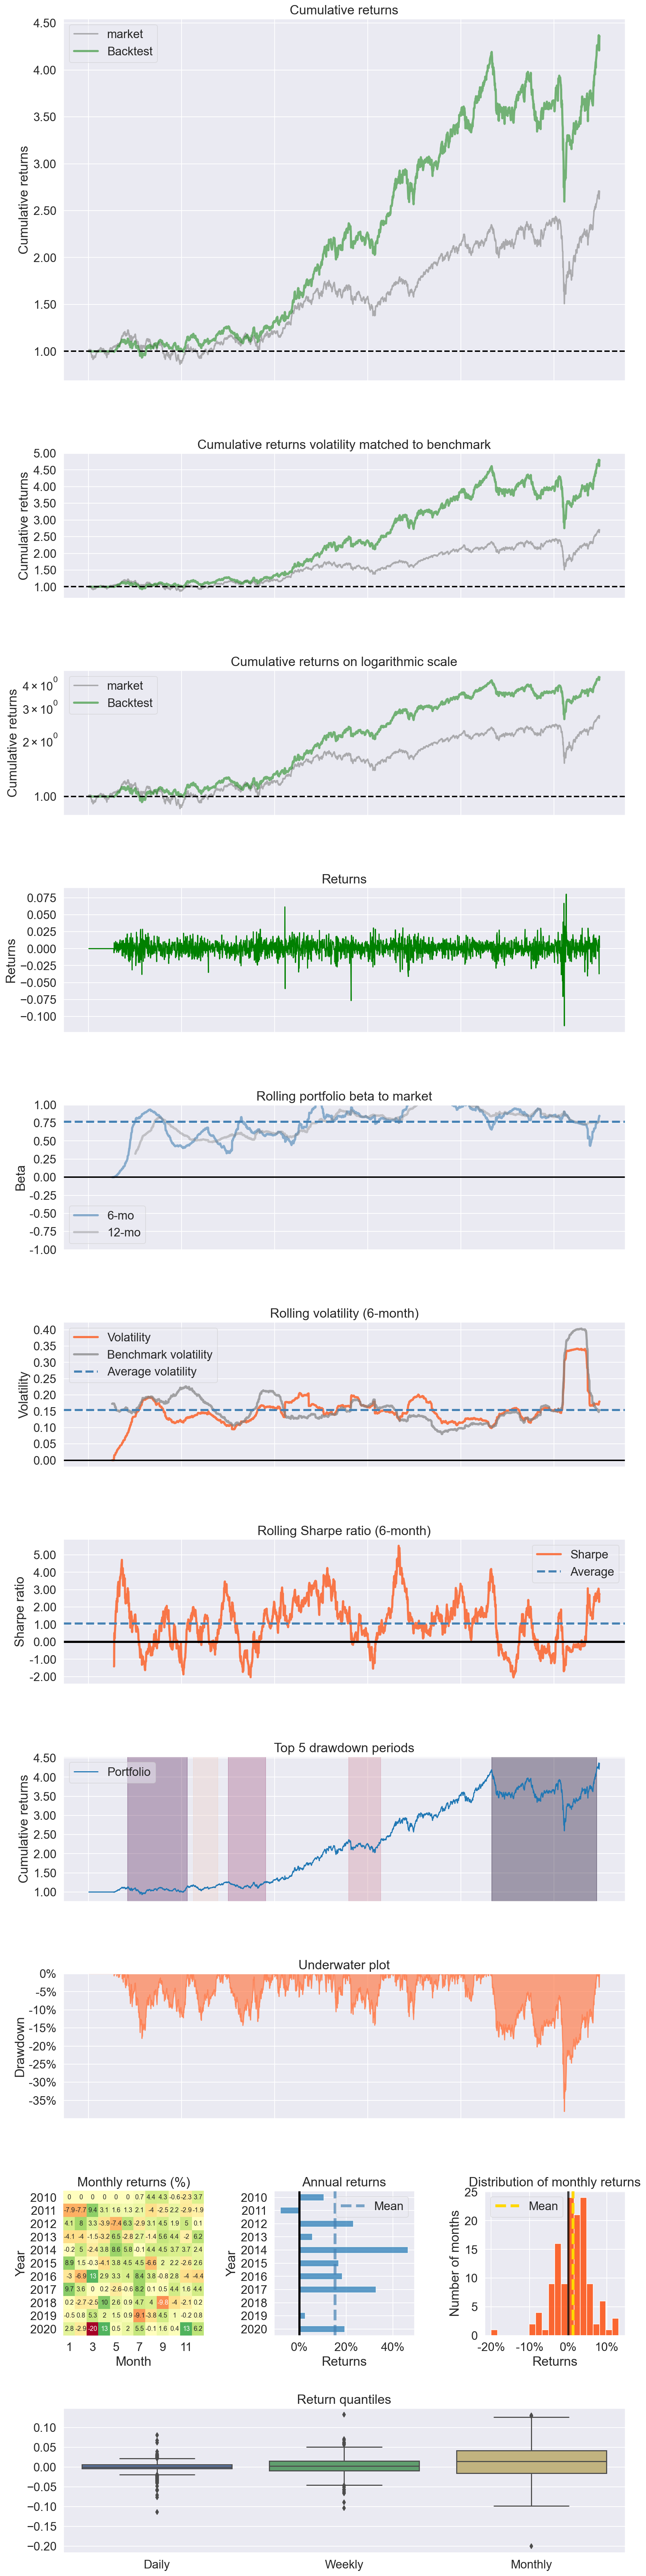

In [51]:
pf.create_returns_tear_sheet(ret_df.stra_riskp,benchmark_rets=ret_df.market)

In [52]:
# with pd.HDFStore(DATA_STORE) as store:
#     store.put('nse100/monthly/results', ret_df)
with pd.HDFStore(DATA_STORE) as store:
    store.put('nse100/weekly/results', ret_df)

In [53]:
with pd.HDFStore(DATA_STORE) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/mom_results.h5
/nse100/eq_wts/monthly/positions                   frame        (shape->[2728,2])
/nse100/eq_wts/monthly/returns                     series       (shape->[2728])  
/nse100/eq_wts/monthly/transactions                frame        (shape->[1894,5])
/nse100/eq_wts/weekly/positions                    frame        (shape->[2728,2])
/nse100/eq_wts/weekly/returns                      series       (shape->[2728])  
/nse100/eq_wts/weekly/transactions                 frame        (shape->[2110,5])
/nse100/monthly/results                            frame        (shape->[2723,3])
/nse100/riskparity/monthly/positions               frame        (shape->[2728,2])
/nse100/riskparity/monthly/returns                 series       (shape->[2728])  
/nse100/riskparity/monthly/transactions            frame        (shape->[1021,5])
/nse100/riskparity/weekly/positions                frame        (shape->[2728,2])
/nse100/riskparity/weekly/ret